In [1]:
import os
import os.path
import glob
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
%matplotlib inline

import numpy as np
np.random.seed(1)

import random
from skimage import io
import cv2
from keras.preprocessing.image import img_to_array
from vis.utils import utils
from vis.visualization import visualize_cam,visualize_saliency

from keras import backend as K
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import RMSprop, SGD

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False)

In [7]:
filename = 'virussign-resnet50features.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from virussign-resnet50features.npy ...


In [8]:
resnet50features.shape

(9339, 1, 1, 2048)

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [10]:
# Training top_model and saving min training loss weights
num_epochs=2000
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
early_stopping = EarlyStopping(verbose=1, patience=20, monitor='val_loss')
checkpointer = ModelCheckpoint(filepath='virussign-top-weights-min_loss-mlp-resnet50-Adam-2000epochs-earlystop.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
callbacks_list = [early_stopping, checkpointer]
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = resnet50features[train_indices]
    Y_train = Y[train_indices]
    X_test = resnet50features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_input = Input(shape=resnet50features.shape[1:])
    x = GlobalAveragePooling2D(name='avg_pool')(top_input)
    predict = Dense(num_classes, activation='softmax', name='predictions')(x)
    top_model = Model(input=top_input, output=predict)                            
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=callbacks_list)
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


Train on 8394 samples, validate on 945 samples
Epoch 1/2000
8394/8394 [==============================] - 0s - loss: 4.8370 - acc: 0.0394 - val_loss: 4.1096 - val_acc: 0.0402
Epoch 2/2000
8394/8394 [==============================] - 0s - loss: 4.1151 - acc: 0.0411 - val_loss: 3.3759 - val_acc: 0.1513
Epoch 3/2000
8394/8394 [==============================] - 0s - loss: 3.3785 - acc: 0.1483 - val_loss: 2.8256 - val_acc: 0.2434
Epoch 4/2000
8394/8394 [==============================] - 0s - loss: 2.8248 - acc: 0.2412 - val_loss: 2.4059 - val_acc: 0.2434
Epoch 5/2000
8394/8394 [==============================] - 0s - loss: 2.4009 - acc: 0.2397 - val_loss: 2.1094 - val_acc: 0.3926
Epoch 6/2000
8394/8394 [==============================] - 0s - loss: 2.0998 - acc: 0.3890 - val_loss: 1.9311 - val_acc: 0.4466
Epoch 7/2000
8394/8394 [==============================] - 0s - loss: 1.9176 - acc: 0.4414 - val_loss: 1.8289 - val_acc: 0.4063
Epoch 8/2000
8394/8394 [==============================] - 0s - l

8394/8394 [==============================] - 0s - loss: 0.2264 - acc: 0.9440 - val_loss: 0.2482 - val_acc: 0.9333
Epoch 65/2000
8394/8394 [==============================] - 0s - loss: 0.2237 - acc: 0.9441 - val_loss: 0.2458 - val_acc: 0.9333
Epoch 66/2000
8394/8394 [==============================] - 0s - loss: 0.2212 - acc: 0.9438 - val_loss: 0.2436 - val_acc: 0.9333
Epoch 67/2000
8394/8394 [==============================] - 0s - loss: 0.2188 - acc: 0.9441 - val_loss: 0.2413 - val_acc: 0.9333
Epoch 68/2000
8394/8394 [==============================] - 0s - loss: 0.2165 - acc: 0.9444 - val_loss: 0.2392 - val_acc: 0.9333
Epoch 69/2000
8394/8394 [==============================] - 0s - loss: 0.2142 - acc: 0.9452 - val_loss: 0.2370 - val_acc: 0.9344
Epoch 70/2000
8394/8394 [==============================] - 0s - loss: 0.2120 - acc: 0.9458 - val_loss: 0.2350 - val_acc: 0.9354
Epoch 71/2000
8394/8394 [==============================] - 0s - loss: 0.2099 - acc: 0.9463 - val_loss: 0.2329 - val_ac

8394/8394 [==============================] - 0s - loss: 0.1376 - acc: 0.9629 - val_loss: 0.1637 - val_acc: 0.9524
Epoch 128/2000
8394/8394 [==============================] - 0s - loss: 0.1368 - acc: 0.9632 - val_loss: 0.1630 - val_acc: 0.9524
Epoch 129/2000
8394/8394 [==============================] - 0s - loss: 0.1360 - acc: 0.9632 - val_loss: 0.1623 - val_acc: 0.9524
Epoch 130/2000
8394/8394 [==============================] - 0s - loss: 0.1352 - acc: 0.9632 - val_loss: 0.1615 - val_acc: 0.9524
Epoch 131/2000
8394/8394 [==============================] - 0s - loss: 0.1345 - acc: 0.9632 - val_loss: 0.1608 - val_acc: 0.9524
Epoch 132/2000
8394/8394 [==============================] - 0s - loss: 0.1337 - acc: 0.9634 - val_loss: 0.1601 - val_acc: 0.9524
Epoch 133/2000
8394/8394 [==============================] - 0s - loss: 0.1330 - acc: 0.9637 - val_loss: 0.1594 - val_acc: 0.9524
Epoch 134/2000
8394/8394 [==============================] - 0s - loss: 0.1323 - acc: 0.9637 - val_loss: 0.1587 -

8394/8394 [==============================] - 0s - loss: 0.1019 - acc: 0.9727 - val_loss: 0.1301 - val_acc: 0.9566
Epoch 191/2000
8394/8394 [==============================] - 0s - loss: 0.1015 - acc: 0.9733 - val_loss: 0.1297 - val_acc: 0.9577
Epoch 192/2000
8394/8394 [==============================] - 0s - loss: 0.1011 - acc: 0.9736 - val_loss: 0.1294 - val_acc: 0.9577
Epoch 193/2000
8394/8394 [==============================] - 0s - loss: 0.1006 - acc: 0.9736 - val_loss: 0.1290 - val_acc: 0.9577
Epoch 194/2000
8394/8394 [==============================] - 0s - loss: 0.1003 - acc: 0.9739 - val_loss: 0.1286 - val_acc: 0.9587
Epoch 195/2000
8394/8394 [==============================] - 0s - loss: 0.0999 - acc: 0.9740 - val_loss: 0.1282 - val_acc: 0.9587
Epoch 196/2000
8394/8394 [==============================] - 0s - loss: 0.0995 - acc: 0.9741 - val_loss: 0.1279 - val_acc: 0.9587
Epoch 197/2000
8394/8394 [==============================] - 0s - loss: 0.0991 - acc: 0.9741 - val_loss: 0.1275 -

8394/8394 [==============================] - 0s - loss: 0.0813 - acc: 0.9792 - val_loss: 0.1106 - val_acc: 0.9651
Epoch 254/2000
8394/8394 [==============================] - 0s - loss: 0.0810 - acc: 0.9793 - val_loss: 0.1104 - val_acc: 0.9651
Epoch 255/2000
8394/8394 [==============================] - 0s - loss: 0.0807 - acc: 0.9793 - val_loss: 0.1101 - val_acc: 0.9651
Epoch 256/2000
8394/8394 [==============================] - 0s - loss: 0.0805 - acc: 0.9793 - val_loss: 0.1099 - val_acc: 0.9651
Epoch 257/2000
8394/8394 [==============================] - 0s - loss: 0.0802 - acc: 0.9794 - val_loss: 0.1096 - val_acc: 0.9651
Epoch 258/2000
8394/8394 [==============================] - 0s - loss: 0.0800 - acc: 0.9794 - val_loss: 0.1094 - val_acc: 0.9651
Epoch 259/2000
8394/8394 [==============================] - 0s - loss: 0.0797 - acc: 0.9795 - val_loss: 0.1091 - val_acc: 0.9651
Epoch 260/2000
8394/8394 [==============================] - 0s - loss: 0.0795 - acc: 0.9796 - val_loss: 0.1089 -

8394/8394 [==============================] - 0s - loss: 0.0672 - acc: 0.9812 - val_loss: 0.0973 - val_acc: 0.9651
Epoch 317/2000
8394/8394 [==============================] - 0s - loss: 0.0670 - acc: 0.9812 - val_loss: 0.0971 - val_acc: 0.9651
Epoch 318/2000
8394/8394 [==============================] - 0s - loss: 0.0668 - acc: 0.9812 - val_loss: 0.0969 - val_acc: 0.9651
Epoch 319/2000
8394/8394 [==============================] - 0s - loss: 0.0667 - acc: 0.9812 - val_loss: 0.0968 - val_acc: 0.9651
Epoch 320/2000
8394/8394 [==============================] - 0s - loss: 0.0665 - acc: 0.9812 - val_loss: 0.0966 - val_acc: 0.9651
Epoch 321/2000
8394/8394 [==============================] - 0s - loss: 0.0663 - acc: 0.9814 - val_loss: 0.0964 - val_acc: 0.9651
Epoch 322/2000
8394/8394 [==============================] - 0s - loss: 0.0661 - acc: 0.9814 - val_loss: 0.0962 - val_acc: 0.9651
Epoch 323/2000
8394/8394 [==============================] - 0s - loss: 0.0659 - acc: 0.9815 - val_loss: 0.0961 -

8394/8394 [==============================] - 0s - loss: 0.0567 - acc: 0.9826 - val_loss: 0.0874 - val_acc: 0.9661
Epoch 380/2000
8394/8394 [==============================] - 0s - loss: 0.0566 - acc: 0.9826 - val_loss: 0.0873 - val_acc: 0.9661
Epoch 381/2000
8394/8394 [==============================] - 0s - loss: 0.0564 - acc: 0.9826 - val_loss: 0.0872 - val_acc: 0.9661
Epoch 382/2000
8394/8394 [==============================] - 0s - loss: 0.0563 - acc: 0.9826 - val_loss: 0.0870 - val_acc: 0.9661
Epoch 383/2000
8394/8394 [==============================] - 0s - loss: 0.0561 - acc: 0.9826 - val_loss: 0.0869 - val_acc: 0.9661
Epoch 384/2000
8394/8394 [==============================] - 0s - loss: 0.0560 - acc: 0.9826 - val_loss: 0.0868 - val_acc: 0.9661
Epoch 385/2000
8394/8394 [==============================] - 0s - loss: 0.0559 - acc: 0.9826 - val_loss: 0.0866 - val_acc: 0.9661
Epoch 386/2000
8394/8394 [==============================] - 0s - loss: 0.0557 - acc: 0.9826 - val_loss: 0.0865 -

8394/8394 [==============================] - 0s - loss: 0.0485 - acc: 0.9839 - val_loss: 0.0799 - val_acc: 0.9672
Epoch 443/2000
8394/8394 [==============================] - 0s - loss: 0.0484 - acc: 0.9839 - val_loss: 0.0798 - val_acc: 0.9672
Epoch 444/2000
8394/8394 [==============================] - 0s - loss: 0.0482 - acc: 0.9839 - val_loss: 0.0796 - val_acc: 0.9672
Epoch 445/2000
8394/8394 [==============================] - 0s - loss: 0.0481 - acc: 0.9839 - val_loss: 0.0795 - val_acc: 0.9672
Epoch 446/2000
8394/8394 [==============================] - 0s - loss: 0.0480 - acc: 0.9839 - val_loss: 0.0794 - val_acc: 0.9672
Epoch 447/2000
8394/8394 [==============================] - 0s - loss: 0.0479 - acc: 0.9839 - val_loss: 0.0793 - val_acc: 0.9672
Epoch 448/2000
8394/8394 [==============================] - 0s - loss: 0.0478 - acc: 0.9839 - val_loss: 0.0792 - val_acc: 0.9672
Epoch 449/2000
8394/8394 [==============================] - 0s - loss: 0.0477 - acc: 0.9839 - val_loss: 0.0791 -

8394/8394 [==============================] - 0s - loss: 0.0418 - acc: 0.9964 - val_loss: 0.0739 - val_acc: 0.9810
Epoch 506/2000
8394/8394 [==============================] - 0s - loss: 0.0417 - acc: 0.9964 - val_loss: 0.0738 - val_acc: 0.9810
Epoch 507/2000
8394/8394 [==============================] - 0s - loss: 0.0416 - acc: 0.9964 - val_loss: 0.0738 - val_acc: 0.9810
Epoch 508/2000
8394/8394 [==============================] - 0s - loss: 0.0415 - acc: 0.9964 - val_loss: 0.0737 - val_acc: 0.9810
Epoch 509/2000
8394/8394 [==============================] - 0s - loss: 0.0414 - acc: 0.9964 - val_loss: 0.0736 - val_acc: 0.9810
Epoch 510/2000
8394/8394 [==============================] - 0s - loss: 0.0414 - acc: 0.9964 - val_loss: 0.0735 - val_acc: 0.9810
Epoch 511/2000
8394/8394 [==============================] - 0s - loss: 0.0413 - acc: 0.9964 - val_loss: 0.0734 - val_acc: 0.9810
Epoch 512/2000
8394/8394 [==============================] - 0s - loss: 0.0412 - acc: 0.9964 - val_loss: 0.0733 -

8394/8394 [==============================] - 0s - loss: 0.0364 - acc: 0.9971 - val_loss: 0.0692 - val_acc: 0.9810
Epoch 569/2000
8394/8394 [==============================] - 0s - loss: 0.0363 - acc: 0.9971 - val_loss: 0.0692 - val_acc: 0.9810
Epoch 570/2000
8394/8394 [==============================] - 0s - loss: 0.0362 - acc: 0.9971 - val_loss: 0.0691 - val_acc: 0.9810
Epoch 571/2000
8394/8394 [==============================] - 0s - loss: 0.0361 - acc: 0.9973 - val_loss: 0.0690 - val_acc: 0.9810
Epoch 572/2000
8394/8394 [==============================] - 0s - loss: 0.0360 - acc: 0.9973 - val_loss: 0.0690 - val_acc: 0.9810
Epoch 573/2000
8394/8394 [==============================] - 0s - loss: 0.0360 - acc: 0.9973 - val_loss: 0.0689 - val_acc: 0.9810
Epoch 574/2000
8394/8394 [==============================] - 0s - loss: 0.0359 - acc: 0.9973 - val_loss: 0.0688 - val_acc: 0.9810
Epoch 575/2000
8394/8394 [==============================] - 0s - loss: 0.0358 - acc: 0.9973 - val_loss: 0.0688 -

8394/8394 [==============================] - 0s - loss: 0.0318 - acc: 0.9974 - val_loss: 0.0655 - val_acc: 0.9799
Epoch 632/2000
8394/8394 [==============================] - 0s - loss: 0.0318 - acc: 0.9974 - val_loss: 0.0654 - val_acc: 0.9799
Epoch 633/2000
8394/8394 [==============================] - 0s - loss: 0.0317 - acc: 0.9974 - val_loss: 0.0654 - val_acc: 0.9799
Epoch 634/2000
8394/8394 [==============================] - 0s - loss: 0.0316 - acc: 0.9974 - val_loss: 0.0653 - val_acc: 0.9799
Epoch 635/2000
8394/8394 [==============================] - 0s - loss: 0.0316 - acc: 0.9974 - val_loss: 0.0652 - val_acc: 0.9799
Epoch 636/2000
8394/8394 [==============================] - 0s - loss: 0.0315 - acc: 0.9974 - val_loss: 0.0652 - val_acc: 0.9799
Epoch 637/2000
8394/8394 [==============================] - 0s - loss: 0.0314 - acc: 0.9974 - val_loss: 0.0651 - val_acc: 0.9799
Epoch 638/2000
8394/8394 [==============================] - 0s - loss: 0.0314 - acc: 0.9974 - val_loss: 0.0651 -

8394/8394 [==============================] - 0s - loss: 0.0280 - acc: 0.9977 - val_loss: 0.0624 - val_acc: 0.9810
Epoch 695/2000
8394/8394 [==============================] - 0s - loss: 0.0280 - acc: 0.9977 - val_loss: 0.0624 - val_acc: 0.9810
Epoch 696/2000
8394/8394 [==============================] - 0s - loss: 0.0279 - acc: 0.9977 - val_loss: 0.0623 - val_acc: 0.9810
Epoch 697/2000
8394/8394 [==============================] - 0s - loss: 0.0279 - acc: 0.9977 - val_loss: 0.0623 - val_acc: 0.9810
Epoch 698/2000
8394/8394 [==============================] - 0s - loss: 0.0278 - acc: 0.9977 - val_loss: 0.0622 - val_acc: 0.9810
Epoch 699/2000
8394/8394 [==============================] - 0s - loss: 0.0278 - acc: 0.9977 - val_loss: 0.0622 - val_acc: 0.9810
Epoch 700/2000
8394/8394 [==============================] - 0s - loss: 0.0277 - acc: 0.9977 - val_loss: 0.0622 - val_acc: 0.9810
Epoch 701/2000
8394/8394 [==============================] - 0s - loss: 0.0277 - acc: 0.9977 - val_loss: 0.0621 -

8394/8394 [==============================] - 0s - loss: 0.0249 - acc: 0.9985 - val_loss: 0.0599 - val_acc: 0.9810
Epoch 758/2000
8394/8394 [==============================] - 0s - loss: 0.0248 - acc: 0.9985 - val_loss: 0.0599 - val_acc: 0.9810
Epoch 759/2000
8394/8394 [==============================] - 0s - loss: 0.0248 - acc: 0.9985 - val_loss: 0.0598 - val_acc: 0.9810
Epoch 760/2000
8394/8394 [==============================] - 0s - loss: 0.0247 - acc: 0.9985 - val_loss: 0.0598 - val_acc: 0.9810
Epoch 761/2000
8394/8394 [==============================] - 0s - loss: 0.0247 - acc: 0.9986 - val_loss: 0.0598 - val_acc: 0.9810
Epoch 762/2000
8394/8394 [==============================] - 0s - loss: 0.0246 - acc: 0.9986 - val_loss: 0.0597 - val_acc: 0.9810
Epoch 763/2000
8394/8394 [==============================] - 0s - loss: 0.0246 - acc: 0.9986 - val_loss: 0.0597 - val_acc: 0.9810
Epoch 764/2000
8394/8394 [==============================] - 0s - loss: 0.0245 - acc: 0.9986 - val_loss: 0.0597 -

8394/8394 [==============================] - 0s - loss: 0.0222 - acc: 0.9989 - val_loss: 0.0579 - val_acc: 0.9810
Epoch 821/2000
8394/8394 [==============================] - 0s - loss: 0.0221 - acc: 0.9989 - val_loss: 0.0578 - val_acc: 0.9810
Epoch 822/2000
8394/8394 [==============================] - 0s - loss: 0.0221 - acc: 0.9989 - val_loss: 0.0578 - val_acc: 0.9810
Epoch 823/2000
8394/8394 [==============================] - 0s - loss: 0.0221 - acc: 0.9989 - val_loss: 0.0578 - val_acc: 0.9810
Epoch 824/2000
8394/8394 [==============================] - 0s - loss: 0.0220 - acc: 0.9989 - val_loss: 0.0578 - val_acc: 0.9810
Epoch 825/2000
8394/8394 [==============================] - 0s - loss: 0.0220 - acc: 0.9989 - val_loss: 0.0577 - val_acc: 0.9810
Epoch 826/2000
8394/8394 [==============================] - 0s - loss: 0.0219 - acc: 0.9989 - val_loss: 0.0577 - val_acc: 0.9810
Epoch 827/2000
8394/8394 [==============================] - 0s - loss: 0.0219 - acc: 0.9989 - val_loss: 0.0577 -

8394/8394 [==============================] - 0s - loss: 0.0199 - acc: 0.9993 - val_loss: 0.0562 - val_acc: 0.9810
Epoch 884/2000
8394/8394 [==============================] - 0s - loss: 0.0199 - acc: 0.9993 - val_loss: 0.0562 - val_acc: 0.9810
Epoch 885/2000
8394/8394 [==============================] - 0s - loss: 0.0198 - acc: 0.9993 - val_loss: 0.0561 - val_acc: 0.9810
Epoch 886/2000
8394/8394 [==============================] - 0s - loss: 0.0198 - acc: 0.9993 - val_loss: 0.0561 - val_acc: 0.9810
Epoch 887/2000
8394/8394 [==============================] - 0s - loss: 0.0198 - acc: 0.9993 - val_loss: 0.0561 - val_acc: 0.9810
Epoch 888/2000
8394/8394 [==============================] - 0s - loss: 0.0197 - acc: 0.9993 - val_loss: 0.0561 - val_acc: 0.9810
Epoch 889/2000
8394/8394 [==============================] - 0s - loss: 0.0197 - acc: 0.9993 - val_loss: 0.0560 - val_acc: 0.9810
Epoch 890/2000
8394/8394 [==============================] - 0s - loss: 0.0197 - acc: 0.9993 - val_loss: 0.0560 -

8394/8394 [==============================] - 0s - loss: 0.0179 - acc: 0.9995 - val_loss: 0.0548 - val_acc: 0.9810
Epoch 947/2000
8394/8394 [==============================] - 0s - loss: 0.0179 - acc: 0.9995 - val_loss: 0.0548 - val_acc: 0.9810
Epoch 948/2000
8394/8394 [==============================] - 0s - loss: 0.0179 - acc: 0.9995 - val_loss: 0.0548 - val_acc: 0.9810
Epoch 949/2000
8394/8394 [==============================] - 0s - loss: 0.0178 - acc: 0.9995 - val_loss: 0.0547 - val_acc: 0.9810
Epoch 950/2000
8394/8394 [==============================] - 0s - loss: 0.0178 - acc: 0.9995 - val_loss: 0.0547 - val_acc: 0.9810
Epoch 951/2000
8394/8394 [==============================] - 0s - loss: 0.0178 - acc: 0.9995 - val_loss: 0.0547 - val_acc: 0.9810
Epoch 952/2000
8394/8394 [==============================] - 0s - loss: 0.0178 - acc: 0.9995 - val_loss: 0.0547 - val_acc: 0.9810
Epoch 953/2000
8394/8394 [==============================] - 0s - loss: 0.0177 - acc: 0.9995 - val_loss: 0.0547 -

8394/8394 [==============================] - 0s - loss: 0.0162 - acc: 0.9995 - val_loss: 0.0536 - val_acc: 0.9810
Epoch 1010/2000
8394/8394 [==============================] - 0s - loss: 0.0162 - acc: 0.9995 - val_loss: 0.0536 - val_acc: 0.9810
Epoch 1011/2000
8394/8394 [==============================] - 0s - loss: 0.0162 - acc: 0.9995 - val_loss: 0.0536 - val_acc: 0.9810
Epoch 1012/2000
8394/8394 [==============================] - 0s - loss: 0.0162 - acc: 0.9995 - val_loss: 0.0536 - val_acc: 0.9810
Epoch 1013/2000
8394/8394 [==============================] - 0s - loss: 0.0161 - acc: 0.9995 - val_loss: 0.0536 - val_acc: 0.9810
Epoch 1014/2000
8394/8394 [==============================] - 0s - loss: 0.0161 - acc: 0.9995 - val_loss: 0.0536 - val_acc: 0.9810
Epoch 1015/2000
8394/8394 [==============================] - 0s - loss: 0.0161 - acc: 0.9995 - val_loss: 0.0535 - val_acc: 0.9810
Epoch 1016/2000
8394/8394 [==============================] - 0s - loss: 0.0161 - acc: 0.9995 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0148 - acc: 0.9995 - val_loss: 0.0527 - val_acc: 0.9810
Epoch 1073/2000
8394/8394 [==============================] - 0s - loss: 0.0147 - acc: 0.9995 - val_loss: 0.0527 - val_acc: 0.9810
Epoch 1074/2000
8394/8394 [==============================] - 0s - loss: 0.0147 - acc: 0.9995 - val_loss: 0.0527 - val_acc: 0.9810
Epoch 1075/2000
8394/8394 [==============================] - 0s - loss: 0.0147 - acc: 0.9995 - val_loss: 0.0526 - val_acc: 0.9810
Epoch 1076/2000
8394/8394 [==============================] - 0s - loss: 0.0147 - acc: 0.9995 - val_loss: 0.0526 - val_acc: 0.9810
Epoch 1077/2000
8394/8394 [==============================] - 0s - loss: 0.0146 - acc: 0.9995 - val_loss: 0.0526 - val_acc: 0.9810
Epoch 1078/2000
8394/8394 [==============================] - 0s - loss: 0.0146 - acc: 0.9995 - val_loss: 0.0526 - val_acc: 0.9810
Epoch 1079/2000
8394/8394 [==============================] - 0s - loss: 0.0146 - acc: 0.9995 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0135 - acc: 0.9996 - val_loss: 0.0519 - val_acc: 0.9810
Epoch 1136/2000
8394/8394 [==============================] - 0s - loss: 0.0134 - acc: 0.9996 - val_loss: 0.0519 - val_acc: 0.9810
Epoch 1137/2000
8394/8394 [==============================] - 0s - loss: 0.0134 - acc: 0.9996 - val_loss: 0.0519 - val_acc: 0.9810
Epoch 1138/2000
8394/8394 [==============================] - 0s - loss: 0.0134 - acc: 0.9996 - val_loss: 0.0519 - val_acc: 0.9810
Epoch 1139/2000
8394/8394 [==============================] - 0s - loss: 0.0134 - acc: 0.9996 - val_loss: 0.0518 - val_acc: 0.9810
Epoch 1140/2000
8394/8394 [==============================] - 0s - loss: 0.0134 - acc: 0.9996 - val_loss: 0.0518 - val_acc: 0.9810
Epoch 1141/2000
8394/8394 [==============================] - 0s - loss: 0.0133 - acc: 0.9996 - val_loss: 0.0518 - val_acc: 0.9810
Epoch 1142/2000
8394/8394 [==============================] - 0s - loss: 0.0133 - acc: 0.9996 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0123 - acc: 0.9999 - val_loss: 0.0512 - val_acc: 0.9810
Epoch 1199/2000
8394/8394 [==============================] - 0s - loss: 0.0123 - acc: 0.9999 - val_loss: 0.0512 - val_acc: 0.9810
Epoch 1200/2000
8394/8394 [==============================] - 0s - loss: 0.0123 - acc: 0.9999 - val_loss: 0.0512 - val_acc: 0.9810
Epoch 1201/2000
8394/8394 [==============================] - 0s - loss: 0.0123 - acc: 0.9999 - val_loss: 0.0512 - val_acc: 0.9810
Epoch 1202/2000
8394/8394 [==============================] - 0s - loss: 0.0123 - acc: 0.9999 - val_loss: 0.0512 - val_acc: 0.9810
Epoch 1203/2000
8394/8394 [==============================] - 0s - loss: 0.0122 - acc: 0.9999 - val_loss: 0.0512 - val_acc: 0.9810
Epoch 1204/2000
8394/8394 [==============================] - 0s - loss: 0.0122 - acc: 0.9999 - val_loss: 0.0512 - val_acc: 0.9810
Epoch 1205/2000
8394/8394 [==============================] - 0s - loss: 0.0122 - acc: 0.9999 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0113 - acc: 0.9999 - val_loss: 0.0507 - val_acc: 0.9810
Epoch 1262/2000
8394/8394 [==============================] - 0s - loss: 0.0113 - acc: 0.9999 - val_loss: 0.0507 - val_acc: 0.9810
Epoch 1263/2000
8394/8394 [==============================] - 0s - loss: 0.0113 - acc: 0.9999 - val_loss: 0.0506 - val_acc: 0.9810
Epoch 1264/2000
8394/8394 [==============================] - 0s - loss: 0.0113 - acc: 0.9999 - val_loss: 0.0506 - val_acc: 0.9810
Epoch 1265/2000
8394/8394 [==============================] - 0s - loss: 0.0113 - acc: 0.9999 - val_loss: 0.0506 - val_acc: 0.9810
Epoch 1266/2000
8394/8394 [==============================] - 0s - loss: 0.0112 - acc: 0.9999 - val_loss: 0.0506 - val_acc: 0.9810
Epoch 1267/2000
8394/8394 [==============================] - 0s - loss: 0.0112 - acc: 0.9999 - val_loss: 0.0506 - val_acc: 0.9810
Epoch 1268/2000
8394/8394 [==============================] - 0s - loss: 0.0112 - acc: 0.9999 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0104 - acc: 0.9999 - val_loss: 0.0502 - val_acc: 0.9810
Epoch 1325/2000
8394/8394 [==============================] - 0s - loss: 0.0104 - acc: 0.9999 - val_loss: 0.0502 - val_acc: 0.9810
Epoch 1326/2000
8394/8394 [==============================] - 0s - loss: 0.0104 - acc: 0.9999 - val_loss: 0.0502 - val_acc: 0.9810
Epoch 1327/2000
8394/8394 [==============================] - 0s - loss: 0.0104 - acc: 0.9999 - val_loss: 0.0502 - val_acc: 0.9810
Epoch 1328/2000
8394/8394 [==============================] - 0s - loss: 0.0104 - acc: 0.9999 - val_loss: 0.0502 - val_acc: 0.9810
Epoch 1329/2000
8394/8394 [==============================] - 0s - loss: 0.0104 - acc: 0.9999 - val_loss: 0.0502 - val_acc: 0.9810
Epoch 1330/2000
8394/8394 [==============================] - 0s - loss: 0.0104 - acc: 0.9999 - val_loss: 0.0502 - val_acc: 0.9810
Epoch 1331/2000
8394/8394 [==============================] - 0s - loss: 0.0103 - acc: 0.9999 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0096 - acc: 0.9999 - val_loss: 0.0498 - val_acc: 0.9810
Epoch 1388/2000
8394/8394 [==============================] - 0s - loss: 0.0096 - acc: 0.9999 - val_loss: 0.0498 - val_acc: 0.9810
Epoch 1389/2000
8394/8394 [==============================] - 0s - loss: 0.0096 - acc: 0.9999 - val_loss: 0.0498 - val_acc: 0.9810
Epoch 1390/2000
8394/8394 [==============================] - 0s - loss: 0.0096 - acc: 0.9999 - val_loss: 0.0498 - val_acc: 0.9810
Epoch 1391/2000
8394/8394 [==============================] - 0s - loss: 0.0096 - acc: 0.9999 - val_loss: 0.0498 - val_acc: 0.9810
Epoch 1392/2000
8394/8394 [==============================] - 0s - loss: 0.0096 - acc: 0.9999 - val_loss: 0.0498 - val_acc: 0.9810
Epoch 1393/2000
8394/8394 [==============================] - 0s - loss: 0.0096 - acc: 0.9999 - val_loss: 0.0498 - val_acc: 0.9810
Epoch 1394/2000
8394/8394 [==============================] - 0s - loss: 0.0095 - acc: 0.9999 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0089 - acc: 0.9999 - val_loss: 0.0495 - val_acc: 0.9799
Epoch 1451/2000
8394/8394 [==============================] - 0s - loss: 0.0089 - acc: 0.9999 - val_loss: 0.0495 - val_acc: 0.9799
Epoch 1452/2000
8394/8394 [==============================] - 0s - loss: 0.0089 - acc: 0.9999 - val_loss: 0.0495 - val_acc: 0.9799
Epoch 1453/2000
8394/8394 [==============================] - 0s - loss: 0.0089 - acc: 0.9999 - val_loss: 0.0495 - val_acc: 0.9799
Epoch 1454/2000
8394/8394 [==============================] - 0s - loss: 0.0089 - acc: 0.9999 - val_loss: 0.0495 - val_acc: 0.9799
Epoch 1455/2000
8394/8394 [==============================] - 0s - loss: 0.0089 - acc: 0.9999 - val_loss: 0.0495 - val_acc: 0.9799
Epoch 1456/2000
8394/8394 [==============================] - 0s - loss: 0.0089 - acc: 0.9999 - val_loss: 0.0495 - val_acc: 0.9799
Epoch 1457/2000
8394/8394 [==============================] - 0s - loss: 0.0088 - acc: 0.9999 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0083 - acc: 0.9999 - val_loss: 0.0492 - val_acc: 0.9799
Epoch 1514/2000
8394/8394 [==============================] - 0s - loss: 0.0083 - acc: 0.9999 - val_loss: 0.0492 - val_acc: 0.9799
Epoch 1515/2000
8394/8394 [==============================] - 0s - loss: 0.0083 - acc: 0.9999 - val_loss: 0.0492 - val_acc: 0.9799
Epoch 1516/2000
8394/8394 [==============================] - 0s - loss: 0.0082 - acc: 0.9999 - val_loss: 0.0492 - val_acc: 0.9799
Epoch 1517/2000
8394/8394 [==============================] - 0s - loss: 0.0082 - acc: 0.9999 - val_loss: 0.0492 - val_acc: 0.9799
Epoch 1518/2000
8394/8394 [==============================] - 0s - loss: 0.0082 - acc: 0.9999 - val_loss: 0.0492 - val_acc: 0.9799
Epoch 1519/2000
8394/8394 [==============================] - 0s - loss: 0.0082 - acc: 0.9999 - val_loss: 0.0492 - val_acc: 0.9799
Epoch 1520/2000
8394/8394 [==============================] - 0s - loss: 0.0082 - acc: 0.9999 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0077 - acc: 0.9999 - val_loss: 0.0490 - val_acc: 0.9799
Epoch 1577/2000
8394/8394 [==============================] - 0s - loss: 0.0077 - acc: 0.9999 - val_loss: 0.0490 - val_acc: 0.9799
Epoch 1578/2000
8394/8394 [==============================] - 0s - loss: 0.0077 - acc: 0.9999 - val_loss: 0.0490 - val_acc: 0.9799
Epoch 1579/2000
8394/8394 [==============================] - 0s - loss: 0.0077 - acc: 0.9999 - val_loss: 0.0490 - val_acc: 0.9799
Epoch 1580/2000
8394/8394 [==============================] - 0s - loss: 0.0077 - acc: 0.9999 - val_loss: 0.0490 - val_acc: 0.9799
Epoch 1581/2000
8394/8394 [==============================] - 0s - loss: 0.0076 - acc: 0.9999 - val_loss: 0.0490 - val_acc: 0.9799
Epoch 1582/2000
8394/8394 [==============================] - 0s - loss: 0.0076 - acc: 0.9999 - val_loss: 0.0490 - val_acc: 0.9799
Epoch 1583/2000
8394/8394 [==============================] - 0s - loss: 0.0076 - acc: 0.9999 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0072 - acc: 0.9999 - val_loss: 0.0489 - val_acc: 0.9799
Epoch 1640/2000
8394/8394 [==============================] - 0s - loss: 0.0072 - acc: 0.9999 - val_loss: 0.0489 - val_acc: 0.9799
Epoch 1641/2000
8394/8394 [==============================] - 0s - loss: 0.0071 - acc: 0.9999 - val_loss: 0.0489 - val_acc: 0.9799
Epoch 1642/2000
8394/8394 [==============================] - 0s - loss: 0.0071 - acc: 0.9999 - val_loss: 0.0489 - val_acc: 0.9799
Epoch 1643/2000
8394/8394 [==============================] - 0s - loss: 0.0071 - acc: 0.9999 - val_loss: 0.0489 - val_acc: 0.9799
Epoch 1644/2000
8394/8394 [==============================] - 0s - loss: 0.0071 - acc: 0.9999 - val_loss: 0.0489 - val_acc: 0.9799
Epoch 1645/2000
8394/8394 [==============================] - 0s - loss: 0.0071 - acc: 0.9999 - val_loss: 0.0489 - val_acc: 0.9799
Epoch 1646/2000
8394/8394 [==============================] - 0s - loss: 0.0071 - acc: 0.9999 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0067 - acc: 0.9999 - val_loss: 0.0488 - val_acc: 0.9799
Epoch 1703/2000
8394/8394 [==============================] - 0s - loss: 0.0067 - acc: 0.9999 - val_loss: 0.0488 - val_acc: 0.9799
Epoch 1704/2000
8394/8394 [==============================] - 0s - loss: 0.0067 - acc: 0.9999 - val_loss: 0.0488 - val_acc: 0.9799
Epoch 1705/2000
8394/8394 [==============================] - 0s - loss: 0.0067 - acc: 0.9999 - val_loss: 0.0488 - val_acc: 0.9799
Epoch 1706/2000
8394/8394 [==============================] - 0s - loss: 0.0067 - acc: 0.9999 - val_loss: 0.0488 - val_acc: 0.9799
Epoch 1707/2000
8394/8394 [==============================] - 0s - loss: 0.0066 - acc: 0.9999 - val_loss: 0.0488 - val_acc: 0.9799
Epoch 1708/2000
8394/8394 [==============================] - 0s - loss: 0.0066 - acc: 0.9999 - val_loss: 0.0488 - val_acc: 0.9799
Epoch 1709/2000
8394/8394 [==============================] - 0s - loss: 0.0066 - acc: 0.9999 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0063 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9810
Epoch 1766/2000
8394/8394 [==============================] - 0s - loss: 0.0062 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9810
Epoch 1767/2000
8394/8394 [==============================] - 0s - loss: 0.0062 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9810
Epoch 1768/2000
8394/8394 [==============================] - 0s - loss: 0.0062 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9810
Epoch 1769/2000
8394/8394 [==============================] - 0s - loss: 0.0062 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9810
Epoch 1770/2000
8394/8394 [==============================] - 0s - loss: 0.0062 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9820
Epoch 1771/2000
8394/8394 [==============================] - 0s - loss: 0.0062 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9820
Epoch 1772/2000
8394/8394 [==============================] - 0s - loss: 0.0062 - acc: 0.9999 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0059 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9820
Epoch 1829/2000
8394/8394 [==============================] - 0s - loss: 0.0058 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9820
Epoch 1830/2000
8394/8394 [==============================] - 0s - loss: 0.0058 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9820
Epoch 1831/2000
8394/8394 [==============================] - 0s - loss: 0.0058 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9820
Epoch 1832/2000
8394/8394 [==============================] - 0s - loss: 0.0058 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9820
Epoch 1833/2000
8394/8394 [==============================] - 0s - loss: 0.0058 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9820
Epoch 1834/2000
8394/8394 [==============================] - 0s - loss: 0.0058 - acc: 0.9999 - val_loss: 0.0487 - val_acc: 0.9820
Epoch 1835/2000
8394/8394 [==============================] - 0s - loss: 0.0058 - acc: 0.9999 - val_loss: 0

8394/8394 [==============================] - 0s - loss: 0.0055 - acc: 0.9999 - val_loss: 0.0486 - val_acc: 0.9820
Epoch 1892/2000
8394/8394 [==============================] - 0s - loss: 0.0055 - acc: 0.9999 - val_loss: 0.0486 - val_acc: 0.9820
Epoch 1893/2000
8394/8394 [==============================] - 0s - loss: 0.0055 - acc: 0.9999 - val_loss: 0.0486 - val_acc: 0.9820
Epoch 1894/2000
8394/8394 [==============================] - 0s - loss: 0.0055 - acc: 0.9999 - val_loss: 0.0486 - val_acc: 0.9820
Epoch 1895/2000
8394/8394 [==============================] - 0s - loss: 0.0055 - acc: 0.9999 - val_loss: 0.0486 - val_acc: 0.9820
Epoch 1896/2000
8394/8394 [==============================] - 0s - loss: 0.0055 - acc: 0.9999 - val_loss: 0.0486 - val_acc: 0.9820
Epoch 1897/2000
8394/8394 [==============================] - 0s - loss: 0.0055 - acc: 0.9999 - val_loss: 0.0486 - val_acc: 0.9820
Epoch 1898/2000
8394/8394 [==============================] - 0s - loss: 0.0055 - acc: 0.9999 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.3118 - acc: 0.9184 - val_loss: 0.3174 - val_acc: 0.9130
Epoch 43/2000
8397/8397 [==============================] - 0s - loss: 0.3049 - acc: 0.9208 - val_loss: 0.3115 - val_acc: 0.9130
Epoch 44/2000
8397/8397 [==============================] - 0s - loss: 0.2988 - acc: 0.9251 - val_loss: 0.3063 - val_acc: 0.9161
Epoch 45/2000
8397/8397 [==============================] - 0s - loss: 0.2933 - acc: 0.9274 - val_loss: 0.3016 - val_acc: 0.9183
Epoch 46/2000
8397/8397 [==============================] - 0s - loss: 0.2883 - acc: 0.9296 - val_loss: 0.2973 - val_acc: 0.9225
Epoch 47/2000
8397/8397 [==============================] - 0s - loss: 0.2837 - acc: 0.9314 - val_loss: 0.2934 - val_acc: 0.9225
Epoch 48/2000
8397/8397 [==============================] - 0s - loss: 0.2795 - acc: 0.9325 - val_loss: 0.2897 - val_acc: 0.9236
Epoch 49/2000
8397/8397 [==============================] - 0s - loss: 0.2754 - acc: 0.9332 - val_loss: 0.2859 - val_ac

8397/8397 [==============================] - 0s - loss: 0.1540 - acc: 0.9606 - val_loss: 0.1711 - val_acc: 0.9522
Epoch 107/2000
8397/8397 [==============================] - 0s - loss: 0.1529 - acc: 0.9608 - val_loss: 0.1701 - val_acc: 0.9522
Epoch 108/2000
8397/8397 [==============================] - 0s - loss: 0.1519 - acc: 0.9613 - val_loss: 0.1691 - val_acc: 0.9522
Epoch 109/2000
8397/8397 [==============================] - 0s - loss: 0.1508 - acc: 0.9614 - val_loss: 0.1682 - val_acc: 0.9522
Epoch 110/2000
8397/8397 [==============================] - 0s - loss: 0.1498 - acc: 0.9614 - val_loss: 0.1672 - val_acc: 0.9522
Epoch 111/2000
8397/8397 [==============================] - 0s - loss: 0.1488 - acc: 0.9618 - val_loss: 0.1663 - val_acc: 0.9522
Epoch 112/2000
8397/8397 [==============================] - 0s - loss: 0.1478 - acc: 0.9619 - val_loss: 0.1654 - val_acc: 0.9522
Epoch 113/2000
8397/8397 [==============================] - 0s - loss: 0.1468 - acc: 0.9621 - val_loss: 0.1645 -

8397/8397 [==============================] - 0s - loss: 0.1079 - acc: 0.9671 - val_loss: 0.1292 - val_acc: 0.9522
Epoch 170/2000
8397/8397 [==============================] - 0s - loss: 0.1073 - acc: 0.9671 - val_loss: 0.1287 - val_acc: 0.9522
Epoch 171/2000
8397/8397 [==============================] - 0s - loss: 0.1068 - acc: 0.9674 - val_loss: 0.1283 - val_acc: 0.9522
Epoch 172/2000
8397/8397 [==============================] - 0s - loss: 0.1063 - acc: 0.9675 - val_loss: 0.1278 - val_acc: 0.9522
Epoch 173/2000
8397/8397 [==============================] - 0s - loss: 0.1059 - acc: 0.9677 - val_loss: 0.1274 - val_acc: 0.9522
Epoch 174/2000
8397/8397 [==============================] - 0s - loss: 0.1054 - acc: 0.9677 - val_loss: 0.1270 - val_acc: 0.9533
Epoch 175/2000
8397/8397 [==============================] - 0s - loss: 0.1049 - acc: 0.9678 - val_loss: 0.1265 - val_acc: 0.9533
Epoch 176/2000
8397/8397 [==============================] - 0s - loss: 0.1044 - acc: 0.9678 - val_loss: 0.1261 -

8397/8397 [==============================] - 0s - loss: 0.0829 - acc: 0.9748 - val_loss: 0.1076 - val_acc: 0.9618
Epoch 233/2000
8397/8397 [==============================] - 0s - loss: 0.0826 - acc: 0.9748 - val_loss: 0.1073 - val_acc: 0.9618
Epoch 234/2000
8397/8397 [==============================] - 0s - loss: 0.0822 - acc: 0.9750 - val_loss: 0.1070 - val_acc: 0.9618
Epoch 235/2000
8397/8397 [==============================] - 0s - loss: 0.0819 - acc: 0.9750 - val_loss: 0.1068 - val_acc: 0.9618
Epoch 236/2000
8397/8397 [==============================] - 0s - loss: 0.0816 - acc: 0.9750 - val_loss: 0.1065 - val_acc: 0.9618
Epoch 237/2000
8397/8397 [==============================] - 0s - loss: 0.0813 - acc: 0.9752 - val_loss: 0.1063 - val_acc: 0.9618
Epoch 238/2000
8397/8397 [==============================] - 0s - loss: 0.0810 - acc: 0.9752 - val_loss: 0.1060 - val_acc: 0.9618
Epoch 239/2000
8397/8397 [==============================] - 0s - loss: 0.0807 - acc: 0.9752 - val_loss: 0.1058 -

8397/8397 [==============================] - 0s - loss: 0.0666 - acc: 0.9807 - val_loss: 0.0939 - val_acc: 0.9660
Epoch 296/2000
8397/8397 [==============================] - 0s - loss: 0.0664 - acc: 0.9808 - val_loss: 0.0938 - val_acc: 0.9660
Epoch 297/2000
8397/8397 [==============================] - 0s - loss: 0.0662 - acc: 0.9808 - val_loss: 0.0936 - val_acc: 0.9660
Epoch 298/2000
8397/8397 [==============================] - 0s - loss: 0.0660 - acc: 0.9808 - val_loss: 0.0934 - val_acc: 0.9660
Epoch 299/2000
8397/8397 [==============================] - 0s - loss: 0.0658 - acc: 0.9808 - val_loss: 0.0932 - val_acc: 0.9660
Epoch 300/2000
8397/8397 [==============================] - 0s - loss: 0.0656 - acc: 0.9809 - val_loss: 0.0931 - val_acc: 0.9660
Epoch 301/2000
8397/8397 [==============================] - 0s - loss: 0.0654 - acc: 0.9811 - val_loss: 0.0929 - val_acc: 0.9660
Epoch 302/2000
8397/8397 [==============================] - 0s - loss: 0.0651 - acc: 0.9811 - val_loss: 0.0927 -

8397/8397 [==============================] - 0s - loss: 0.0550 - acc: 0.9829 - val_loss: 0.0844 - val_acc: 0.9692
Epoch 359/2000
8397/8397 [==============================] - 0s - loss: 0.0549 - acc: 0.9829 - val_loss: 0.0843 - val_acc: 0.9692
Epoch 360/2000
8397/8397 [==============================] - 0s - loss: 0.0547 - acc: 0.9830 - val_loss: 0.0841 - val_acc: 0.9692
Epoch 361/2000
8397/8397 [==============================] - 0s - loss: 0.0545 - acc: 0.9830 - val_loss: 0.0840 - val_acc: 0.9692
Epoch 362/2000
8397/8397 [==============================] - 0s - loss: 0.0544 - acc: 0.9830 - val_loss: 0.0839 - val_acc: 0.9692
Epoch 363/2000
8397/8397 [==============================] - 0s - loss: 0.0542 - acc: 0.9830 - val_loss: 0.0838 - val_acc: 0.9692
Epoch 364/2000
8397/8397 [==============================] - 0s - loss: 0.0541 - acc: 0.9830 - val_loss: 0.0836 - val_acc: 0.9692
Epoch 365/2000
8397/8397 [==============================] - 0s - loss: 0.0539 - acc: 0.9830 - val_loss: 0.0835 -

8397/8397 [==============================] - 0s - loss: 0.0463 - acc: 0.9845 - val_loss: 0.0773 - val_acc: 0.9682
Epoch 422/2000
8397/8397 [==============================] - 0s - loss: 0.0461 - acc: 0.9845 - val_loss: 0.0772 - val_acc: 0.9682
Epoch 423/2000
8397/8397 [==============================] - 0s - loss: 0.0460 - acc: 0.9845 - val_loss: 0.0771 - val_acc: 0.9682
Epoch 424/2000
8397/8397 [==============================] - 0s - loss: 0.0459 - acc: 0.9845 - val_loss: 0.0770 - val_acc: 0.9682
Epoch 425/2000
8397/8397 [==============================] - 0s - loss: 0.0458 - acc: 0.9845 - val_loss: 0.0769 - val_acc: 0.9682
Epoch 426/2000
8397/8397 [==============================] - 0s - loss: 0.0456 - acc: 0.9845 - val_loss: 0.0768 - val_acc: 0.9682
Epoch 427/2000
8397/8397 [==============================] - 0s - loss: 0.0455 - acc: 0.9845 - val_loss: 0.0767 - val_acc: 0.9682
Epoch 428/2000
8397/8397 [==============================] - 0s - loss: 0.0454 - acc: 0.9845 - val_loss: 0.0766 -

8397/8397 [==============================] - 0s - loss: 0.0394 - acc: 0.9970 - val_loss: 0.0719 - val_acc: 0.9798
Epoch 485/2000
8397/8397 [==============================] - 0s - loss: 0.0393 - acc: 0.9970 - val_loss: 0.0718 - val_acc: 0.9798
Epoch 486/2000
8397/8397 [==============================] - 0s - loss: 0.0392 - acc: 0.9970 - val_loss: 0.0717 - val_acc: 0.9798
Epoch 487/2000
8397/8397 [==============================] - 0s - loss: 0.0391 - acc: 0.9970 - val_loss: 0.0716 - val_acc: 0.9798
Epoch 488/2000
8397/8397 [==============================] - 0s - loss: 0.0390 - acc: 0.9970 - val_loss: 0.0716 - val_acc: 0.9798
Epoch 489/2000
8397/8397 [==============================] - 0s - loss: 0.0389 - acc: 0.9970 - val_loss: 0.0715 - val_acc: 0.9798
Epoch 490/2000
8397/8397 [==============================] - 0s - loss: 0.0388 - acc: 0.9970 - val_loss: 0.0714 - val_acc: 0.9798
Epoch 491/2000
8397/8397 [==============================] - 0s - loss: 0.0387 - acc: 0.9970 - val_loss: 0.0713 -

8397/8397 [==============================] - 0s - loss: 0.0339 - acc: 0.9971 - val_loss: 0.0676 - val_acc: 0.9798
Epoch 548/2000
8397/8397 [==============================] - 0s - loss: 0.0339 - acc: 0.9971 - val_loss: 0.0675 - val_acc: 0.9798
Epoch 549/2000
8397/8397 [==============================] - 0s - loss: 0.0338 - acc: 0.9971 - val_loss: 0.0675 - val_acc: 0.9798
Epoch 550/2000
8397/8397 [==============================] - 0s - loss: 0.0337 - acc: 0.9973 - val_loss: 0.0674 - val_acc: 0.9798
Epoch 551/2000
8397/8397 [==============================] - 0s - loss: 0.0336 - acc: 0.9973 - val_loss: 0.0673 - val_acc: 0.9798
Epoch 552/2000
8397/8397 [==============================] - 0s - loss: 0.0336 - acc: 0.9973 - val_loss: 0.0673 - val_acc: 0.9798
Epoch 553/2000
8397/8397 [==============================] - 0s - loss: 0.0335 - acc: 0.9973 - val_loss: 0.0672 - val_acc: 0.9798
Epoch 554/2000
8397/8397 [==============================] - 0s - loss: 0.0334 - acc: 0.9973 - val_loss: 0.0672 -

8397/8397 [==============================] - 0s - loss: 0.0295 - acc: 0.9979 - val_loss: 0.0642 - val_acc: 0.9798
Epoch 611/2000
8397/8397 [==============================] - 0s - loss: 0.0295 - acc: 0.9979 - val_loss: 0.0641 - val_acc: 0.9798
Epoch 612/2000
8397/8397 [==============================] - 0s - loss: 0.0294 - acc: 0.9979 - val_loss: 0.0641 - val_acc: 0.9798
Epoch 613/2000
8397/8397 [==============================] - 0s - loss: 0.0293 - acc: 0.9979 - val_loss: 0.0640 - val_acc: 0.9798
Epoch 614/2000
8397/8397 [==============================] - 0s - loss: 0.0293 - acc: 0.9979 - val_loss: 0.0640 - val_acc: 0.9798
Epoch 615/2000
8397/8397 [==============================] - 0s - loss: 0.0292 - acc: 0.9979 - val_loss: 0.0639 - val_acc: 0.9798
Epoch 616/2000
8397/8397 [==============================] - 0s - loss: 0.0291 - acc: 0.9979 - val_loss: 0.0639 - val_acc: 0.9798
Epoch 617/2000
8397/8397 [==============================] - 0s - loss: 0.0291 - acc: 0.9979 - val_loss: 0.0638 -

8397/8397 [==============================] - 0s - loss: 0.0259 - acc: 0.9982 - val_loss: 0.0614 - val_acc: 0.9798
Epoch 674/2000
8397/8397 [==============================] - 0s - loss: 0.0258 - acc: 0.9982 - val_loss: 0.0614 - val_acc: 0.9798
Epoch 675/2000
8397/8397 [==============================] - 0s - loss: 0.0258 - acc: 0.9982 - val_loss: 0.0613 - val_acc: 0.9798
Epoch 676/2000
8397/8397 [==============================] - 0s - loss: 0.0257 - acc: 0.9983 - val_loss: 0.0613 - val_acc: 0.9798
Epoch 677/2000
8397/8397 [==============================] - 0s - loss: 0.0257 - acc: 0.9983 - val_loss: 0.0613 - val_acc: 0.9798
Epoch 678/2000
8397/8397 [==============================] - 0s - loss: 0.0256 - acc: 0.9983 - val_loss: 0.0612 - val_acc: 0.9798
Epoch 679/2000
8397/8397 [==============================] - 0s - loss: 0.0256 - acc: 0.9983 - val_loss: 0.0612 - val_acc: 0.9798
Epoch 680/2000
8397/8397 [==============================] - 0s - loss: 0.0255 - acc: 0.9983 - val_loss: 0.0611 -

8397/8397 [==============================] - 0s - loss: 0.0228 - acc: 0.9985 - val_loss: 0.0592 - val_acc: 0.9798
Epoch 737/2000
8397/8397 [==============================] - 0s - loss: 0.0228 - acc: 0.9985 - val_loss: 0.0592 - val_acc: 0.9798
Epoch 738/2000
8397/8397 [==============================] - 0s - loss: 0.0228 - acc: 0.9985 - val_loss: 0.0591 - val_acc: 0.9798
Epoch 739/2000
8397/8397 [==============================] - 0s - loss: 0.0227 - acc: 0.9985 - val_loss: 0.0591 - val_acc: 0.9798
Epoch 740/2000
8397/8397 [==============================] - 0s - loss: 0.0227 - acc: 0.9985 - val_loss: 0.0591 - val_acc: 0.9798
Epoch 741/2000
8397/8397 [==============================] - 0s - loss: 0.0226 - acc: 0.9985 - val_loss: 0.0591 - val_acc: 0.9798
Epoch 742/2000
8397/8397 [==============================] - 0s - loss: 0.0226 - acc: 0.9985 - val_loss: 0.0590 - val_acc: 0.9798
Epoch 743/2000
8397/8397 [==============================] - 0s - loss: 0.0225 - acc: 0.9985 - val_loss: 0.0590 -

8397/8397 [==============================] - 0s - loss: 0.0203 - acc: 0.9986 - val_loss: 0.0574 - val_acc: 0.9798
Epoch 800/2000
8397/8397 [==============================] - 0s - loss: 0.0203 - acc: 0.9986 - val_loss: 0.0574 - val_acc: 0.9798
Epoch 801/2000
8397/8397 [==============================] - 0s - loss: 0.0202 - acc: 0.9986 - val_loss: 0.0574 - val_acc: 0.9798
Epoch 802/2000
8397/8397 [==============================] - 0s - loss: 0.0202 - acc: 0.9986 - val_loss: 0.0574 - val_acc: 0.9798
Epoch 803/2000
8397/8397 [==============================] - 0s - loss: 0.0202 - acc: 0.9986 - val_loss: 0.0573 - val_acc: 0.9798
Epoch 804/2000
8397/8397 [==============================] - 0s - loss: 0.0201 - acc: 0.9986 - val_loss: 0.0573 - val_acc: 0.9798
Epoch 805/2000
8397/8397 [==============================] - 0s - loss: 0.0201 - acc: 0.9986 - val_loss: 0.0573 - val_acc: 0.9798
Epoch 806/2000
8397/8397 [==============================] - 0s - loss: 0.0200 - acc: 0.9986 - val_loss: 0.0573 -

8397/8397 [==============================] - 0s - loss: 0.0182 - acc: 0.9992 - val_loss: 0.0560 - val_acc: 0.9798
Epoch 863/2000
8397/8397 [==============================] - 0s - loss: 0.0181 - acc: 0.9992 - val_loss: 0.0560 - val_acc: 0.9798
Epoch 864/2000
8397/8397 [==============================] - 0s - loss: 0.0181 - acc: 0.9992 - val_loss: 0.0559 - val_acc: 0.9798
Epoch 865/2000
8397/8397 [==============================] - 0s - loss: 0.0181 - acc: 0.9992 - val_loss: 0.0559 - val_acc: 0.9798
Epoch 866/2000
8397/8397 [==============================] - 0s - loss: 0.0180 - acc: 0.9992 - val_loss: 0.0559 - val_acc: 0.9798
Epoch 867/2000
8397/8397 [==============================] - 0s - loss: 0.0180 - acc: 0.9992 - val_loss: 0.0559 - val_acc: 0.9798
Epoch 868/2000
8397/8397 [==============================] - 0s - loss: 0.0180 - acc: 0.9992 - val_loss: 0.0559 - val_acc: 0.9798
Epoch 869/2000
8397/8397 [==============================] - 0s - loss: 0.0179 - acc: 0.9992 - val_loss: 0.0558 -

8397/8397 [==============================] - 0s - loss: 0.0163 - acc: 0.9993 - val_loss: 0.0548 - val_acc: 0.9798
Epoch 926/2000
8397/8397 [==============================] - 0s - loss: 0.0163 - acc: 0.9993 - val_loss: 0.0548 - val_acc: 0.9798
Epoch 927/2000
8397/8397 [==============================] - 0s - loss: 0.0163 - acc: 0.9993 - val_loss: 0.0548 - val_acc: 0.9798
Epoch 928/2000
8397/8397 [==============================] - 0s - loss: 0.0162 - acc: 0.9993 - val_loss: 0.0548 - val_acc: 0.9798
Epoch 929/2000
8397/8397 [==============================] - 0s - loss: 0.0162 - acc: 0.9993 - val_loss: 0.0547 - val_acc: 0.9798
Epoch 930/2000
8397/8397 [==============================] - 0s - loss: 0.0162 - acc: 0.9993 - val_loss: 0.0547 - val_acc: 0.9798
Epoch 931/2000
8397/8397 [==============================] - 0s - loss: 0.0162 - acc: 0.9993 - val_loss: 0.0547 - val_acc: 0.9798
Epoch 932/2000
8397/8397 [==============================] - 0s - loss: 0.0161 - acc: 0.9993 - val_loss: 0.0547 -

8397/8397 [==============================] - 0s - loss: 0.0148 - acc: 0.9994 - val_loss: 0.0539 - val_acc: 0.9798
Epoch 989/2000
8397/8397 [==============================] - 0s - loss: 0.0147 - acc: 0.9994 - val_loss: 0.0538 - val_acc: 0.9798
Epoch 990/2000
8397/8397 [==============================] - 0s - loss: 0.0147 - acc: 0.9994 - val_loss: 0.0538 - val_acc: 0.9798
Epoch 991/2000
8397/8397 [==============================] - 0s - loss: 0.0147 - acc: 0.9994 - val_loss: 0.0538 - val_acc: 0.9798
Epoch 992/2000
8397/8397 [==============================] - 0s - loss: 0.0147 - acc: 0.9994 - val_loss: 0.0538 - val_acc: 0.9798
Epoch 993/2000
8397/8397 [==============================] - 0s - loss: 0.0146 - acc: 0.9994 - val_loss: 0.0538 - val_acc: 0.9798
Epoch 994/2000
8397/8397 [==============================] - 0s - loss: 0.0146 - acc: 0.9994 - val_loss: 0.0538 - val_acc: 0.9798
Epoch 995/2000
8397/8397 [==============================] - 0s - loss: 0.0146 - acc: 0.9994 - val_loss: 0.0538 -

8397/8397 [==============================] - 0s - loss: 0.0134 - acc: 0.9995 - val_loss: 0.0531 - val_acc: 0.9798
Epoch 1052/2000
8397/8397 [==============================] - 0s - loss: 0.0134 - acc: 0.9995 - val_loss: 0.0531 - val_acc: 0.9798
Epoch 1053/2000
8397/8397 [==============================] - 0s - loss: 0.0134 - acc: 0.9995 - val_loss: 0.0531 - val_acc: 0.9798
Epoch 1054/2000
8397/8397 [==============================] - 0s - loss: 0.0133 - acc: 0.9995 - val_loss: 0.0530 - val_acc: 0.9798
Epoch 1055/2000
8397/8397 [==============================] - 0s - loss: 0.0133 - acc: 0.9995 - val_loss: 0.0530 - val_acc: 0.9798
Epoch 1056/2000
8397/8397 [==============================] - 0s - loss: 0.0133 - acc: 0.9995 - val_loss: 0.0530 - val_acc: 0.9798
Epoch 1057/2000
8397/8397 [==============================] - 0s - loss: 0.0133 - acc: 0.9995 - val_loss: 0.0530 - val_acc: 0.9798
Epoch 1058/2000
8397/8397 [==============================] - 0s - loss: 0.0133 - acc: 0.9995 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.0122 - acc: 0.9998 - val_loss: 0.0524 - val_acc: 0.9809
Epoch 1115/2000
8397/8397 [==============================] - 0s - loss: 0.0122 - acc: 0.9998 - val_loss: 0.0524 - val_acc: 0.9809
Epoch 1116/2000
8397/8397 [==============================] - 0s - loss: 0.0122 - acc: 0.9998 - val_loss: 0.0524 - val_acc: 0.9809
Epoch 1117/2000
8397/8397 [==============================] - 0s - loss: 0.0122 - acc: 0.9998 - val_loss: 0.0524 - val_acc: 0.9809
Epoch 1118/2000
8397/8397 [==============================] - 0s - loss: 0.0121 - acc: 0.9998 - val_loss: 0.0524 - val_acc: 0.9809
Epoch 1119/2000
8397/8397 [==============================] - 0s - loss: 0.0121 - acc: 0.9998 - val_loss: 0.0524 - val_acc: 0.9809
Epoch 1120/2000
8397/8397 [==============================] - 0s - loss: 0.0121 - acc: 0.9998 - val_loss: 0.0524 - val_acc: 0.9809
Epoch 1121/2000
8397/8397 [==============================] - 0s - loss: 0.0121 - acc: 0.9998 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.0112 - acc: 0.9998 - val_loss: 0.0519 - val_acc: 0.9820
Epoch 1178/2000
8397/8397 [==============================] - 0s - loss: 0.0112 - acc: 0.9998 - val_loss: 0.0519 - val_acc: 0.9820
Epoch 1179/2000
8397/8397 [==============================] - 0s - loss: 0.0112 - acc: 0.9998 - val_loss: 0.0519 - val_acc: 0.9820
Epoch 1180/2000
8397/8397 [==============================] - 0s - loss: 0.0111 - acc: 0.9998 - val_loss: 0.0519 - val_acc: 0.9820
Epoch 1181/2000
8397/8397 [==============================] - 0s - loss: 0.0111 - acc: 0.9998 - val_loss: 0.0519 - val_acc: 0.9820
Epoch 1182/2000
8397/8397 [==============================] - 0s - loss: 0.0111 - acc: 0.9998 - val_loss: 0.0519 - val_acc: 0.9820
Epoch 1183/2000
8397/8397 [==============================] - 0s - loss: 0.0111 - acc: 0.9998 - val_loss: 0.0519 - val_acc: 0.9820
Epoch 1184/2000
8397/8397 [==============================] - 0s - loss: 0.0111 - acc: 0.9998 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.0103 - acc: 0.9998 - val_loss: 0.0515 - val_acc: 0.9820
Epoch 1241/2000
8397/8397 [==============================] - 0s - loss: 0.0103 - acc: 0.9998 - val_loss: 0.0515 - val_acc: 0.9820
Epoch 1242/2000
8397/8397 [==============================] - 0s - loss: 0.0102 - acc: 0.9998 - val_loss: 0.0515 - val_acc: 0.9820
Epoch 1243/2000
8397/8397 [==============================] - 0s - loss: 0.0102 - acc: 0.9998 - val_loss: 0.0515 - val_acc: 0.9820
Epoch 1244/2000
8397/8397 [==============================] - 0s - loss: 0.0102 - acc: 0.9998 - val_loss: 0.0515 - val_acc: 0.9820
Epoch 1245/2000
8397/8397 [==============================] - 0s - loss: 0.0102 - acc: 0.9998 - val_loss: 0.0515 - val_acc: 0.9820
Epoch 1246/2000
8397/8397 [==============================] - 0s - loss: 0.0102 - acc: 0.9998 - val_loss: 0.0515 - val_acc: 0.9820
Epoch 1247/2000
8397/8397 [==============================] - 0s - loss: 0.0102 - acc: 0.9998 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.0095 - acc: 0.9998 - val_loss: 0.0512 - val_acc: 0.9820
Epoch 1304/2000
8397/8397 [==============================] - 0s - loss: 0.0094 - acc: 0.9998 - val_loss: 0.0512 - val_acc: 0.9820
Epoch 1305/2000
8397/8397 [==============================] - 0s - loss: 0.0094 - acc: 0.9998 - val_loss: 0.0511 - val_acc: 0.9820
Epoch 1306/2000
8397/8397 [==============================] - 0s - loss: 0.0094 - acc: 0.9998 - val_loss: 0.0511 - val_acc: 0.9820
Epoch 1307/2000
8397/8397 [==============================] - 0s - loss: 0.0094 - acc: 0.9998 - val_loss: 0.0511 - val_acc: 0.9820
Epoch 1308/2000
8397/8397 [==============================] - 0s - loss: 0.0094 - acc: 0.9998 - val_loss: 0.0511 - val_acc: 0.9820
Epoch 1309/2000
8397/8397 [==============================] - 0s - loss: 0.0094 - acc: 0.9998 - val_loss: 0.0511 - val_acc: 0.9820
Epoch 1310/2000
8397/8397 [==============================] - 0s - loss: 0.0094 - acc: 0.9998 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.0087 - acc: 0.9998 - val_loss: 0.0509 - val_acc: 0.9820
Epoch 1367/2000
8397/8397 [==============================] - 0s - loss: 0.0087 - acc: 0.9998 - val_loss: 0.0509 - val_acc: 0.9820
Epoch 1368/2000
8397/8397 [==============================] - 0s - loss: 0.0087 - acc: 0.9998 - val_loss: 0.0509 - val_acc: 0.9820
Epoch 1369/2000
8397/8397 [==============================] - 0s - loss: 0.0087 - acc: 0.9998 - val_loss: 0.0509 - val_acc: 0.9820
Epoch 1370/2000
8397/8397 [==============================] - 0s - loss: 0.0087 - acc: 0.9998 - val_loss: 0.0509 - val_acc: 0.9820
Epoch 1371/2000
8397/8397 [==============================] - 0s - loss: 0.0087 - acc: 0.9998 - val_loss: 0.0509 - val_acc: 0.9820
Epoch 1372/2000
8397/8397 [==============================] - 0s - loss: 0.0087 - acc: 0.9998 - val_loss: 0.0509 - val_acc: 0.9820
Epoch 1373/2000
8397/8397 [==============================] - 0s - loss: 0.0086 - acc: 0.9998 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0.0507 - val_acc: 0.9820
Epoch 1430/2000
8397/8397 [==============================] - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0.0507 - val_acc: 0.9820
Epoch 1431/2000
8397/8397 [==============================] - 0s - loss: 0.0081 - acc: 0.9998 - val_loss: 0.0507 - val_acc: 0.9820
Epoch 1432/2000
8397/8397 [==============================] - 0s - loss: 0.0080 - acc: 0.9998 - val_loss: 0.0507 - val_acc: 0.9820
Epoch 1433/2000
8397/8397 [==============================] - 0s - loss: 0.0080 - acc: 0.9998 - val_loss: 0.0507 - val_acc: 0.9820
Epoch 1434/2000
8397/8397 [==============================] - 0s - loss: 0.0080 - acc: 0.9998 - val_loss: 0.0507 - val_acc: 0.9820
Epoch 1435/2000
8397/8397 [==============================] - 0s - loss: 0.0080 - acc: 0.9998 - val_loss: 0.0506 - val_acc: 0.9820
Epoch 1436/2000
8397/8397 [==============================] - 0s - loss: 0.0080 - acc: 0.9998 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.0075 - acc: 0.9998 - val_loss: 0.0505 - val_acc: 0.9820
Epoch 1493/2000
8397/8397 [==============================] - 0s - loss: 0.0075 - acc: 0.9998 - val_loss: 0.0505 - val_acc: 0.9820
Epoch 1494/2000
8397/8397 [==============================] - 0s - loss: 0.0075 - acc: 0.9998 - val_loss: 0.0505 - val_acc: 0.9820
Epoch 1495/2000
8397/8397 [==============================] - 0s - loss: 0.0075 - acc: 0.9998 - val_loss: 0.0505 - val_acc: 0.9820
Epoch 1496/2000
8397/8397 [==============================] - 0s - loss: 0.0074 - acc: 0.9998 - val_loss: 0.0505 - val_acc: 0.9820
Epoch 1497/2000
8397/8397 [==============================] - 0s - loss: 0.0074 - acc: 0.9998 - val_loss: 0.0505 - val_acc: 0.9820
Epoch 1498/2000
8397/8397 [==============================] - 0s - loss: 0.0074 - acc: 0.9998 - val_loss: 0.0505 - val_acc: 0.9820
Epoch 1499/2000
8397/8397 [==============================] - 0s - loss: 0.0074 - acc: 0.9998 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.0069 - acc: 0.9998 - val_loss: 0.0504 - val_acc: 0.9820
Epoch 1556/2000
8397/8397 [==============================] - 0s - loss: 0.0069 - acc: 0.9998 - val_loss: 0.0504 - val_acc: 0.9820
Epoch 1557/2000
8397/8397 [==============================] - 0s - loss: 0.0069 - acc: 0.9998 - val_loss: 0.0504 - val_acc: 0.9820
Epoch 1558/2000
8397/8397 [==============================] - 0s - loss: 0.0069 - acc: 0.9998 - val_loss: 0.0504 - val_acc: 0.9820
Epoch 1559/2000
8397/8397 [==============================] - 0s - loss: 0.0069 - acc: 0.9998 - val_loss: 0.0504 - val_acc: 0.9820
Epoch 1560/2000
8397/8397 [==============================] - 0s - loss: 0.0069 - acc: 0.9998 - val_loss: 0.0504 - val_acc: 0.9820
Epoch 1561/2000
8397/8397 [==============================] - 0s - loss: 0.0069 - acc: 0.9998 - val_loss: 0.0504 - val_acc: 0.9820
Epoch 1562/2000
8397/8397 [==============================] - 0s - loss: 0.0069 - acc: 0.9998 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.0065 - acc: 0.9998 - val_loss: 0.0503 - val_acc: 0.9820
Epoch 1619/2000
8397/8397 [==============================] - 0s - loss: 0.0065 - acc: 0.9998 - val_loss: 0.0503 - val_acc: 0.9820
Epoch 1620/2000
8397/8397 [==============================] - 0s - loss: 0.0065 - acc: 0.9998 - val_loss: 0.0503 - val_acc: 0.9820
Epoch 1621/2000
8397/8397 [==============================] - 0s - loss: 0.0064 - acc: 0.9998 - val_loss: 0.0503 - val_acc: 0.9820
Epoch 1622/2000
8397/8397 [==============================] - 0s - loss: 0.0064 - acc: 0.9998 - val_loss: 0.0503 - val_acc: 0.9820
Epoch 1623/2000
8397/8397 [==============================] - 0s - loss: 0.0064 - acc: 0.9998 - val_loss: 0.0503 - val_acc: 0.9820
Epoch 1624/2000
8397/8397 [==============================] - 0s - loss: 0.0064 - acc: 0.9998 - val_loss: 0.0503 - val_acc: 0.9820
Epoch 1625/2000
8397/8397 [==============================] - 0s - loss: 0.0064 - acc: 0.9998 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.0060 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 1682/2000
8397/8397 [==============================] - 0s - loss: 0.0060 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 1683/2000
8397/8397 [==============================] - 0s - loss: 0.0060 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 1684/2000
8397/8397 [==============================] - 0s - loss: 0.0060 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 1685/2000
8397/8397 [==============================] - 0s - loss: 0.0060 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 1686/2000
8397/8397 [==============================] - 0s - loss: 0.0060 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 1687/2000
8397/8397 [==============================] - 0s - loss: 0.0060 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 1688/2000
8397/8397 [==============================] - 0s - loss: 0.0060 - acc: 0.9998 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.0056 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 1745/2000
8397/8397 [==============================] - 0s - loss: 0.0056 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 1746/2000
8397/8397 [==============================] - 0s - loss: 0.0056 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 1747/2000
8397/8397 [==============================] - 0s - loss: 0.0056 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 1748/2000
8397/8397 [==============================] - 0s - loss: 0.0056 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 1749/2000
8397/8397 [==============================] - 0s - loss: 0.0056 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 1750/2000
8397/8397 [==============================] - 0s - loss: 0.0056 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 1751/2000
8397/8397 [==============================] - 0s - loss: 0.0056 - acc: 0.9998 - val_loss: 0

8397/8397 [==============================] - 0s - loss: 0.0053 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 1808/2000
8397/8397 [==============================] - 0s - loss: 0.0053 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 1809/2000
8397/8397 [==============================] - 0s - loss: 0.0053 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 1810/2000
8397/8397 [==============================] - 0s - loss: 0.0052 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 01809: early stopping
[1] Test acurracy: 0.9820
Train on 8401 samples, validate on 938 samples
Epoch 1/2000
8401/8401 [==============================] - 0s - loss: 4.5127 - acc: 0.0306 - val_loss: 3.6074 - val_acc: 0.0416
Epoch 2/2000
8401/8401 [==============================] - 0s - loss: 3.5952 - acc: 0.0373 - val_loss: 2.9863 - val_acc: 0.1386
Epoch 3/2000
8401/8401 [==============================] - 0s - loss: 2.9740 - acc: 0.1334 - val_loss: 2.4614 - val_acc: 0.0746
Epoch 4/2000
8

8401/8401 [==============================] - 0s - loss: 0.2448 - acc: 0.9343 - val_loss: 0.2527 - val_acc: 0.9328
Epoch 61/2000
8401/8401 [==============================] - 0s - loss: 0.2419 - acc: 0.9348 - val_loss: 0.2500 - val_acc: 0.9328
Epoch 62/2000
8401/8401 [==============================] - 0s - loss: 0.2392 - acc: 0.9348 - val_loss: 0.2475 - val_acc: 0.9328
Epoch 63/2000
8401/8401 [==============================] - 0s - loss: 0.2366 - acc: 0.9348 - val_loss: 0.2452 - val_acc: 0.9328
Epoch 64/2000
8401/8401 [==============================] - 0s - loss: 0.2342 - acc: 0.9355 - val_loss: 0.2429 - val_acc: 0.9339
Epoch 65/2000
8401/8401 [==============================] - 0s - loss: 0.2318 - acc: 0.9358 - val_loss: 0.2407 - val_acc: 0.9350
Epoch 66/2000
8401/8401 [==============================] - 0s - loss: 0.2295 - acc: 0.9358 - val_loss: 0.2385 - val_acc: 0.9360
Epoch 67/2000
8401/8401 [==============================] - 0s - loss: 0.2273 - acc: 0.9360 - val_loss: 0.2363 - val_ac

8401/8401 [==============================] - 0s - loss: 0.1485 - acc: 0.9568 - val_loss: 0.1602 - val_acc: 0.9552
Epoch 124/2000
8401/8401 [==============================] - 0s - loss: 0.1476 - acc: 0.9570 - val_loss: 0.1593 - val_acc: 0.9552
Epoch 125/2000
8401/8401 [==============================] - 0s - loss: 0.1467 - acc: 0.9576 - val_loss: 0.1584 - val_acc: 0.9552
Epoch 126/2000
8401/8401 [==============================] - 0s - loss: 0.1458 - acc: 0.9577 - val_loss: 0.1576 - val_acc: 0.9542
Epoch 127/2000
8401/8401 [==============================] - 0s - loss: 0.1449 - acc: 0.9583 - val_loss: 0.1568 - val_acc: 0.9552
Epoch 128/2000
8401/8401 [==============================] - 0s - loss: 0.1441 - acc: 0.9588 - val_loss: 0.1559 - val_acc: 0.9552
Epoch 129/2000
8401/8401 [==============================] - 0s - loss: 0.1432 - acc: 0.9589 - val_loss: 0.1551 - val_acc: 0.9563
Epoch 130/2000
8401/8401 [==============================] - 0s - loss: 0.1424 - acc: 0.9594 - val_loss: 0.1543 -

8401/8401 [==============================] - 0s - loss: 0.1075 - acc: 0.9704 - val_loss: 0.1215 - val_acc: 0.9648
Epoch 187/2000
8401/8401 [==============================] - 0s - loss: 0.1071 - acc: 0.9705 - val_loss: 0.1211 - val_acc: 0.9648
Epoch 188/2000
8401/8401 [==============================] - 0s - loss: 0.1066 - acc: 0.9705 - val_loss: 0.1207 - val_acc: 0.9648
Epoch 189/2000
8401/8401 [==============================] - 0s - loss: 0.1062 - acc: 0.9706 - val_loss: 0.1202 - val_acc: 0.9648
Epoch 190/2000
8401/8401 [==============================] - 0s - loss: 0.1057 - acc: 0.9708 - val_loss: 0.1198 - val_acc: 0.9648
Epoch 191/2000
8401/8401 [==============================] - 0s - loss: 0.1053 - acc: 0.9708 - val_loss: 0.1194 - val_acc: 0.9648
Epoch 192/2000
8401/8401 [==============================] - 0s - loss: 0.1048 - acc: 0.9708 - val_loss: 0.1190 - val_acc: 0.9648
Epoch 193/2000
8401/8401 [==============================] - 0s - loss: 0.1044 - acc: 0.9708 - val_loss: 0.1186 -

8401/8401 [==============================] - 0s - loss: 0.0847 - acc: 0.9769 - val_loss: 0.1007 - val_acc: 0.9670
Epoch 250/2000
8401/8401 [==============================] - 0s - loss: 0.0844 - acc: 0.9770 - val_loss: 0.1005 - val_acc: 0.9670
Epoch 251/2000
8401/8401 [==============================] - 0s - loss: 0.0841 - acc: 0.9771 - val_loss: 0.1002 - val_acc: 0.9670
Epoch 252/2000
8401/8401 [==============================] - 0s - loss: 0.0838 - acc: 0.9771 - val_loss: 0.1000 - val_acc: 0.9670
Epoch 253/2000
8401/8401 [==============================] - 0s - loss: 0.0835 - acc: 0.9771 - val_loss: 0.0997 - val_acc: 0.9670
Epoch 254/2000
8401/8401 [==============================] - 0s - loss: 0.0833 - acc: 0.9771 - val_loss: 0.0995 - val_acc: 0.9680
Epoch 255/2000
8401/8401 [==============================] - 0s - loss: 0.0830 - acc: 0.9775 - val_loss: 0.0992 - val_acc: 0.9680
Epoch 256/2000
8401/8401 [==============================] - 0s - loss: 0.0827 - acc: 0.9775 - val_loss: 0.0990 -

8401/8401 [==============================] - 0s - loss: 0.0696 - acc: 0.9802 - val_loss: 0.0874 - val_acc: 0.9701
Epoch 313/2000
8401/8401 [==============================] - 0s - loss: 0.0694 - acc: 0.9802 - val_loss: 0.0872 - val_acc: 0.9701
Epoch 314/2000
8401/8401 [==============================] - 0s - loss: 0.0692 - acc: 0.9804 - val_loss: 0.0871 - val_acc: 0.9701
Epoch 315/2000
8401/8401 [==============================] - 0s - loss: 0.0690 - acc: 0.9804 - val_loss: 0.0869 - val_acc: 0.9701
Epoch 316/2000
8401/8401 [==============================] - 0s - loss: 0.0688 - acc: 0.9805 - val_loss: 0.0867 - val_acc: 0.9701
Epoch 317/2000
8401/8401 [==============================] - 0s - loss: 0.0686 - acc: 0.9805 - val_loss: 0.0865 - val_acc: 0.9701
Epoch 318/2000
8401/8401 [==============================] - 0s - loss: 0.0684 - acc: 0.9805 - val_loss: 0.0864 - val_acc: 0.9701
Epoch 319/2000
8401/8401 [==============================] - 0s - loss: 0.0682 - acc: 0.9806 - val_loss: 0.0862 -

8401/8401 [==============================] - 0s - loss: 0.0586 - acc: 0.9815 - val_loss: 0.0779 - val_acc: 0.9701
Epoch 376/2000
8401/8401 [==============================] - 0s - loss: 0.0584 - acc: 0.9815 - val_loss: 0.0777 - val_acc: 0.9701
Epoch 377/2000
8401/8401 [==============================] - 0s - loss: 0.0583 - acc: 0.9815 - val_loss: 0.0776 - val_acc: 0.9701
Epoch 378/2000
8401/8401 [==============================] - 0s - loss: 0.0581 - acc: 0.9815 - val_loss: 0.0775 - val_acc: 0.9701
Epoch 379/2000
8401/8401 [==============================] - 0s - loss: 0.0580 - acc: 0.9815 - val_loss: 0.0774 - val_acc: 0.9701
Epoch 380/2000
8401/8401 [==============================] - 0s - loss: 0.0578 - acc: 0.9817 - val_loss: 0.0772 - val_acc: 0.9701
Epoch 381/2000
8401/8401 [==============================] - 0s - loss: 0.0577 - acc: 0.9817 - val_loss: 0.0771 - val_acc: 0.9701
Epoch 382/2000
8401/8401 [==============================] - 0s - loss: 0.0575 - acc: 0.9817 - val_loss: 0.0770 -

8401/8401 [==============================] - 0s - loss: 0.0501 - acc: 0.9830 - val_loss: 0.0706 - val_acc: 0.9701
Epoch 439/2000
8401/8401 [==============================] - 0s - loss: 0.0500 - acc: 0.9830 - val_loss: 0.0705 - val_acc: 0.9701
Epoch 440/2000
8401/8401 [==============================] - 0s - loss: 0.0499 - acc: 0.9830 - val_loss: 0.0704 - val_acc: 0.9701
Epoch 441/2000
8401/8401 [==============================] - 0s - loss: 0.0497 - acc: 0.9831 - val_loss: 0.0703 - val_acc: 0.9701
Epoch 442/2000
8401/8401 [==============================] - 0s - loss: 0.0496 - acc: 0.9831 - val_loss: 0.0702 - val_acc: 0.9701
Epoch 443/2000
8401/8401 [==============================] - 0s - loss: 0.0495 - acc: 0.9831 - val_loss: 0.0701 - val_acc: 0.9701
Epoch 444/2000
8401/8401 [==============================] - 0s - loss: 0.0494 - acc: 0.9831 - val_loss: 0.0700 - val_acc: 0.9701
Epoch 445/2000
8401/8401 [==============================] - 0s - loss: 0.0493 - acc: 0.9831 - val_loss: 0.0699 -

8401/8401 [==============================] - 0s - loss: 0.0433 - acc: 0.9956 - val_loss: 0.0649 - val_acc: 0.9840
Epoch 502/2000
8401/8401 [==============================] - 0s - loss: 0.0432 - acc: 0.9956 - val_loss: 0.0649 - val_acc: 0.9840
Epoch 503/2000
8401/8401 [==============================] - 0s - loss: 0.0431 - acc: 0.9956 - val_loss: 0.0648 - val_acc: 0.9840
Epoch 504/2000
8401/8401 [==============================] - 0s - loss: 0.0430 - acc: 0.9956 - val_loss: 0.0647 - val_acc: 0.9840
Epoch 505/2000
8401/8401 [==============================] - 0s - loss: 0.0429 - acc: 0.9956 - val_loss: 0.0646 - val_acc: 0.9840
Epoch 506/2000
8401/8401 [==============================] - 0s - loss: 0.0428 - acc: 0.9957 - val_loss: 0.0645 - val_acc: 0.9840
Epoch 507/2000
8401/8401 [==============================] - 0s - loss: 0.0428 - acc: 0.9957 - val_loss: 0.0645 - val_acc: 0.9840
Epoch 508/2000
8401/8401 [==============================] - 0s - loss: 0.0427 - acc: 0.9957 - val_loss: 0.0644 -

8401/8401 [==============================] - 0s - loss: 0.0378 - acc: 0.9964 - val_loss: 0.0604 - val_acc: 0.9851
Epoch 565/2000
8401/8401 [==============================] - 0s - loss: 0.0377 - acc: 0.9964 - val_loss: 0.0603 - val_acc: 0.9851
Epoch 566/2000
8401/8401 [==============================] - 0s - loss: 0.0377 - acc: 0.9964 - val_loss: 0.0603 - val_acc: 0.9851
Epoch 567/2000
8401/8401 [==============================] - 0s - loss: 0.0376 - acc: 0.9964 - val_loss: 0.0602 - val_acc: 0.9851
Epoch 568/2000
8401/8401 [==============================] - 0s - loss: 0.0375 - acc: 0.9964 - val_loss: 0.0601 - val_acc: 0.9851
Epoch 569/2000
8401/8401 [==============================] - 0s - loss: 0.0374 - acc: 0.9964 - val_loss: 0.0601 - val_acc: 0.9851
Epoch 570/2000
8401/8401 [==============================] - 0s - loss: 0.0374 - acc: 0.9964 - val_loss: 0.0600 - val_acc: 0.9851
Epoch 571/2000
8401/8401 [==============================] - 0s - loss: 0.0373 - acc: 0.9964 - val_loss: 0.0599 -

8401/8401 [==============================] - 0s - loss: 0.0333 - acc: 0.9970 - val_loss: 0.0567 - val_acc: 0.9861
Epoch 628/2000
8401/8401 [==============================] - 0s - loss: 0.0332 - acc: 0.9970 - val_loss: 0.0566 - val_acc: 0.9861
Epoch 629/2000
8401/8401 [==============================] - 0s - loss: 0.0332 - acc: 0.9970 - val_loss: 0.0566 - val_acc: 0.9861
Epoch 630/2000
8401/8401 [==============================] - 0s - loss: 0.0331 - acc: 0.9970 - val_loss: 0.0565 - val_acc: 0.9861
Epoch 631/2000
8401/8401 [==============================] - 0s - loss: 0.0330 - acc: 0.9970 - val_loss: 0.0565 - val_acc: 0.9861
Epoch 632/2000
8401/8401 [==============================] - 0s - loss: 0.0330 - acc: 0.9970 - val_loss: 0.0564 - val_acc: 0.9861
Epoch 633/2000
8401/8401 [==============================] - 0s - loss: 0.0329 - acc: 0.9970 - val_loss: 0.0564 - val_acc: 0.9861
Epoch 634/2000
8401/8401 [==============================] - 0s - loss: 0.0328 - acc: 0.9970 - val_loss: 0.0563 -

8401/8401 [==============================] - 0s - loss: 0.0295 - acc: 0.9975 - val_loss: 0.0537 - val_acc: 0.9861
Epoch 691/2000
8401/8401 [==============================] - 0s - loss: 0.0294 - acc: 0.9976 - val_loss: 0.0536 - val_acc: 0.9861
Epoch 692/2000
8401/8401 [==============================] - 0s - loss: 0.0294 - acc: 0.9976 - val_loss: 0.0536 - val_acc: 0.9861
Epoch 693/2000
8401/8401 [==============================] - 0s - loss: 0.0293 - acc: 0.9976 - val_loss: 0.0535 - val_acc: 0.9861
Epoch 694/2000
8401/8401 [==============================] - 0s - loss: 0.0293 - acc: 0.9976 - val_loss: 0.0535 - val_acc: 0.9861
Epoch 695/2000
8401/8401 [==============================] - 0s - loss: 0.0292 - acc: 0.9976 - val_loss: 0.0535 - val_acc: 0.9861
Epoch 696/2000
8401/8401 [==============================] - 0s - loss: 0.0292 - acc: 0.9976 - val_loss: 0.0534 - val_acc: 0.9861
Epoch 697/2000
8401/8401 [==============================] - 0s - loss: 0.0291 - acc: 0.9976 - val_loss: 0.0534 -

8401/8401 [==============================] - 0s - loss: 0.0263 - acc: 0.9981 - val_loss: 0.0512 - val_acc: 0.9872
Epoch 754/2000
8401/8401 [==============================] - 0s - loss: 0.0263 - acc: 0.9981 - val_loss: 0.0511 - val_acc: 0.9872
Epoch 755/2000
8401/8401 [==============================] - 0s - loss: 0.0262 - acc: 0.9981 - val_loss: 0.0511 - val_acc: 0.9872
Epoch 756/2000
8401/8401 [==============================] - 0s - loss: 0.0262 - acc: 0.9981 - val_loss: 0.0511 - val_acc: 0.9872
Epoch 757/2000
8401/8401 [==============================] - 0s - loss: 0.0261 - acc: 0.9981 - val_loss: 0.0510 - val_acc: 0.9872
Epoch 758/2000
8401/8401 [==============================] - 0s - loss: 0.0261 - acc: 0.9981 - val_loss: 0.0510 - val_acc: 0.9872
Epoch 759/2000
8401/8401 [==============================] - 0s - loss: 0.0260 - acc: 0.9981 - val_loss: 0.0510 - val_acc: 0.9872
Epoch 760/2000
8401/8401 [==============================] - 0s - loss: 0.0260 - acc: 0.9981 - val_loss: 0.0509 -

8401/8401 [==============================] - 0s - loss: 0.0236 - acc: 0.9982 - val_loss: 0.0491 - val_acc: 0.9872
Epoch 817/2000
8401/8401 [==============================] - 0s - loss: 0.0236 - acc: 0.9982 - val_loss: 0.0491 - val_acc: 0.9872
Epoch 818/2000
8401/8401 [==============================] - 0s - loss: 0.0235 - acc: 0.9982 - val_loss: 0.0490 - val_acc: 0.9872
Epoch 819/2000
8401/8401 [==============================] - 0s - loss: 0.0235 - acc: 0.9982 - val_loss: 0.0490 - val_acc: 0.9872
Epoch 820/2000
8401/8401 [==============================] - 0s - loss: 0.0234 - acc: 0.9982 - val_loss: 0.0490 - val_acc: 0.9872
Epoch 821/2000
8401/8401 [==============================] - 0s - loss: 0.0234 - acc: 0.9982 - val_loss: 0.0490 - val_acc: 0.9872
Epoch 822/2000
8401/8401 [==============================] - 0s - loss: 0.0234 - acc: 0.9982 - val_loss: 0.0489 - val_acc: 0.9872
Epoch 823/2000
8401/8401 [==============================] - 0s - loss: 0.0233 - acc: 0.9982 - val_loss: 0.0489 -

8401/8401 [==============================] - 0s - loss: 0.0213 - acc: 0.9982 - val_loss: 0.0474 - val_acc: 0.9872
Epoch 880/2000
8401/8401 [==============================] - 0s - loss: 0.0213 - acc: 0.9982 - val_loss: 0.0474 - val_acc: 0.9872
Epoch 881/2000
8401/8401 [==============================] - 0s - loss: 0.0212 - acc: 0.9982 - val_loss: 0.0473 - val_acc: 0.9872
Epoch 882/2000
8401/8401 [==============================] - 0s - loss: 0.0212 - acc: 0.9982 - val_loss: 0.0473 - val_acc: 0.9872
Epoch 883/2000
8401/8401 [==============================] - 0s - loss: 0.0212 - acc: 0.9982 - val_loss: 0.0473 - val_acc: 0.9872
Epoch 884/2000
8401/8401 [==============================] - 0s - loss: 0.0211 - acc: 0.9982 - val_loss: 0.0473 - val_acc: 0.9872
Epoch 885/2000
8401/8401 [==============================] - 0s - loss: 0.0211 - acc: 0.9982 - val_loss: 0.0472 - val_acc: 0.9872
Epoch 886/2000
8401/8401 [==============================] - 0s - loss: 0.0210 - acc: 0.9982 - val_loss: 0.0472 -

8401/8401 [==============================] - 0s - loss: 0.0193 - acc: 0.9987 - val_loss: 0.0460 - val_acc: 0.9883
Epoch 943/2000
8401/8401 [==============================] - 0s - loss: 0.0193 - acc: 0.9987 - val_loss: 0.0459 - val_acc: 0.9883
Epoch 944/2000
8401/8401 [==============================] - 0s - loss: 0.0192 - acc: 0.9987 - val_loss: 0.0459 - val_acc: 0.9883
Epoch 945/2000
8401/8401 [==============================] - 0s - loss: 0.0192 - acc: 0.9987 - val_loss: 0.0459 - val_acc: 0.9883
Epoch 946/2000
8401/8401 [==============================] - 0s - loss: 0.0192 - acc: 0.9988 - val_loss: 0.0459 - val_acc: 0.9883
Epoch 947/2000
8401/8401 [==============================] - 0s - loss: 0.0191 - acc: 0.9988 - val_loss: 0.0459 - val_acc: 0.9883
Epoch 948/2000
8401/8401 [==============================] - 0s - loss: 0.0191 - acc: 0.9988 - val_loss: 0.0458 - val_acc: 0.9883
Epoch 949/2000
8401/8401 [==============================] - 0s - loss: 0.0191 - acc: 0.9988 - val_loss: 0.0458 -

8401/8401 [==============================] - 0s - loss: 0.0176 - acc: 0.9988 - val_loss: 0.0448 - val_acc: 0.9883
Epoch 1006/2000
8401/8401 [==============================] - 0s - loss: 0.0175 - acc: 0.9988 - val_loss: 0.0448 - val_acc: 0.9883
Epoch 1007/2000
8401/8401 [==============================] - 0s - loss: 0.0175 - acc: 0.9988 - val_loss: 0.0447 - val_acc: 0.9883
Epoch 1008/2000
8401/8401 [==============================] - 0s - loss: 0.0175 - acc: 0.9988 - val_loss: 0.0447 - val_acc: 0.9883
Epoch 1009/2000
8401/8401 [==============================] - 0s - loss: 0.0175 - acc: 0.9988 - val_loss: 0.0447 - val_acc: 0.9883
Epoch 1010/2000
8401/8401 [==============================] - 0s - loss: 0.0174 - acc: 0.9988 - val_loss: 0.0447 - val_acc: 0.9883
Epoch 1011/2000
8401/8401 [==============================] - 0s - loss: 0.0174 - acc: 0.9988 - val_loss: 0.0447 - val_acc: 0.9883
Epoch 1012/2000
8401/8401 [==============================] - 0s - loss: 0.0174 - acc: 0.9988 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0160 - acc: 0.9989 - val_loss: 0.0438 - val_acc: 0.9883
Epoch 1069/2000
8401/8401 [==============================] - 0s - loss: 0.0160 - acc: 0.9989 - val_loss: 0.0438 - val_acc: 0.9883
Epoch 1070/2000
8401/8401 [==============================] - 0s - loss: 0.0160 - acc: 0.9989 - val_loss: 0.0438 - val_acc: 0.9883
Epoch 1071/2000
8401/8401 [==============================] - 0s - loss: 0.0160 - acc: 0.9989 - val_loss: 0.0437 - val_acc: 0.9883
Epoch 1072/2000
8401/8401 [==============================] - 0s - loss: 0.0160 - acc: 0.9989 - val_loss: 0.0437 - val_acc: 0.9883
Epoch 1073/2000
8401/8401 [==============================] - 0s - loss: 0.0159 - acc: 0.9989 - val_loss: 0.0437 - val_acc: 0.9883
Epoch 1074/2000
8401/8401 [==============================] - 0s - loss: 0.0159 - acc: 0.9989 - val_loss: 0.0437 - val_acc: 0.9883
Epoch 1075/2000
8401/8401 [==============================] - 0s - loss: 0.0159 - acc: 0.9989 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0147 - acc: 0.9989 - val_loss: 0.0430 - val_acc: 0.9883
Epoch 1132/2000
8401/8401 [==============================] - 0s - loss: 0.0147 - acc: 0.9989 - val_loss: 0.0430 - val_acc: 0.9883
Epoch 1133/2000
8401/8401 [==============================] - 0s - loss: 0.0147 - acc: 0.9989 - val_loss: 0.0430 - val_acc: 0.9883
Epoch 1134/2000
8401/8401 [==============================] - 0s - loss: 0.0147 - acc: 0.9989 - val_loss: 0.0429 - val_acc: 0.9883
Epoch 1135/2000
8401/8401 [==============================] - 0s - loss: 0.0146 - acc: 0.9989 - val_loss: 0.0429 - val_acc: 0.9883
Epoch 1136/2000
8401/8401 [==============================] - 0s - loss: 0.0146 - acc: 0.9989 - val_loss: 0.0429 - val_acc: 0.9883
Epoch 1137/2000
8401/8401 [==============================] - 0s - loss: 0.0146 - acc: 0.9989 - val_loss: 0.0429 - val_acc: 0.9883
Epoch 1138/2000
8401/8401 [==============================] - 0s - loss: 0.0146 - acc: 0.9989 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0135 - acc: 0.9989 - val_loss: 0.0423 - val_acc: 0.9883
Epoch 1195/2000
8401/8401 [==============================] - 0s - loss: 0.0135 - acc: 0.9989 - val_loss: 0.0423 - val_acc: 0.9883
Epoch 1196/2000
8401/8401 [==============================] - 0s - loss: 0.0135 - acc: 0.9989 - val_loss: 0.0423 - val_acc: 0.9883
Epoch 1197/2000
8401/8401 [==============================] - 0s - loss: 0.0135 - acc: 0.9989 - val_loss: 0.0423 - val_acc: 0.9883
Epoch 1198/2000
8401/8401 [==============================] - 0s - loss: 0.0135 - acc: 0.9989 - val_loss: 0.0423 - val_acc: 0.9883
Epoch 1199/2000
8401/8401 [==============================] - 0s - loss: 0.0135 - acc: 0.9989 - val_loss: 0.0423 - val_acc: 0.9883
Epoch 1200/2000
8401/8401 [==============================] - 0s - loss: 0.0134 - acc: 0.9989 - val_loss: 0.0423 - val_acc: 0.9883
Epoch 1201/2000
8401/8401 [==============================] - 0s - loss: 0.0134 - acc: 0.9990 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0125 - acc: 0.9992 - val_loss: 0.0418 - val_acc: 0.9883
Epoch 1258/2000
8401/8401 [==============================] - 0s - loss: 0.0125 - acc: 0.9992 - val_loss: 0.0417 - val_acc: 0.9883
Epoch 1259/2000
8401/8401 [==============================] - 0s - loss: 0.0125 - acc: 0.9992 - val_loss: 0.0417 - val_acc: 0.9883
Epoch 1260/2000
8401/8401 [==============================] - 0s - loss: 0.0125 - acc: 0.9992 - val_loss: 0.0417 - val_acc: 0.9883
Epoch 1261/2000
8401/8401 [==============================] - 0s - loss: 0.0124 - acc: 0.9992 - val_loss: 0.0417 - val_acc: 0.9883
Epoch 1262/2000
8401/8401 [==============================] - 0s - loss: 0.0124 - acc: 0.9992 - val_loss: 0.0417 - val_acc: 0.9883
Epoch 1263/2000
8401/8401 [==============================] - 0s - loss: 0.0124 - acc: 0.9992 - val_loss: 0.0417 - val_acc: 0.9883
Epoch 1264/2000
8401/8401 [==============================] - 0s - loss: 0.0124 - acc: 0.9992 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0116 - acc: 0.9992 - val_loss: 0.0413 - val_acc: 0.9883
Epoch 1321/2000
8401/8401 [==============================] - 0s - loss: 0.0116 - acc: 0.9992 - val_loss: 0.0413 - val_acc: 0.9883
Epoch 1322/2000
8401/8401 [==============================] - 0s - loss: 0.0116 - acc: 0.9992 - val_loss: 0.0413 - val_acc: 0.9883
Epoch 1323/2000
8401/8401 [==============================] - 0s - loss: 0.0115 - acc: 0.9992 - val_loss: 0.0413 - val_acc: 0.9883
Epoch 1324/2000
8401/8401 [==============================] - 0s - loss: 0.0115 - acc: 0.9992 - val_loss: 0.0413 - val_acc: 0.9883
Epoch 1325/2000
8401/8401 [==============================] - 0s - loss: 0.0115 - acc: 0.9992 - val_loss: 0.0413 - val_acc: 0.9883
Epoch 1326/2000
8401/8401 [==============================] - 0s - loss: 0.0115 - acc: 0.9992 - val_loss: 0.0413 - val_acc: 0.9883
Epoch 1327/2000
8401/8401 [==============================] - 0s - loss: 0.0115 - acc: 0.9992 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0107 - acc: 0.9992 - val_loss: 0.0409 - val_acc: 0.9883
Epoch 1384/2000
8401/8401 [==============================] - 0s - loss: 0.0107 - acc: 0.9992 - val_loss: 0.0409 - val_acc: 0.9883
Epoch 1385/2000
8401/8401 [==============================] - 0s - loss: 0.0107 - acc: 0.9992 - val_loss: 0.0409 - val_acc: 0.9883
Epoch 1386/2000
8401/8401 [==============================] - 0s - loss: 0.0107 - acc: 0.9992 - val_loss: 0.0409 - val_acc: 0.9883
Epoch 1387/2000
8401/8401 [==============================] - 0s - loss: 0.0107 - acc: 0.9992 - val_loss: 0.0409 - val_acc: 0.9883
Epoch 1388/2000
8401/8401 [==============================] - 0s - loss: 0.0107 - acc: 0.9992 - val_loss: 0.0409 - val_acc: 0.9883
Epoch 1389/2000
8401/8401 [==============================] - 0s - loss: 0.0107 - acc: 0.9992 - val_loss: 0.0409 - val_acc: 0.9883
Epoch 1390/2000
8401/8401 [==============================] - 0s - loss: 0.0107 - acc: 0.9992 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0100 - acc: 0.9992 - val_loss: 0.0406 - val_acc: 0.9883
Epoch 1447/2000
8401/8401 [==============================] - 0s - loss: 0.0100 - acc: 0.9992 - val_loss: 0.0406 - val_acc: 0.9883
Epoch 1448/2000
8401/8401 [==============================] - 0s - loss: 0.0100 - acc: 0.9992 - val_loss: 0.0406 - val_acc: 0.9883
Epoch 1449/2000
8401/8401 [==============================] - 0s - loss: 0.0100 - acc: 0.9992 - val_loss: 0.0406 - val_acc: 0.9883
Epoch 1450/2000
8401/8401 [==============================] - 0s - loss: 0.0100 - acc: 0.9992 - val_loss: 0.0406 - val_acc: 0.9883
Epoch 1451/2000
8401/8401 [==============================] - 0s - loss: 0.0099 - acc: 0.9992 - val_loss: 0.0406 - val_acc: 0.9883
Epoch 1452/2000
8401/8401 [==============================] - 0s - loss: 0.0099 - acc: 0.9992 - val_loss: 0.0406 - val_acc: 0.9883
Epoch 1453/2000
8401/8401 [==============================] - 0s - loss: 0.0099 - acc: 0.9992 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0093 - acc: 0.9992 - val_loss: 0.0403 - val_acc: 0.9883
Epoch 1510/2000
8401/8401 [==============================] - 0s - loss: 0.0093 - acc: 0.9992 - val_loss: 0.0403 - val_acc: 0.9883
Epoch 1511/2000
8401/8401 [==============================] - 0s - loss: 0.0093 - acc: 0.9992 - val_loss: 0.0403 - val_acc: 0.9883
Epoch 1512/2000
8401/8401 [==============================] - 0s - loss: 0.0093 - acc: 0.9992 - val_loss: 0.0403 - val_acc: 0.9883
Epoch 1513/2000
8401/8401 [==============================] - 0s - loss: 0.0093 - acc: 0.9992 - val_loss: 0.0403 - val_acc: 0.9883
Epoch 1514/2000
8401/8401 [==============================] - 0s - loss: 0.0093 - acc: 0.9992 - val_loss: 0.0403 - val_acc: 0.9883
Epoch 1515/2000
8401/8401 [==============================] - 0s - loss: 0.0093 - acc: 0.9992 - val_loss: 0.0403 - val_acc: 0.9883
Epoch 1516/2000
8401/8401 [==============================] - 0s - loss: 0.0093 - acc: 0.9992 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0087 - acc: 0.9992 - val_loss: 0.0401 - val_acc: 0.9883
Epoch 1573/2000
8401/8401 [==============================] - 0s - loss: 0.0087 - acc: 0.9992 - val_loss: 0.0401 - val_acc: 0.9883
Epoch 1574/2000
8401/8401 [==============================] - 0s - loss: 0.0087 - acc: 0.9992 - val_loss: 0.0401 - val_acc: 0.9883
Epoch 1575/2000
8401/8401 [==============================] - 0s - loss: 0.0087 - acc: 0.9992 - val_loss: 0.0401 - val_acc: 0.9883
Epoch 1576/2000
8401/8401 [==============================] - 0s - loss: 0.0087 - acc: 0.9992 - val_loss: 0.0401 - val_acc: 0.9883
Epoch 1577/2000
8401/8401 [==============================] - 0s - loss: 0.0087 - acc: 0.9992 - val_loss: 0.0401 - val_acc: 0.9883
Epoch 1578/2000
8401/8401 [==============================] - 0s - loss: 0.0087 - acc: 0.9993 - val_loss: 0.0401 - val_acc: 0.9883
Epoch 1579/2000
8401/8401 [==============================] - 0s - loss: 0.0087 - acc: 0.9993 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0082 - acc: 0.9993 - val_loss: 0.0400 - val_acc: 0.9883
Epoch 1636/2000
8401/8401 [==============================] - 0s - loss: 0.0082 - acc: 0.9993 - val_loss: 0.0400 - val_acc: 0.9883
Epoch 1637/2000
8401/8401 [==============================] - 0s - loss: 0.0082 - acc: 0.9993 - val_loss: 0.0400 - val_acc: 0.9883
Epoch 1638/2000
8401/8401 [==============================] - 0s - loss: 0.0081 - acc: 0.9993 - val_loss: 0.0400 - val_acc: 0.9883
Epoch 1639/2000
8401/8401 [==============================] - 0s - loss: 0.0081 - acc: 0.9993 - val_loss: 0.0400 - val_acc: 0.9883
Epoch 1640/2000
8401/8401 [==============================] - 0s - loss: 0.0081 - acc: 0.9993 - val_loss: 0.0400 - val_acc: 0.9883
Epoch 1641/2000
8401/8401 [==============================] - 0s - loss: 0.0081 - acc: 0.9993 - val_loss: 0.0400 - val_acc: 0.9883
Epoch 1642/2000
8401/8401 [==============================] - 0s - loss: 0.0081 - acc: 0.9993 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0077 - acc: 0.9993 - val_loss: 0.0398 - val_acc: 0.9883
Epoch 1699/2000
8401/8401 [==============================] - 0s - loss: 0.0077 - acc: 0.9993 - val_loss: 0.0398 - val_acc: 0.9883
Epoch 1700/2000
8401/8401 [==============================] - 0s - loss: 0.0077 - acc: 0.9993 - val_loss: 0.0398 - val_acc: 0.9883
Epoch 1701/2000
8401/8401 [==============================] - 0s - loss: 0.0076 - acc: 0.9993 - val_loss: 0.0398 - val_acc: 0.9883
Epoch 1702/2000
8401/8401 [==============================] - 0s - loss: 0.0076 - acc: 0.9993 - val_loss: 0.0398 - val_acc: 0.9883
Epoch 1703/2000
8401/8401 [==============================] - 0s - loss: 0.0076 - acc: 0.9993 - val_loss: 0.0398 - val_acc: 0.9883
Epoch 1704/2000
8401/8401 [==============================] - 0s - loss: 0.0076 - acc: 0.9993 - val_loss: 0.0398 - val_acc: 0.9883
Epoch 1705/2000
8401/8401 [==============================] - 0s - loss: 0.0076 - acc: 0.9993 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0072 - acc: 0.9993 - val_loss: 0.0397 - val_acc: 0.9883
Epoch 1762/2000
8401/8401 [==============================] - 0s - loss: 0.0072 - acc: 0.9993 - val_loss: 0.0397 - val_acc: 0.9883
Epoch 1763/2000
8401/8401 [==============================] - 0s - loss: 0.0072 - acc: 0.9993 - val_loss: 0.0397 - val_acc: 0.9883
Epoch 1764/2000
8401/8401 [==============================] - 0s - loss: 0.0072 - acc: 0.9993 - val_loss: 0.0397 - val_acc: 0.9883
Epoch 1765/2000
8401/8401 [==============================] - 0s - loss: 0.0072 - acc: 0.9993 - val_loss: 0.0397 - val_acc: 0.9883
Epoch 1766/2000
8401/8401 [==============================] - 0s - loss: 0.0072 - acc: 0.9993 - val_loss: 0.0397 - val_acc: 0.9883
Epoch 1767/2000
8401/8401 [==============================] - 0s - loss: 0.0072 - acc: 0.9993 - val_loss: 0.0397 - val_acc: 0.9883
Epoch 1768/2000
8401/8401 [==============================] - 0s - loss: 0.0072 - acc: 0.9993 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0068 - acc: 0.9996 - val_loss: 0.0397 - val_acc: 0.9883
Epoch 1825/2000
8401/8401 [==============================] - 0s - loss: 0.0068 - acc: 0.9996 - val_loss: 0.0397 - val_acc: 0.9883
Epoch 1826/2000
8401/8401 [==============================] - 0s - loss: 0.0068 - acc: 0.9996 - val_loss: 0.0397 - val_acc: 0.9883
Epoch 1827/2000
8401/8401 [==============================] - 0s - loss: 0.0068 - acc: 0.9996 - val_loss: 0.0397 - val_acc: 0.9883
Epoch 1828/2000
8401/8401 [==============================] - 0s - loss: 0.0068 - acc: 0.9996 - val_loss: 0.0397 - val_acc: 0.9883
Epoch 1829/2000
8401/8401 [==============================] - 0s - loss: 0.0068 - acc: 0.9996 - val_loss: 0.0397 - val_acc: 0.9883
Epoch 1830/2000
8401/8401 [==============================] - 0s - loss: 0.0067 - acc: 0.9996 - val_loss: 0.0397 - val_acc: 0.9883
Epoch 1831/2000
8401/8401 [==============================] - 0s - loss: 0.0067 - acc: 0.9996 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0064 - acc: 0.9996 - val_loss: 0.0396 - val_acc: 0.9883
Epoch 1888/2000
8401/8401 [==============================] - 0s - loss: 0.0064 - acc: 0.9996 - val_loss: 0.0396 - val_acc: 0.9883
Epoch 1889/2000
8401/8401 [==============================] - 0s - loss: 0.0064 - acc: 0.9996 - val_loss: 0.0396 - val_acc: 0.9883
Epoch 1890/2000
8401/8401 [==============================] - 0s - loss: 0.0064 - acc: 0.9996 - val_loss: 0.0396 - val_acc: 0.9883
Epoch 1891/2000
8401/8401 [==============================] - 0s - loss: 0.0064 - acc: 0.9996 - val_loss: 0.0396 - val_acc: 0.9883
Epoch 1892/2000
8401/8401 [==============================] - 0s - loss: 0.0064 - acc: 0.9996 - val_loss: 0.0396 - val_acc: 0.9883
Epoch 1893/2000
8401/8401 [==============================] - 0s - loss: 0.0064 - acc: 0.9996 - val_loss: 0.0396 - val_acc: 0.9883
Epoch 1894/2000
8401/8401 [==============================] - 0s - loss: 0.0064 - acc: 0.9996 - val_loss: 0

8401/8401 [==============================] - 0s - loss: 0.0060 - acc: 0.9996 - val_loss: 0.0396 - val_acc: 0.9883
Epoch 1951/2000
8401/8401 [==============================] - 0s - loss: 0.0060 - acc: 0.9996 - val_loss: 0.0396 - val_acc: 0.9883
Epoch 1952/2000
8401/8401 [==============================] - 0s - loss: 0.0060 - acc: 0.9996 - val_loss: 0.0396 - val_acc: 0.9883
Epoch 1953/2000
8401/8401 [==============================] - 0s - loss: 0.0060 - acc: 0.9996 - val_loss: 0.0396 - val_acc: 0.9883
Epoch 1954/2000
8401/8401 [==============================] - 0s - loss: 0.0060 - acc: 0.9996 - val_loss: 0.0396 - val_acc: 0.9883
Epoch 1955/2000
8401/8401 [==============================] - 0s - loss: 0.0060 - acc: 0.9996 - val_loss: 0.0396 - val_acc: 0.9883
Epoch 1956/2000
8401/8401 [==============================] - 0s - loss: 0.0060 - acc: 0.9996 - val_loss: 0.0396 - val_acc: 0.9883
Epoch 1957/2000
8401/8401 [==============================] - 0s - loss: 0.0060 - acc: 0.9996 - val_loss: 0

8403/8403 [==============================] - 0s - loss: 1.0459 - acc: 0.8079 - val_loss: 0.9556 - val_acc: 0.8152
Epoch 13/2000
8403/8403 [==============================] - 0s - loss: 0.9594 - acc: 0.8171 - val_loss: 0.8779 - val_acc: 0.8237
Epoch 14/2000
8403/8403 [==============================] - 0s - loss: 0.8813 - acc: 0.8240 - val_loss: 0.8112 - val_acc: 0.8312
Epoch 15/2000
8403/8403 [==============================] - 0s - loss: 0.8140 - acc: 0.8347 - val_loss: 0.7549 - val_acc: 0.8280
Epoch 16/2000
8403/8403 [==============================] - 0s - loss: 0.7573 - acc: 0.8379 - val_loss: 0.7062 - val_acc: 0.8301
Epoch 17/2000
8403/8403 [==============================] - 0s - loss: 0.7082 - acc: 0.8405 - val_loss: 0.6630 - val_acc: 0.8344
Epoch 18/2000
8403/8403 [==============================] - 0s - loss: 0.6648 - acc: 0.8437 - val_loss: 0.6244 - val_acc: 0.8440
Epoch 19/2000
8403/8403 [==============================] - 0s - loss: 0.6261 - acc: 0.8458 - val_loss: 0.5900 - val_ac

8403/8403 [==============================] - 0s - loss: 0.1749 - acc: 0.9503 - val_loss: 0.1703 - val_acc: 0.9498
Epoch 77/2000
8403/8403 [==============================] - 0s - loss: 0.1734 - acc: 0.9507 - val_loss: 0.1688 - val_acc: 0.9498
Epoch 78/2000
8403/8403 [==============================] - 0s - loss: 0.1719 - acc: 0.9507 - val_loss: 0.1672 - val_acc: 0.9498
Epoch 79/2000
8403/8403 [==============================] - 0s - loss: 0.1704 - acc: 0.9514 - val_loss: 0.1657 - val_acc: 0.9541
Epoch 80/2000
8403/8403 [==============================] - 0s - loss: 0.1689 - acc: 0.9520 - val_loss: 0.1642 - val_acc: 0.9541
Epoch 81/2000
8403/8403 [==============================] - 0s - loss: 0.1675 - acc: 0.9524 - val_loss: 0.1628 - val_acc: 0.9541
Epoch 82/2000
8403/8403 [==============================] - 0s - loss: 0.1661 - acc: 0.9526 - val_loss: 0.1614 - val_acc: 0.9541
Epoch 83/2000
8403/8403 [==============================] - 0s - loss: 0.1648 - acc: 0.9531 - val_loss: 0.1600 - val_ac

8403/8403 [==============================] - 0s - loss: 0.1161 - acc: 0.9648 - val_loss: 0.1158 - val_acc: 0.9637
Epoch 140/2000
8403/8403 [==============================] - 0s - loss: 0.1155 - acc: 0.9648 - val_loss: 0.1153 - val_acc: 0.9637
Epoch 141/2000
8403/8403 [==============================] - 0s - loss: 0.1149 - acc: 0.9650 - val_loss: 0.1149 - val_acc: 0.9637
Epoch 142/2000
8403/8403 [==============================] - 0s - loss: 0.1143 - acc: 0.9650 - val_loss: 0.1144 - val_acc: 0.9637
Epoch 143/2000
8403/8403 [==============================] - 0s - loss: 0.1138 - acc: 0.9650 - val_loss: 0.1139 - val_acc: 0.9637
Epoch 144/2000
8403/8403 [==============================] - 0s - loss: 0.1132 - acc: 0.9650 - val_loss: 0.1134 - val_acc: 0.9637
Epoch 145/2000
8403/8403 [==============================] - 0s - loss: 0.1127 - acc: 0.9655 - val_loss: 0.1129 - val_acc: 0.9637
Epoch 146/2000
8403/8403 [==============================] - 0s - loss: 0.1121 - acc: 0.9660 - val_loss: 0.1125 -

8403/8403 [==============================] - 0s - loss: 0.0882 - acc: 0.9739 - val_loss: 0.0926 - val_acc: 0.9722
Epoch 203/2000
8403/8403 [==============================] - 0s - loss: 0.0879 - acc: 0.9739 - val_loss: 0.0923 - val_acc: 0.9722
Epoch 204/2000
8403/8403 [==============================] - 0s - loss: 0.0876 - acc: 0.9741 - val_loss: 0.0920 - val_acc: 0.9722
Epoch 205/2000
8403/8403 [==============================] - 0s - loss: 0.0872 - acc: 0.9741 - val_loss: 0.0918 - val_acc: 0.9722
Epoch 206/2000
8403/8403 [==============================] - 0s - loss: 0.0869 - acc: 0.9741 - val_loss: 0.0915 - val_acc: 0.9722
Epoch 207/2000
8403/8403 [==============================] - 0s - loss: 0.0866 - acc: 0.9743 - val_loss: 0.0912 - val_acc: 0.9722
Epoch 208/2000
8403/8403 [==============================] - 0s - loss: 0.0862 - acc: 0.9743 - val_loss: 0.0910 - val_acc: 0.9722
Epoch 209/2000
8403/8403 [==============================] - 0s - loss: 0.0859 - acc: 0.9744 - val_loss: 0.0907 -

8403/8403 [==============================] - 0s - loss: 0.0709 - acc: 0.9783 - val_loss: 0.0788 - val_acc: 0.9733
Epoch 266/2000
8403/8403 [==============================] - 0s - loss: 0.0707 - acc: 0.9783 - val_loss: 0.0786 - val_acc: 0.9733
Epoch 267/2000
8403/8403 [==============================] - 0s - loss: 0.0705 - acc: 0.9783 - val_loss: 0.0785 - val_acc: 0.9733
Epoch 268/2000
8403/8403 [==============================] - 0s - loss: 0.0703 - acc: 0.9783 - val_loss: 0.0783 - val_acc: 0.9733
Epoch 269/2000
8403/8403 [==============================] - 0s - loss: 0.0701 - acc: 0.9785 - val_loss: 0.0781 - val_acc: 0.9733
Epoch 270/2000
8403/8403 [==============================] - 0s - loss: 0.0698 - acc: 0.9785 - val_loss: 0.0779 - val_acc: 0.9733
Epoch 271/2000
8403/8403 [==============================] - 0s - loss: 0.0696 - acc: 0.9785 - val_loss: 0.0778 - val_acc: 0.9733
Epoch 272/2000
8403/8403 [==============================] - 0s - loss: 0.0694 - acc: 0.9785 - val_loss: 0.0776 -

8403/8403 [==============================] - 0s - loss: 0.0588 - acc: 0.9801 - val_loss: 0.0695 - val_acc: 0.9744
Epoch 329/2000
8403/8403 [==============================] - 0s - loss: 0.0586 - acc: 0.9801 - val_loss: 0.0693 - val_acc: 0.9744
Epoch 330/2000
8403/8403 [==============================] - 0s - loss: 0.0584 - acc: 0.9801 - val_loss: 0.0692 - val_acc: 0.9744
Epoch 331/2000
8403/8403 [==============================] - 0s - loss: 0.0583 - acc: 0.9801 - val_loss: 0.0691 - val_acc: 0.9744
Epoch 332/2000
8403/8403 [==============================] - 0s - loss: 0.0581 - acc: 0.9801 - val_loss: 0.0690 - val_acc: 0.9744
Epoch 333/2000
8403/8403 [==============================] - 0s - loss: 0.0579 - acc: 0.9801 - val_loss: 0.0688 - val_acc: 0.9744
Epoch 334/2000
8403/8403 [==============================] - 0s - loss: 0.0578 - acc: 0.9801 - val_loss: 0.0687 - val_acc: 0.9744
Epoch 335/2000
8403/8403 [==============================] - 0s - loss: 0.0576 - acc: 0.9801 - val_loss: 0.0686 -

8403/8403 [==============================] - 0s - loss: 0.0496 - acc: 0.9818 - val_loss: 0.0627 - val_acc: 0.9744
Epoch 392/2000
8403/8403 [==============================] - 0s - loss: 0.0495 - acc: 0.9818 - val_loss: 0.0626 - val_acc: 0.9744
Epoch 393/2000
8403/8403 [==============================] - 0s - loss: 0.0493 - acc: 0.9818 - val_loss: 0.0625 - val_acc: 0.9744
Epoch 394/2000
8403/8403 [==============================] - 0s - loss: 0.0492 - acc: 0.9818 - val_loss: 0.0624 - val_acc: 0.9744
Epoch 395/2000
8403/8403 [==============================] - 0s - loss: 0.0491 - acc: 0.9818 - val_loss: 0.0623 - val_acc: 0.9744
Epoch 396/2000
8403/8403 [==============================] - 0s - loss: 0.0490 - acc: 0.9818 - val_loss: 0.0622 - val_acc: 0.9744
Epoch 397/2000
8403/8403 [==============================] - 0s - loss: 0.0488 - acc: 0.9818 - val_loss: 0.0622 - val_acc: 0.9744
Epoch 398/2000
8403/8403 [==============================] - 0s - loss: 0.0487 - acc: 0.9818 - val_loss: 0.0621 -

8403/8403 [==============================] - 0s - loss: 0.0424 - acc: 0.9940 - val_loss: 0.0576 - val_acc: 0.9861
Epoch 455/2000
8403/8403 [==============================] - 0s - loss: 0.0423 - acc: 0.9940 - val_loss: 0.0576 - val_acc: 0.9861
Epoch 456/2000
8403/8403 [==============================] - 0s - loss: 0.0422 - acc: 0.9940 - val_loss: 0.0575 - val_acc: 0.9861
Epoch 457/2000
8403/8403 [==============================] - 0s - loss: 0.0421 - acc: 0.9940 - val_loss: 0.0574 - val_acc: 0.9861
Epoch 458/2000
8403/8403 [==============================] - 0s - loss: 0.0420 - acc: 0.9940 - val_loss: 0.0574 - val_acc: 0.9861
Epoch 459/2000
8403/8403 [==============================] - 0s - loss: 0.0419 - acc: 0.9940 - val_loss: 0.0573 - val_acc: 0.9861
Epoch 460/2000
8403/8403 [==============================] - 0s - loss: 0.0418 - acc: 0.9940 - val_loss: 0.0572 - val_acc: 0.9861
Epoch 461/2000
8403/8403 [==============================] - 0s - loss: 0.0417 - acc: 0.9942 - val_loss: 0.0572 -

8403/8403 [==============================] - 0s - loss: 0.0367 - acc: 0.9950 - val_loss: 0.0538 - val_acc: 0.9872
Epoch 518/2000
8403/8403 [==============================] - 0s - loss: 0.0367 - acc: 0.9950 - val_loss: 0.0537 - val_acc: 0.9872
Epoch 519/2000
8403/8403 [==============================] - 0s - loss: 0.0366 - acc: 0.9950 - val_loss: 0.0537 - val_acc: 0.9872
Epoch 520/2000
8403/8403 [==============================] - 0s - loss: 0.0365 - acc: 0.9950 - val_loss: 0.0536 - val_acc: 0.9872
Epoch 521/2000
8403/8403 [==============================] - 0s - loss: 0.0364 - acc: 0.9950 - val_loss: 0.0536 - val_acc: 0.9872
Epoch 522/2000
8403/8403 [==============================] - 0s - loss: 0.0363 - acc: 0.9951 - val_loss: 0.0535 - val_acc: 0.9872
Epoch 523/2000
8403/8403 [==============================] - 0s - loss: 0.0363 - acc: 0.9952 - val_loss: 0.0535 - val_acc: 0.9872
Epoch 524/2000
8403/8403 [==============================] - 0s - loss: 0.0362 - acc: 0.9952 - val_loss: 0.0534 -

8403/8403 [==============================] - 0s - loss: 0.0322 - acc: 0.9960 - val_loss: 0.0508 - val_acc: 0.9872
Epoch 581/2000
8403/8403 [==============================] - 0s - loss: 0.0321 - acc: 0.9960 - val_loss: 0.0508 - val_acc: 0.9872
Epoch 582/2000
8403/8403 [==============================] - 0s - loss: 0.0320 - acc: 0.9960 - val_loss: 0.0507 - val_acc: 0.9872
Epoch 583/2000
8403/8403 [==============================] - 0s - loss: 0.0320 - acc: 0.9960 - val_loss: 0.0507 - val_acc: 0.9872
Epoch 584/2000
8403/8403 [==============================] - 0s - loss: 0.0319 - acc: 0.9960 - val_loss: 0.0506 - val_acc: 0.9872
Epoch 585/2000
8403/8403 [==============================] - 0s - loss: 0.0318 - acc: 0.9960 - val_loss: 0.0506 - val_acc: 0.9872
Epoch 586/2000
8403/8403 [==============================] - 0s - loss: 0.0318 - acc: 0.9960 - val_loss: 0.0506 - val_acc: 0.9872
Epoch 587/2000
8403/8403 [==============================] - 0s - loss: 0.0317 - acc: 0.9960 - val_loss: 0.0505 -

8403/8403 [==============================] - 0s - loss: 0.0284 - acc: 0.9967 - val_loss: 0.0485 - val_acc: 0.9872
Epoch 644/2000
8403/8403 [==============================] - 0s - loss: 0.0283 - acc: 0.9967 - val_loss: 0.0485 - val_acc: 0.9872
Epoch 645/2000
8403/8403 [==============================] - 0s - loss: 0.0283 - acc: 0.9967 - val_loss: 0.0484 - val_acc: 0.9872
Epoch 646/2000
8403/8403 [==============================] - 0s - loss: 0.0282 - acc: 0.9967 - val_loss: 0.0484 - val_acc: 0.9872
Epoch 647/2000
8403/8403 [==============================] - 0s - loss: 0.0282 - acc: 0.9967 - val_loss: 0.0484 - val_acc: 0.9872
Epoch 648/2000
8403/8403 [==============================] - 0s - loss: 0.0281 - acc: 0.9967 - val_loss: 0.0484 - val_acc: 0.9872
Epoch 649/2000
8403/8403 [==============================] - 0s - loss: 0.0281 - acc: 0.9967 - val_loss: 0.0483 - val_acc: 0.9872
Epoch 650/2000
8403/8403 [==============================] - 0s - loss: 0.0280 - acc: 0.9968 - val_loss: 0.0483 -

8403/8403 [==============================] - 0s - loss: 0.0252 - acc: 0.9973 - val_loss: 0.0467 - val_acc: 0.9882
Epoch 707/2000
8403/8403 [==============================] - 0s - loss: 0.0252 - acc: 0.9973 - val_loss: 0.0467 - val_acc: 0.9882
Epoch 708/2000
8403/8403 [==============================] - 0s - loss: 0.0251 - acc: 0.9973 - val_loss: 0.0467 - val_acc: 0.9882
Epoch 709/2000
8403/8403 [==============================] - 0s - loss: 0.0251 - acc: 0.9973 - val_loss: 0.0467 - val_acc: 0.9882
Epoch 710/2000
8403/8403 [==============================] - 0s - loss: 0.0251 - acc: 0.9973 - val_loss: 0.0466 - val_acc: 0.9882
Epoch 711/2000
8403/8403 [==============================] - 0s - loss: 0.0250 - acc: 0.9973 - val_loss: 0.0466 - val_acc: 0.9882
Epoch 712/2000
8403/8403 [==============================] - 0s - loss: 0.0250 - acc: 0.9973 - val_loss: 0.0466 - val_acc: 0.9882
Epoch 713/2000
8403/8403 [==============================] - 0s - loss: 0.0249 - acc: 0.9973 - val_loss: 0.0466 -

8403/8403 [==============================] - 0s - loss: 0.0226 - acc: 0.9980 - val_loss: 0.0453 - val_acc: 0.9882
Epoch 770/2000
8403/8403 [==============================] - 0s - loss: 0.0225 - acc: 0.9980 - val_loss: 0.0453 - val_acc: 0.9882
Epoch 771/2000
8403/8403 [==============================] - 0s - loss: 0.0225 - acc: 0.9980 - val_loss: 0.0453 - val_acc: 0.9882
Epoch 772/2000
8403/8403 [==============================] - 0s - loss: 0.0225 - acc: 0.9980 - val_loss: 0.0453 - val_acc: 0.9882
Epoch 773/2000
8403/8403 [==============================] - 0s - loss: 0.0224 - acc: 0.9980 - val_loss: 0.0452 - val_acc: 0.9882
Epoch 774/2000
8403/8403 [==============================] - 0s - loss: 0.0224 - acc: 0.9980 - val_loss: 0.0452 - val_acc: 0.9882
Epoch 775/2000
8403/8403 [==============================] - 0s - loss: 0.0224 - acc: 0.9980 - val_loss: 0.0452 - val_acc: 0.9882
Epoch 776/2000
8403/8403 [==============================] - 0s - loss: 0.0223 - acc: 0.9980 - val_loss: 0.0452 -

8403/8403 [==============================] - 0s - loss: 0.0203 - acc: 0.9987 - val_loss: 0.0442 - val_acc: 0.9882
Epoch 833/2000
8403/8403 [==============================] - 0s - loss: 0.0203 - acc: 0.9987 - val_loss: 0.0442 - val_acc: 0.9882
Epoch 834/2000
8403/8403 [==============================] - 0s - loss: 0.0203 - acc: 0.9987 - val_loss: 0.0442 - val_acc: 0.9882
Epoch 835/2000
8403/8403 [==============================] - 0s - loss: 0.0202 - acc: 0.9987 - val_loss: 0.0442 - val_acc: 0.9882
Epoch 836/2000
8403/8403 [==============================] - 0s - loss: 0.0202 - acc: 0.9988 - val_loss: 0.0442 - val_acc: 0.9882
Epoch 837/2000
8403/8403 [==============================] - 0s - loss: 0.0202 - acc: 0.9988 - val_loss: 0.0441 - val_acc: 0.9882
Epoch 838/2000
8403/8403 [==============================] - 0s - loss: 0.0201 - acc: 0.9988 - val_loss: 0.0441 - val_acc: 0.9882
Epoch 839/2000
8403/8403 [==============================] - 0s - loss: 0.0201 - acc: 0.9988 - val_loss: 0.0441 -

8403/8403 [==============================] - 0s - loss: 0.0184 - acc: 0.9990 - val_loss: 0.0433 - val_acc: 0.9882
Epoch 896/2000
8403/8403 [==============================] - 0s - loss: 0.0183 - acc: 0.9990 - val_loss: 0.0433 - val_acc: 0.9882
Epoch 897/2000
8403/8403 [==============================] - 0s - loss: 0.0183 - acc: 0.9990 - val_loss: 0.0433 - val_acc: 0.9882
Epoch 898/2000
8403/8403 [==============================] - 0s - loss: 0.0183 - acc: 0.9990 - val_loss: 0.0433 - val_acc: 0.9882
Epoch 899/2000
8403/8403 [==============================] - 0s - loss: 0.0183 - acc: 0.9990 - val_loss: 0.0433 - val_acc: 0.9882
Epoch 900/2000
8403/8403 [==============================] - 0s - loss: 0.0182 - acc: 0.9990 - val_loss: 0.0433 - val_acc: 0.9882
Epoch 901/2000
8403/8403 [==============================] - 0s - loss: 0.0182 - acc: 0.9990 - val_loss: 0.0433 - val_acc: 0.9882
Epoch 902/2000
8403/8403 [==============================] - 0s - loss: 0.0182 - acc: 0.9990 - val_loss: 0.0433 -

8403/8403 [==============================] - 0s - loss: 0.0167 - acc: 0.9992 - val_loss: 0.0426 - val_acc: 0.9882
Epoch 959/2000
8403/8403 [==============================] - 0s - loss: 0.0167 - acc: 0.9992 - val_loss: 0.0426 - val_acc: 0.9882
Epoch 960/2000
8403/8403 [==============================] - 0s - loss: 0.0166 - acc: 0.9992 - val_loss: 0.0426 - val_acc: 0.9882
Epoch 961/2000
8403/8403 [==============================] - 0s - loss: 0.0166 - acc: 0.9992 - val_loss: 0.0426 - val_acc: 0.9882
Epoch 962/2000
8403/8403 [==============================] - 0s - loss: 0.0166 - acc: 0.9992 - val_loss: 0.0426 - val_acc: 0.9882
Epoch 963/2000
8403/8403 [==============================] - 0s - loss: 0.0166 - acc: 0.9992 - val_loss: 0.0426 - val_acc: 0.9882
Epoch 964/2000
8403/8403 [==============================] - 0s - loss: 0.0165 - acc: 0.9992 - val_loss: 0.0426 - val_acc: 0.9882
Epoch 965/2000
8403/8403 [==============================] - 0s - loss: 0.0165 - acc: 0.9992 - val_loss: 0.0426 -

8403/8403 [==============================] - 0s - loss: 0.0152 - acc: 0.9994 - val_loss: 0.0421 - val_acc: 0.9882
Epoch 1022/2000
8403/8403 [==============================] - 0s - loss: 0.0152 - acc: 0.9994 - val_loss: 0.0421 - val_acc: 0.9882
Epoch 1023/2000
8403/8403 [==============================] - 0s - loss: 0.0152 - acc: 0.9994 - val_loss: 0.0421 - val_acc: 0.9882
Epoch 1024/2000
8403/8403 [==============================] - 0s - loss: 0.0151 - acc: 0.9994 - val_loss: 0.0421 - val_acc: 0.9882
Epoch 1025/2000
8403/8403 [==============================] - 0s - loss: 0.0151 - acc: 0.9994 - val_loss: 0.0420 - val_acc: 0.9882
Epoch 1026/2000
8403/8403 [==============================] - 0s - loss: 0.0151 - acc: 0.9994 - val_loss: 0.0420 - val_acc: 0.9882
Epoch 1027/2000
8403/8403 [==============================] - 0s - loss: 0.0151 - acc: 0.9994 - val_loss: 0.0420 - val_acc: 0.9882
Epoch 1028/2000
8403/8403 [==============================] - 0s - loss: 0.0150 - acc: 0.9994 - val_loss: 0

8403/8403 [==============================] - 0s - loss: 0.0139 - acc: 0.9996 - val_loss: 0.0416 - val_acc: 0.9882
Epoch 1085/2000
8403/8403 [==============================] - 0s - loss: 0.0139 - acc: 0.9996 - val_loss: 0.0416 - val_acc: 0.9882
Epoch 1086/2000
8403/8403 [==============================] - 0s - loss: 0.0139 - acc: 0.9996 - val_loss: 0.0416 - val_acc: 0.9882
Epoch 1087/2000
8403/8403 [==============================] - 0s - loss: 0.0138 - acc: 0.9996 - val_loss: 0.0416 - val_acc: 0.9882
Epoch 1088/2000
8403/8403 [==============================] - 0s - loss: 0.0138 - acc: 0.9996 - val_loss: 0.0416 - val_acc: 0.9882
Epoch 1089/2000
8403/8403 [==============================] - 0s - loss: 0.0138 - acc: 0.9996 - val_loss: 0.0416 - val_acc: 0.9882
Epoch 1090/2000
8403/8403 [==============================] - 0s - loss: 0.0138 - acc: 0.9996 - val_loss: 0.0416 - val_acc: 0.9882
Epoch 1091/2000
8403/8403 [==============================] - 0s - loss: 0.0138 - acc: 0.9996 - val_loss: 0

8403/8403 [==============================] - 0s - loss: 0.0127 - acc: 0.9998 - val_loss: 0.0413 - val_acc: 0.9882
Epoch 1148/2000
8403/8403 [==============================] - 0s - loss: 0.0127 - acc: 0.9998 - val_loss: 0.0413 - val_acc: 0.9882
Epoch 1149/2000
8403/8403 [==============================] - 0s - loss: 0.0127 - acc: 0.9998 - val_loss: 0.0413 - val_acc: 0.9882
Epoch 1150/2000
8403/8403 [==============================] - 0s - loss: 0.0127 - acc: 0.9998 - val_loss: 0.0413 - val_acc: 0.9882
Epoch 1151/2000
8403/8403 [==============================] - 0s - loss: 0.0127 - acc: 0.9998 - val_loss: 0.0413 - val_acc: 0.9882
Epoch 1152/2000
8403/8403 [==============================] - 0s - loss: 0.0127 - acc: 0.9998 - val_loss: 0.0413 - val_acc: 0.9882
Epoch 1153/2000
8403/8403 [==============================] - 0s - loss: 0.0126 - acc: 0.9998 - val_loss: 0.0413 - val_acc: 0.9882
Epoch 1154/2000
8403/8403 [==============================] - 0s - loss: 0.0126 - acc: 0.9998 - val_loss: 0

8403/8403 [==============================] - 0s - loss: 0.0117 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9882
Epoch 1211/2000
8403/8403 [==============================] - 0s - loss: 0.0117 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9882
Epoch 1212/2000
8403/8403 [==============================] - 0s - loss: 0.0117 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9882
Epoch 1213/2000
8403/8403 [==============================] - 0s - loss: 0.0117 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9882
Epoch 1214/2000
8403/8403 [==============================] - 0s - loss: 0.0116 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9882
Epoch 1215/2000
8403/8403 [==============================] - 0s - loss: 0.0116 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9882
Epoch 1216/2000
8403/8403 [==============================] - 0s - loss: 0.0116 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9882
Epoch 1217/2000
8403/8403 [==============================] - 0s - loss: 0.0116 - acc: 0.9998 - val_loss: 0

8403/8403 [==============================] - 0s - loss: 0.0108 - acc: 0.9998 - val_loss: 0.0408 - val_acc: 0.9882
Epoch 1274/2000
8403/8403 [==============================] - 0s - loss: 0.0108 - acc: 0.9998 - val_loss: 0.0408 - val_acc: 0.9882
Epoch 1275/2000
8403/8403 [==============================] - 0s - loss: 0.0108 - acc: 0.9998 - val_loss: 0.0408 - val_acc: 0.9882
Epoch 1276/2000
8403/8403 [==============================] - 0s - loss: 0.0108 - acc: 0.9998 - val_loss: 0.0408 - val_acc: 0.9882
Epoch 1277/2000
8403/8403 [==============================] - 0s - loss: 0.0107 - acc: 0.9998 - val_loss: 0.0408 - val_acc: 0.9882
Epoch 1278/2000
8403/8403 [==============================] - 0s - loss: 0.0107 - acc: 0.9998 - val_loss: 0.0408 - val_acc: 0.9882
Epoch 1279/2000
8403/8403 [==============================] - 0s - loss: 0.0107 - acc: 0.9998 - val_loss: 0.0408 - val_acc: 0.9882
Epoch 1280/2000
8403/8403 [==============================] - 0s - loss: 0.0107 - acc: 0.9998 - val_loss: 0

8403/8403 [==============================] - 0s - loss: 0.0100 - acc: 0.9998 - val_loss: 0.0406 - val_acc: 0.9882
Epoch 1337/2000
8403/8403 [==============================] - 0s - loss: 0.0100 - acc: 0.9998 - val_loss: 0.0406 - val_acc: 0.9882
Epoch 1338/2000
8403/8403 [==============================] - 0s - loss: 0.0100 - acc: 0.9998 - val_loss: 0.0406 - val_acc: 0.9882
Epoch 1339/2000
8403/8403 [==============================] - 0s - loss: 0.0099 - acc: 0.9998 - val_loss: 0.0406 - val_acc: 0.9882
Epoch 1340/2000
8403/8403 [==============================] - 0s - loss: 0.0099 - acc: 0.9998 - val_loss: 0.0406 - val_acc: 0.9882
Epoch 1341/2000
8403/8403 [==============================] - 0s - loss: 0.0099 - acc: 0.9998 - val_loss: 0.0406 - val_acc: 0.9882
Epoch 1342/2000
8403/8403 [==============================] - 0s - loss: 0.0099 - acc: 0.9998 - val_loss: 0.0406 - val_acc: 0.9882
Epoch 1343/2000
8403/8403 [==============================] - 0s - loss: 0.0099 - acc: 0.9998 - val_loss: 0

8403/8403 [==============================] - 0s - loss: 0.0092 - acc: 0.9998 - val_loss: 0.0405 - val_acc: 0.9882
Epoch 1400/2000
8403/8403 [==============================] - 0s - loss: 0.0092 - acc: 0.9998 - val_loss: 0.0405 - val_acc: 0.9882
Epoch 1401/2000
8403/8403 [==============================] - 0s - loss: 0.0092 - acc: 0.9998 - val_loss: 0.0405 - val_acc: 0.9882
Epoch 1402/2000
8403/8403 [==============================] - 0s - loss: 0.0092 - acc: 0.9998 - val_loss: 0.0405 - val_acc: 0.9882
Epoch 1403/2000
8403/8403 [==============================] - 0s - loss: 0.0092 - acc: 0.9998 - val_loss: 0.0405 - val_acc: 0.9882
Epoch 1404/2000
8403/8403 [==============================] - 0s - loss: 0.0092 - acc: 0.9998 - val_loss: 0.0405 - val_acc: 0.9882
Epoch 1405/2000
8403/8403 [==============================] - 0s - loss: 0.0092 - acc: 0.9998 - val_loss: 0.0405 - val_acc: 0.9882
Epoch 1406/2000
8403/8403 [==============================] - 0s - loss: 0.0092 - acc: 0.9998 - val_loss: 0

8403/8403 [==============================] - 0s - loss: 0.0086 - acc: 0.9998 - val_loss: 0.0405 - val_acc: 0.9882
Epoch 1463/2000
8403/8403 [==============================] - 0s - loss: 0.0086 - acc: 0.9998 - val_loss: 0.0405 - val_acc: 0.9882
Epoch 1464/2000
8403/8403 [==============================] - 0s - loss: 0.0086 - acc: 0.9998 - val_loss: 0.0405 - val_acc: 0.9882
Epoch 1465/2000
8403/8403 [==============================] - 0s - loss: 0.0086 - acc: 0.9998 - val_loss: 0.0405 - val_acc: 0.9882
Epoch 1466/2000
8403/8403 [==============================] - 0s - loss: 0.0085 - acc: 0.9998 - val_loss: 0.0405 - val_acc: 0.9882
Epoch 1467/2000
8403/8403 [==============================] - 0s - loss: 0.0085 - acc: 0.9998 - val_loss: 0.0405 - val_acc: 0.9882
Epoch 1468/2000
8403/8403 [==============================] - 0s - loss: 0.0085 - acc: 0.9998 - val_loss: 0.0405 - val_acc: 0.9882
Epoch 1469/2000
8403/8403 [==============================] - 0s - loss: 0.0085 - acc: 0.9998 - val_loss: 0

8403/8403 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0404 - val_acc: 0.9882
Epoch 1526/2000
8403/8403 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0404 - val_acc: 0.9882
Epoch 1527/2000
8403/8403 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0404 - val_acc: 0.9882
Epoch 1528/2000
8403/8403 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0404 - val_acc: 0.9882
Epoch 1529/2000
8403/8403 [==============================] - 0s - loss: 0.0079 - acc: 0.9999 - val_loss: 0.0404 - val_acc: 0.9882
Epoch 1530/2000
8403/8403 [==============================] - 0s - loss: 0.0079 - acc: 0.9999 - val_loss: 0.0404 - val_acc: 0.9882
Epoch 1531/2000
8403/8403 [==============================] - 0s - loss: 0.0079 - acc: 0.9999 - val_loss: 0.0404 - val_acc: 0.9882
Epoch 1532/2000
8403/8403 [==============================] - 0s - loss: 0.0079 - acc: 0.9999 - val_loss: 0

8403/8403 [==============================] - 0s - loss: 0.0074 - acc: 1.0000 - val_loss: 0.0404 - val_acc: 0.9882
Epoch 1589/2000
8403/8403 [==============================] - 0s - loss: 0.0074 - acc: 1.0000 - val_loss: 0.0404 - val_acc: 0.9882
Epoch 1590/2000
8403/8403 [==============================] - 0s - loss: 0.0074 - acc: 1.0000 - val_loss: 0.0404 - val_acc: 0.9882
Epoch 1591/2000
8403/8403 [==============================] - 0s - loss: 0.0074 - acc: 1.0000 - val_loss: 0.0404 - val_acc: 0.9882
Epoch 1592/2000
8403/8403 [==============================] - 0s - loss: 0.0074 - acc: 1.0000 - val_loss: 0.0404 - val_acc: 0.9882
Epoch 1593/2000
8403/8403 [==============================] - 0s - loss: 0.0074 - acc: 1.0000 - val_loss: 0.0404 - val_acc: 0.9882
Epoch 1594/2000
8403/8403 [==============================] - 0s - loss: 0.0074 - acc: 1.0000 - val_loss: 0.0404 - val_acc: 0.9882
Epoch 1595/2000
8403/8403 [==============================] - 0s - loss: 0.0074 - acc: 1.0000 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.2231 - acc: 0.9457 - val_loss: 0.2186 - val_acc: 0.9401
Epoch 55/2000
8404/8404 [==============================] - 0s - loss: 0.2206 - acc: 0.9460 - val_loss: 0.2163 - val_acc: 0.9412
Epoch 56/2000
8404/8404 [==============================] - 0s - loss: 0.2181 - acc: 0.9466 - val_loss: 0.2140 - val_acc: 0.9412
Epoch 57/2000
8404/8404 [==============================] - 0s - loss: 0.2158 - acc: 0.9467 - val_loss: 0.2119 - val_acc: 0.9412
Epoch 58/2000
8404/8404 [==============================] - 0s - loss: 0.2135 - acc: 0.9473 - val_loss: 0.2099 - val_acc: 0.9422
Epoch 59/2000
8404/8404 [==============================] - 0s - loss: 0.2113 - acc: 0.9475 - val_loss: 0.2080 - val_acc: 0.9422
Epoch 60/2000
8404/8404 [==============================] - 0s - loss: 0.2092 - acc: 0.9484 - val_loss: 0.2060 - val_acc: 0.9444
Epoch 61/2000
8404/8404 [==============================] - 0s - loss: 0.2072 - acc: 0.9490 - val_loss: 0.2042 - val_ac

8404/8404 [==============================] - 0s - loss: 0.1420 - acc: 0.9609 - val_loss: 0.1463 - val_acc: 0.9551
Epoch 118/2000
8404/8404 [==============================] - 0s - loss: 0.1413 - acc: 0.9611 - val_loss: 0.1457 - val_acc: 0.9551
Epoch 119/2000
8404/8404 [==============================] - 0s - loss: 0.1406 - acc: 0.9612 - val_loss: 0.1451 - val_acc: 0.9572
Epoch 120/2000
8404/8404 [==============================] - 0s - loss: 0.1399 - acc: 0.9611 - val_loss: 0.1445 - val_acc: 0.9572
Epoch 121/2000
8404/8404 [==============================] - 0s - loss: 0.1392 - acc: 0.9612 - val_loss: 0.1439 - val_acc: 0.9572
Epoch 122/2000
8404/8404 [==============================] - 0s - loss: 0.1386 - acc: 0.9612 - val_loss: 0.1433 - val_acc: 0.9572
Epoch 123/2000
8404/8404 [==============================] - 0s - loss: 0.1379 - acc: 0.9613 - val_loss: 0.1427 - val_acc: 0.9572
Epoch 124/2000
8404/8404 [==============================] - 0s - loss: 0.1372 - acc: 0.9614 - val_loss: 0.1421 -

8404/8404 [==============================] - 0s - loss: 0.1083 - acc: 0.9673 - val_loss: 0.1175 - val_acc: 0.9594
Epoch 181/2000
8404/8404 [==============================] - 0s - loss: 0.1079 - acc: 0.9673 - val_loss: 0.1172 - val_acc: 0.9594
Epoch 182/2000
8404/8404 [==============================] - 0s - loss: 0.1075 - acc: 0.9673 - val_loss: 0.1169 - val_acc: 0.9594
Epoch 183/2000
8404/8404 [==============================] - 0s - loss: 0.1071 - acc: 0.9674 - val_loss: 0.1165 - val_acc: 0.9594
Epoch 184/2000
8404/8404 [==============================] - 0s - loss: 0.1067 - acc: 0.9674 - val_loss: 0.1162 - val_acc: 0.9594
Epoch 185/2000
8404/8404 [==============================] - 0s - loss: 0.1063 - acc: 0.9676 - val_loss: 0.1159 - val_acc: 0.9594
Epoch 186/2000
8404/8404 [==============================] - 0s - loss: 0.1059 - acc: 0.9678 - val_loss: 0.1156 - val_acc: 0.9594
Epoch 187/2000
8404/8404 [==============================] - 0s - loss: 0.1056 - acc: 0.9678 - val_loss: 0.1152 -

8404/8404 [==============================] - 0s - loss: 0.0874 - acc: 0.9714 - val_loss: 0.1006 - val_acc: 0.9615
Epoch 244/2000
8404/8404 [==============================] - 0s - loss: 0.0872 - acc: 0.9714 - val_loss: 0.1004 - val_acc: 0.9615
Epoch 245/2000
8404/8404 [==============================] - 0s - loss: 0.0869 - acc: 0.9714 - val_loss: 0.1002 - val_acc: 0.9615
Epoch 246/2000
8404/8404 [==============================] - 0s - loss: 0.0866 - acc: 0.9714 - val_loss: 0.1000 - val_acc: 0.9615
Epoch 247/2000
8404/8404 [==============================] - 0s - loss: 0.0863 - acc: 0.9717 - val_loss: 0.0997 - val_acc: 0.9615
Epoch 248/2000
8404/8404 [==============================] - 0s - loss: 0.0861 - acc: 0.9718 - val_loss: 0.0995 - val_acc: 0.9615
Epoch 249/2000
8404/8404 [==============================] - 0s - loss: 0.0858 - acc: 0.9719 - val_loss: 0.0993 - val_acc: 0.9615
Epoch 250/2000
8404/8404 [==============================] - 0s - loss: 0.0856 - acc: 0.9719 - val_loss: 0.0991 -

8404/8404 [==============================] - 0s - loss: 0.0727 - acc: 0.9767 - val_loss: 0.0892 - val_acc: 0.9647
Epoch 307/2000
8404/8404 [==============================] - 0s - loss: 0.0725 - acc: 0.9767 - val_loss: 0.0891 - val_acc: 0.9647
Epoch 308/2000
8404/8404 [==============================] - 0s - loss: 0.0723 - acc: 0.9767 - val_loss: 0.0889 - val_acc: 0.9647
Epoch 309/2000
8404/8404 [==============================] - 0s - loss: 0.0721 - acc: 0.9768 - val_loss: 0.0888 - val_acc: 0.9647
Epoch 310/2000
8404/8404 [==============================] - 0s - loss: 0.0719 - acc: 0.9768 - val_loss: 0.0886 - val_acc: 0.9647
Epoch 311/2000
8404/8404 [==============================] - 0s - loss: 0.0717 - acc: 0.9769 - val_loss: 0.0885 - val_acc: 0.9647
Epoch 312/2000
8404/8404 [==============================] - 0s - loss: 0.0715 - acc: 0.9769 - val_loss: 0.0883 - val_acc: 0.9647
Epoch 313/2000
8404/8404 [==============================] - 0s - loss: 0.0713 - acc: 0.9770 - val_loss: 0.0882 -

8404/8404 [==============================] - 0s - loss: 0.0616 - acc: 0.9814 - val_loss: 0.0809 - val_acc: 0.9668
Epoch 370/2000
8404/8404 [==============================] - 0s - loss: 0.0614 - acc: 0.9814 - val_loss: 0.0808 - val_acc: 0.9668
Epoch 371/2000
8404/8404 [==============================] - 0s - loss: 0.0613 - acc: 0.9814 - val_loss: 0.0807 - val_acc: 0.9668
Epoch 372/2000
8404/8404 [==============================] - 0s - loss: 0.0611 - acc: 0.9816 - val_loss: 0.0806 - val_acc: 0.9668
Epoch 373/2000
8404/8404 [==============================] - 0s - loss: 0.0609 - acc: 0.9816 - val_loss: 0.0805 - val_acc: 0.9668
Epoch 374/2000
8404/8404 [==============================] - 0s - loss: 0.0608 - acc: 0.9816 - val_loss: 0.0804 - val_acc: 0.9668
Epoch 375/2000
8404/8404 [==============================] - 0s - loss: 0.0606 - acc: 0.9816 - val_loss: 0.0803 - val_acc: 0.9668
Epoch 376/2000
8404/8404 [==============================] - 0s - loss: 0.0605 - acc: 0.9817 - val_loss: 0.0802 -

8404/8404 [==============================] - 0s - loss: 0.0528 - acc: 0.9826 - val_loss: 0.0746 - val_acc: 0.9679
Epoch 433/2000
8404/8404 [==============================] - 0s - loss: 0.0527 - acc: 0.9826 - val_loss: 0.0745 - val_acc: 0.9679
Epoch 434/2000
8404/8404 [==============================] - 0s - loss: 0.0525 - acc: 0.9826 - val_loss: 0.0745 - val_acc: 0.9679
Epoch 435/2000
8404/8404 [==============================] - 0s - loss: 0.0524 - acc: 0.9826 - val_loss: 0.0744 - val_acc: 0.9679
Epoch 436/2000
8404/8404 [==============================] - 0s - loss: 0.0523 - acc: 0.9826 - val_loss: 0.0743 - val_acc: 0.9679
Epoch 437/2000
8404/8404 [==============================] - 0s - loss: 0.0522 - acc: 0.9826 - val_loss: 0.0742 - val_acc: 0.9679
Epoch 438/2000
8404/8404 [==============================] - 0s - loss: 0.0520 - acc: 0.9826 - val_loss: 0.0741 - val_acc: 0.9679
Epoch 439/2000
8404/8404 [==============================] - 0s - loss: 0.0519 - acc: 0.9827 - val_loss: 0.0740 -

8404/8404 [==============================] - 0s - loss: 0.0457 - acc: 0.9849 - val_loss: 0.0697 - val_acc: 0.9711
Epoch 496/2000
8404/8404 [==============================] - 0s - loss: 0.0456 - acc: 0.9849 - val_loss: 0.0696 - val_acc: 0.9711
Epoch 497/2000
8404/8404 [==============================] - 0s - loss: 0.0455 - acc: 0.9849 - val_loss: 0.0695 - val_acc: 0.9711
Epoch 498/2000
8404/8404 [==============================] - 0s - loss: 0.0454 - acc: 0.9849 - val_loss: 0.0695 - val_acc: 0.9711
Epoch 499/2000
8404/8404 [==============================] - 0s - loss: 0.0453 - acc: 0.9849 - val_loss: 0.0694 - val_acc: 0.9711
Epoch 500/2000
8404/8404 [==============================] - 0s - loss: 0.0452 - acc: 0.9849 - val_loss: 0.0693 - val_acc: 0.9711
Epoch 501/2000
8404/8404 [==============================] - 0s - loss: 0.0451 - acc: 0.9849 - val_loss: 0.0693 - val_acc: 0.9711
Epoch 502/2000
8404/8404 [==============================] - 0s - loss: 0.0450 - acc: 0.9849 - val_loss: 0.0692 -

8404/8404 [==============================] - 0s - loss: 0.0398 - acc: 0.9852 - val_loss: 0.0657 - val_acc: 0.9722
Epoch 559/2000
8404/8404 [==============================] - 0s - loss: 0.0397 - acc: 0.9852 - val_loss: 0.0657 - val_acc: 0.9722
Epoch 560/2000
8404/8404 [==============================] - 0s - loss: 0.0396 - acc: 0.9854 - val_loss: 0.0656 - val_acc: 0.9722
Epoch 561/2000
8404/8404 [==============================] - 0s - loss: 0.0395 - acc: 0.9854 - val_loss: 0.0656 - val_acc: 0.9722
Epoch 562/2000
8404/8404 [==============================] - 0s - loss: 0.0395 - acc: 0.9854 - val_loss: 0.0655 - val_acc: 0.9722
Epoch 563/2000
8404/8404 [==============================] - 0s - loss: 0.0394 - acc: 0.9854 - val_loss: 0.0655 - val_acc: 0.9722
Epoch 564/2000
8404/8404 [==============================] - 0s - loss: 0.0393 - acc: 0.9854 - val_loss: 0.0654 - val_acc: 0.9722
Epoch 565/2000
8404/8404 [==============================] - 0s - loss: 0.0392 - acc: 0.9854 - val_loss: 0.0653 -

8404/8404 [==============================] - 0s - loss: 0.0349 - acc: 0.9975 - val_loss: 0.0626 - val_acc: 0.9850
Epoch 622/2000
8404/8404 [==============================] - 0s - loss: 0.0349 - acc: 0.9975 - val_loss: 0.0625 - val_acc: 0.9850
Epoch 623/2000
8404/8404 [==============================] - 0s - loss: 0.0348 - acc: 0.9975 - val_loss: 0.0625 - val_acc: 0.9850
Epoch 624/2000
8404/8404 [==============================] - 0s - loss: 0.0347 - acc: 0.9975 - val_loss: 0.0624 - val_acc: 0.9850
Epoch 625/2000
8404/8404 [==============================] - 0s - loss: 0.0347 - acc: 0.9975 - val_loss: 0.0624 - val_acc: 0.9850
Epoch 626/2000
8404/8404 [==============================] - 0s - loss: 0.0346 - acc: 0.9975 - val_loss: 0.0623 - val_acc: 0.9850
Epoch 627/2000
8404/8404 [==============================] - 0s - loss: 0.0345 - acc: 0.9975 - val_loss: 0.0623 - val_acc: 0.9850
Epoch 628/2000
8404/8404 [==============================] - 0s - loss: 0.0344 - acc: 0.9975 - val_loss: 0.0622 -

8404/8404 [==============================] - 0s - loss: 0.0309 - acc: 0.9980 - val_loss: 0.0600 - val_acc: 0.9850
Epoch 685/2000
8404/8404 [==============================] - 0s - loss: 0.0308 - acc: 0.9980 - val_loss: 0.0600 - val_acc: 0.9850
Epoch 686/2000
8404/8404 [==============================] - 0s - loss: 0.0307 - acc: 0.9980 - val_loss: 0.0599 - val_acc: 0.9850
Epoch 687/2000
8404/8404 [==============================] - 0s - loss: 0.0307 - acc: 0.9980 - val_loss: 0.0599 - val_acc: 0.9850
Epoch 688/2000
8404/8404 [==============================] - 0s - loss: 0.0306 - acc: 0.9980 - val_loss: 0.0599 - val_acc: 0.9850
Epoch 689/2000
8404/8404 [==============================] - 0s - loss: 0.0306 - acc: 0.9980 - val_loss: 0.0598 - val_acc: 0.9850
Epoch 690/2000
8404/8404 [==============================] - 0s - loss: 0.0305 - acc: 0.9980 - val_loss: 0.0598 - val_acc: 0.9850
Epoch 691/2000
8404/8404 [==============================] - 0s - loss: 0.0304 - acc: 0.9980 - val_loss: 0.0597 -

8404/8404 [==============================] - 0s - loss: 0.0274 - acc: 0.9985 - val_loss: 0.0579 - val_acc: 0.9850
Epoch 748/2000
8404/8404 [==============================] - 0s - loss: 0.0274 - acc: 0.9986 - val_loss: 0.0579 - val_acc: 0.9850
Epoch 749/2000
8404/8404 [==============================] - 0s - loss: 0.0273 - acc: 0.9986 - val_loss: 0.0579 - val_acc: 0.9850
Epoch 750/2000
8404/8404 [==============================] - 0s - loss: 0.0273 - acc: 0.9986 - val_loss: 0.0578 - val_acc: 0.9850
Epoch 751/2000
8404/8404 [==============================] - 0s - loss: 0.0272 - acc: 0.9986 - val_loss: 0.0578 - val_acc: 0.9850
Epoch 752/2000
8404/8404 [==============================] - 0s - loss: 0.0272 - acc: 0.9986 - val_loss: 0.0578 - val_acc: 0.9850
Epoch 753/2000
8404/8404 [==============================] - 0s - loss: 0.0271 - acc: 0.9986 - val_loss: 0.0578 - val_acc: 0.9850
Epoch 754/2000
8404/8404 [==============================] - 0s - loss: 0.0271 - acc: 0.9986 - val_loss: 0.0577 -

8404/8404 [==============================] - 0s - loss: 0.0245 - acc: 0.9986 - val_loss: 0.0562 - val_acc: 0.9850
Epoch 811/2000
8404/8404 [==============================] - 0s - loss: 0.0244 - acc: 0.9986 - val_loss: 0.0562 - val_acc: 0.9850
Epoch 812/2000
8404/8404 [==============================] - 0s - loss: 0.0244 - acc: 0.9986 - val_loss: 0.0562 - val_acc: 0.9850
Epoch 813/2000
8404/8404 [==============================] - 0s - loss: 0.0244 - acc: 0.9986 - val_loss: 0.0562 - val_acc: 0.9850
Epoch 814/2000
8404/8404 [==============================] - 0s - loss: 0.0243 - acc: 0.9986 - val_loss: 0.0561 - val_acc: 0.9850
Epoch 815/2000
8404/8404 [==============================] - 0s - loss: 0.0243 - acc: 0.9986 - val_loss: 0.0561 - val_acc: 0.9850
Epoch 816/2000
8404/8404 [==============================] - 0s - loss: 0.0242 - acc: 0.9986 - val_loss: 0.0561 - val_acc: 0.9850
Epoch 817/2000
8404/8404 [==============================] - 0s - loss: 0.0242 - acc: 0.9986 - val_loss: 0.0561 -

8404/8404 [==============================] - 0s - loss: 0.0220 - acc: 0.9989 - val_loss: 0.0549 - val_acc: 0.9850
Epoch 874/2000
8404/8404 [==============================] - 0s - loss: 0.0220 - acc: 0.9989 - val_loss: 0.0549 - val_acc: 0.9850
Epoch 875/2000
8404/8404 [==============================] - 0s - loss: 0.0219 - acc: 0.9989 - val_loss: 0.0548 - val_acc: 0.9850
Epoch 876/2000
8404/8404 [==============================] - 0s - loss: 0.0219 - acc: 0.9989 - val_loss: 0.0548 - val_acc: 0.9850
Epoch 877/2000
8404/8404 [==============================] - 0s - loss: 0.0218 - acc: 0.9989 - val_loss: 0.0548 - val_acc: 0.9850
Epoch 878/2000
8404/8404 [==============================] - 0s - loss: 0.0218 - acc: 0.9989 - val_loss: 0.0548 - val_acc: 0.9850
Epoch 879/2000
8404/8404 [==============================] - 0s - loss: 0.0218 - acc: 0.9989 - val_loss: 0.0548 - val_acc: 0.9850
Epoch 880/2000
8404/8404 [==============================] - 0s - loss: 0.0217 - acc: 0.9989 - val_loss: 0.0547 -

8404/8404 [==============================] - 0s - loss: 0.0198 - acc: 0.9993 - val_loss: 0.0538 - val_acc: 0.9850
Epoch 937/2000
8404/8404 [==============================] - 0s - loss: 0.0198 - acc: 0.9993 - val_loss: 0.0537 - val_acc: 0.9850
Epoch 938/2000
8404/8404 [==============================] - 0s - loss: 0.0198 - acc: 0.9993 - val_loss: 0.0537 - val_acc: 0.9850
Epoch 939/2000
8404/8404 [==============================] - 0s - loss: 0.0197 - acc: 0.9993 - val_loss: 0.0537 - val_acc: 0.9850
Epoch 940/2000
8404/8404 [==============================] - 0s - loss: 0.0197 - acc: 0.9993 - val_loss: 0.0537 - val_acc: 0.9850
Epoch 941/2000
8404/8404 [==============================] - 0s - loss: 0.0197 - acc: 0.9993 - val_loss: 0.0537 - val_acc: 0.9850
Epoch 942/2000
8404/8404 [==============================] - 0s - loss: 0.0196 - acc: 0.9993 - val_loss: 0.0537 - val_acc: 0.9850
Epoch 943/2000
8404/8404 [==============================] - 0s - loss: 0.0196 - acc: 0.9993 - val_loss: 0.0537 -

8404/8404 [==============================] - 0s - loss: 0.0180 - acc: 0.9995 - val_loss: 0.0529 - val_acc: 0.9850
Epoch 1000/2000
8404/8404 [==============================] - 0s - loss: 0.0179 - acc: 0.9995 - val_loss: 0.0529 - val_acc: 0.9850
Epoch 1001/2000
8404/8404 [==============================] - 0s - loss: 0.0179 - acc: 0.9995 - val_loss: 0.0528 - val_acc: 0.9850
Epoch 1002/2000
8404/8404 [==============================] - 0s - loss: 0.0179 - acc: 0.9995 - val_loss: 0.0528 - val_acc: 0.9850
Epoch 1003/2000
8404/8404 [==============================] - 0s - loss: 0.0179 - acc: 0.9995 - val_loss: 0.0528 - val_acc: 0.9850
Epoch 1004/2000
8404/8404 [==============================] - 0s - loss: 0.0178 - acc: 0.9995 - val_loss: 0.0528 - val_acc: 0.9850
Epoch 1005/2000
8404/8404 [==============================] - 0s - loss: 0.0178 - acc: 0.9995 - val_loss: 0.0528 - val_acc: 0.9850
Epoch 1006/2000
8404/8404 [==============================] - 0s - loss: 0.0178 - acc: 0.9995 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0163 - acc: 0.9995 - val_loss: 0.0521 - val_acc: 0.9850
Epoch 1063/2000
8404/8404 [==============================] - 0s - loss: 0.0163 - acc: 0.9995 - val_loss: 0.0521 - val_acc: 0.9850
Epoch 1064/2000
8404/8404 [==============================] - 0s - loss: 0.0163 - acc: 0.9995 - val_loss: 0.0521 - val_acc: 0.9850
Epoch 1065/2000
8404/8404 [==============================] - 0s - loss: 0.0163 - acc: 0.9995 - val_loss: 0.0521 - val_acc: 0.9850
Epoch 1066/2000
8404/8404 [==============================] - 0s - loss: 0.0162 - acc: 0.9995 - val_loss: 0.0521 - val_acc: 0.9850
Epoch 1067/2000
8404/8404 [==============================] - 0s - loss: 0.0162 - acc: 0.9995 - val_loss: 0.0521 - val_acc: 0.9850
Epoch 1068/2000
8404/8404 [==============================] - 0s - loss: 0.0162 - acc: 0.9995 - val_loss: 0.0521 - val_acc: 0.9850
Epoch 1069/2000
8404/8404 [==============================] - 0s - loss: 0.0162 - acc: 0.9995 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0149 - acc: 0.9995 - val_loss: 0.0516 - val_acc: 0.9850
Epoch 1126/2000
8404/8404 [==============================] - 0s - loss: 0.0149 - acc: 0.9995 - val_loss: 0.0516 - val_acc: 0.9850
Epoch 1127/2000
8404/8404 [==============================] - 0s - loss: 0.0149 - acc: 0.9995 - val_loss: 0.0516 - val_acc: 0.9850
Epoch 1128/2000
8404/8404 [==============================] - 0s - loss: 0.0148 - acc: 0.9995 - val_loss: 0.0515 - val_acc: 0.9850
Epoch 1129/2000
8404/8404 [==============================] - 0s - loss: 0.0148 - acc: 0.9995 - val_loss: 0.0515 - val_acc: 0.9850
Epoch 1130/2000
8404/8404 [==============================] - 0s - loss: 0.0148 - acc: 0.9995 - val_loss: 0.0515 - val_acc: 0.9850
Epoch 1131/2000
8404/8404 [==============================] - 0s - loss: 0.0148 - acc: 0.9995 - val_loss: 0.0515 - val_acc: 0.9850
Epoch 1132/2000
8404/8404 [==============================] - 0s - loss: 0.0148 - acc: 0.9995 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0136 - acc: 0.9996 - val_loss: 0.0511 - val_acc: 0.9850
Epoch 1189/2000
8404/8404 [==============================] - 0s - loss: 0.0136 - acc: 0.9996 - val_loss: 0.0511 - val_acc: 0.9850
Epoch 1190/2000
8404/8404 [==============================] - 0s - loss: 0.0136 - acc: 0.9996 - val_loss: 0.0511 - val_acc: 0.9850
Epoch 1191/2000
8404/8404 [==============================] - 0s - loss: 0.0136 - acc: 0.9996 - val_loss: 0.0511 - val_acc: 0.9850
Epoch 1192/2000
8404/8404 [==============================] - 0s - loss: 0.0136 - acc: 0.9996 - val_loss: 0.0511 - val_acc: 0.9850
Epoch 1193/2000
8404/8404 [==============================] - 0s - loss: 0.0136 - acc: 0.9996 - val_loss: 0.0511 - val_acc: 0.9850
Epoch 1194/2000
8404/8404 [==============================] - 0s - loss: 0.0135 - acc: 0.9996 - val_loss: 0.0511 - val_acc: 0.9850
Epoch 1195/2000
8404/8404 [==============================] - 0s - loss: 0.0135 - acc: 0.9996 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0125 - acc: 0.9996 - val_loss: 0.0508 - val_acc: 0.9850
Epoch 1252/2000
8404/8404 [==============================] - 0s - loss: 0.0125 - acc: 0.9996 - val_loss: 0.0508 - val_acc: 0.9850
Epoch 1253/2000
8404/8404 [==============================] - 0s - loss: 0.0125 - acc: 0.9996 - val_loss: 0.0508 - val_acc: 0.9850
Epoch 1254/2000
8404/8404 [==============================] - 0s - loss: 0.0125 - acc: 0.9996 - val_loss: 0.0508 - val_acc: 0.9850
Epoch 1255/2000
8404/8404 [==============================] - 0s - loss: 0.0125 - acc: 0.9996 - val_loss: 0.0508 - val_acc: 0.9850
Epoch 1256/2000
8404/8404 [==============================] - 0s - loss: 0.0124 - acc: 0.9996 - val_loss: 0.0507 - val_acc: 0.9850
Epoch 1257/2000
8404/8404 [==============================] - 0s - loss: 0.0124 - acc: 0.9996 - val_loss: 0.0507 - val_acc: 0.9850
Epoch 1258/2000
8404/8404 [==============================] - 0s - loss: 0.0124 - acc: 0.9996 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0115 - acc: 0.9996 - val_loss: 0.0505 - val_acc: 0.9850
Epoch 1315/2000
8404/8404 [==============================] - 0s - loss: 0.0115 - acc: 0.9996 - val_loss: 0.0505 - val_acc: 0.9850
Epoch 1316/2000
8404/8404 [==============================] - 0s - loss: 0.0115 - acc: 0.9996 - val_loss: 0.0505 - val_acc: 0.9850
Epoch 1317/2000
8404/8404 [==============================] - 0s - loss: 0.0115 - acc: 0.9996 - val_loss: 0.0505 - val_acc: 0.9850
Epoch 1318/2000
8404/8404 [==============================] - 0s - loss: 0.0115 - acc: 0.9996 - val_loss: 0.0505 - val_acc: 0.9850
Epoch 1319/2000
8404/8404 [==============================] - 0s - loss: 0.0115 - acc: 0.9996 - val_loss: 0.0505 - val_acc: 0.9850
Epoch 1320/2000
8404/8404 [==============================] - 0s - loss: 0.0114 - acc: 0.9996 - val_loss: 0.0505 - val_acc: 0.9850
Epoch 1321/2000
8404/8404 [==============================] - 0s - loss: 0.0114 - acc: 0.9996 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0106 - acc: 0.9996 - val_loss: 0.0503 - val_acc: 0.9850
Epoch 1378/2000
8404/8404 [==============================] - 0s - loss: 0.0106 - acc: 0.9996 - val_loss: 0.0503 - val_acc: 0.9850
Epoch 1379/2000
8404/8404 [==============================] - 0s - loss: 0.0106 - acc: 0.9996 - val_loss: 0.0503 - val_acc: 0.9850
Epoch 1380/2000
8404/8404 [==============================] - 0s - loss: 0.0106 - acc: 0.9996 - val_loss: 0.0503 - val_acc: 0.9850
Epoch 1381/2000
8404/8404 [==============================] - 0s - loss: 0.0106 - acc: 0.9996 - val_loss: 0.0503 - val_acc: 0.9850
Epoch 1382/2000
8404/8404 [==============================] - 0s - loss: 0.0106 - acc: 0.9996 - val_loss: 0.0503 - val_acc: 0.9850
Epoch 1383/2000
8404/8404 [==============================] - 0s - loss: 0.0106 - acc: 0.9996 - val_loss: 0.0503 - val_acc: 0.9850
Epoch 1384/2000
8404/8404 [==============================] - 0s - loss: 0.0106 - acc: 0.9996 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0099 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9850
Epoch 1441/2000
8404/8404 [==============================] - 0s - loss: 0.0098 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9850
Epoch 1442/2000
8404/8404 [==============================] - 0s - loss: 0.0098 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9850
Epoch 1443/2000
8404/8404 [==============================] - 0s - loss: 0.0098 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9850
Epoch 1444/2000
8404/8404 [==============================] - 0s - loss: 0.0098 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9850
Epoch 1445/2000
8404/8404 [==============================] - 0s - loss: 0.0098 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9850
Epoch 1446/2000
8404/8404 [==============================] - 0s - loss: 0.0098 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9850
Epoch 1447/2000
8404/8404 [==============================] - 0s - loss: 0.0098 - acc: 0.9998 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0091 - acc: 0.9998 - val_loss: 0.0501 - val_acc: 0.9850
Epoch 1504/2000
8404/8404 [==============================] - 0s - loss: 0.0091 - acc: 0.9998 - val_loss: 0.0501 - val_acc: 0.9850
Epoch 1505/2000
8404/8404 [==============================] - 0s - loss: 0.0091 - acc: 0.9998 - val_loss: 0.0501 - val_acc: 0.9850
Epoch 1506/2000
8404/8404 [==============================] - 0s - loss: 0.0091 - acc: 0.9998 - val_loss: 0.0501 - val_acc: 0.9850
Epoch 1507/2000
8404/8404 [==============================] - 0s - loss: 0.0091 - acc: 0.9998 - val_loss: 0.0501 - val_acc: 0.9850
Epoch 1508/2000
8404/8404 [==============================] - 0s - loss: 0.0091 - acc: 0.9998 - val_loss: 0.0501 - val_acc: 0.9850
Epoch 1509/2000
8404/8404 [==============================] - 0s - loss: 0.0091 - acc: 0.9998 - val_loss: 0.0501 - val_acc: 0.9850
Epoch 1510/2000
8404/8404 [==============================] - 0s - loss: 0.0091 - acc: 0.9998 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0085 - acc: 0.9998 - val_loss: 0.0500 - val_acc: 0.9850
Epoch 1567/2000
8404/8404 [==============================] - 0s - loss: 0.0085 - acc: 0.9998 - val_loss: 0.0500 - val_acc: 0.9850
Epoch 1568/2000
8404/8404 [==============================] - 0s - loss: 0.0085 - acc: 0.9998 - val_loss: 0.0500 - val_acc: 0.9850
Epoch 1569/2000
8404/8404 [==============================] - 0s - loss: 0.0085 - acc: 0.9998 - val_loss: 0.0500 - val_acc: 0.9850
Epoch 1570/2000
8404/8404 [==============================] - 0s - loss: 0.0085 - acc: 0.9998 - val_loss: 0.0500 - val_acc: 0.9850
Epoch 1571/2000
8404/8404 [==============================] - 0s - loss: 0.0084 - acc: 0.9998 - val_loss: 0.0500 - val_acc: 0.9850
Epoch 1572/2000
8404/8404 [==============================] - 0s - loss: 0.0084 - acc: 0.9998 - val_loss: 0.0500 - val_acc: 0.9850
Epoch 1573/2000
8404/8404 [==============================] - 0s - loss: 0.0084 - acc: 0.9998 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0079 - acc: 0.9999 - val_loss: 0.0500 - val_acc: 0.9850
Epoch 1630/2000
8404/8404 [==============================] - 0s - loss: 0.0079 - acc: 0.9999 - val_loss: 0.0500 - val_acc: 0.9850
Epoch 1631/2000
8404/8404 [==============================] - 0s - loss: 0.0079 - acc: 0.9999 - val_loss: 0.0500 - val_acc: 0.9850
Epoch 1632/2000
8404/8404 [==============================] - 0s - loss: 0.0079 - acc: 0.9999 - val_loss: 0.0500 - val_acc: 0.9850
Epoch 1633/2000
8404/8404 [==============================] - 0s - loss: 0.0079 - acc: 0.9999 - val_loss: 0.0500 - val_acc: 0.9850
Epoch 1634/2000
8404/8404 [==============================] - 0s - loss: 0.0079 - acc: 0.9999 - val_loss: 0.0500 - val_acc: 0.9850
Epoch 1635/2000
8404/8404 [==============================] - 0s - loss: 0.0079 - acc: 0.9999 - val_loss: 0.0500 - val_acc: 0.9850
Epoch 1636/2000
8404/8404 [==============================] - 0s - loss: 0.0078 - acc: 0.9999 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.2352 - acc: 0.9417 - val_loss: 0.2540 - val_acc: 0.9316
Epoch 55/2000
8404/8404 [==============================] - 0s - loss: 0.2317 - acc: 0.9419 - val_loss: 0.2509 - val_acc: 0.9316
Epoch 56/2000
8404/8404 [==============================] - 0s - loss: 0.2284 - acc: 0.9422 - val_loss: 0.2481 - val_acc: 0.9316
Epoch 57/2000
8404/8404 [==============================] - 0s - loss: 0.2254 - acc: 0.9430 - val_loss: 0.2455 - val_acc: 0.9326
Epoch 58/2000
8404/8404 [==============================] - 0s - loss: 0.2225 - acc: 0.9434 - val_loss: 0.2430 - val_acc: 0.9337
Epoch 59/2000
8404/8404 [==============================] - 0s - loss: 0.2199 - acc: 0.9438 - val_loss: 0.2406 - val_acc: 0.9337
Epoch 60/2000
8404/8404 [==============================] - 0s - loss: 0.2173 - acc: 0.9446 - val_loss: 0.2382 - val_acc: 0.9337
Epoch 61/2000
8404/8404 [==============================] - 0s - loss: 0.2147 - acc: 0.9448 - val_loss: 0.2359 - val_ac

8404/8404 [==============================] - 0s - loss: 0.1380 - acc: 0.9616 - val_loss: 0.1637 - val_acc: 0.9519
Epoch 118/2000
8404/8404 [==============================] - 0s - loss: 0.1372 - acc: 0.9617 - val_loss: 0.1630 - val_acc: 0.9519
Epoch 119/2000
8404/8404 [==============================] - 0s - loss: 0.1364 - acc: 0.9618 - val_loss: 0.1622 - val_acc: 0.9519
Epoch 120/2000
8404/8404 [==============================] - 0s - loss: 0.1357 - acc: 0.9618 - val_loss: 0.1615 - val_acc: 0.9519
Epoch 121/2000
8404/8404 [==============================] - 0s - loss: 0.1349 - acc: 0.9624 - val_loss: 0.1608 - val_acc: 0.9529
Epoch 122/2000
8404/8404 [==============================] - 0s - loss: 0.1341 - acc: 0.9624 - val_loss: 0.1601 - val_acc: 0.9529
Epoch 123/2000
8404/8404 [==============================] - 0s - loss: 0.1334 - acc: 0.9626 - val_loss: 0.1593 - val_acc: 0.9540
Epoch 124/2000
8404/8404 [==============================] - 0s - loss: 0.1326 - acc: 0.9635 - val_loss: 0.1587 -

8404/8404 [==============================] - 0s - loss: 0.1021 - acc: 0.9714 - val_loss: 0.1295 - val_acc: 0.9604
Epoch 181/2000
8404/8404 [==============================] - 0s - loss: 0.1017 - acc: 0.9714 - val_loss: 0.1291 - val_acc: 0.9604
Epoch 182/2000
8404/8404 [==============================] - 0s - loss: 0.1013 - acc: 0.9716 - val_loss: 0.1287 - val_acc: 0.9604
Epoch 183/2000
8404/8404 [==============================] - 0s - loss: 0.1009 - acc: 0.9716 - val_loss: 0.1283 - val_acc: 0.9604
Epoch 184/2000
8404/8404 [==============================] - 0s - loss: 0.1005 - acc: 0.9717 - val_loss: 0.1280 - val_acc: 0.9615
Epoch 185/2000
8404/8404 [==============================] - 0s - loss: 0.1001 - acc: 0.9718 - val_loss: 0.1276 - val_acc: 0.9615
Epoch 186/2000
8404/8404 [==============================] - 0s - loss: 0.0997 - acc: 0.9719 - val_loss: 0.1272 - val_acc: 0.9615
Epoch 187/2000
8404/8404 [==============================] - 0s - loss: 0.0993 - acc: 0.9723 - val_loss: 0.1269 -

8404/8404 [==============================] - 0s - loss: 0.0822 - acc: 0.9791 - val_loss: 0.1101 - val_acc: 0.9668
Epoch 244/2000
8404/8404 [==============================] - 0s - loss: 0.0819 - acc: 0.9791 - val_loss: 0.1099 - val_acc: 0.9668
Epoch 245/2000
8404/8404 [==============================] - 0s - loss: 0.0817 - acc: 0.9791 - val_loss: 0.1096 - val_acc: 0.9668
Epoch 246/2000
8404/8404 [==============================] - 0s - loss: 0.0814 - acc: 0.9792 - val_loss: 0.1094 - val_acc: 0.9668
Epoch 247/2000
8404/8404 [==============================] - 0s - loss: 0.0812 - acc: 0.9794 - val_loss: 0.1092 - val_acc: 0.9668
Epoch 248/2000
8404/8404 [==============================] - 0s - loss: 0.0809 - acc: 0.9794 - val_loss: 0.1089 - val_acc: 0.9668
Epoch 249/2000
8404/8404 [==============================] - 0s - loss: 0.0807 - acc: 0.9795 - val_loss: 0.1087 - val_acc: 0.9679
Epoch 250/2000
8404/8404 [==============================] - 0s - loss: 0.0805 - acc: 0.9795 - val_loss: 0.1085 -

8404/8404 [==============================] - 0s - loss: 0.0690 - acc: 0.9822 - val_loss: 0.0973 - val_acc: 0.9690
Epoch 307/2000
8404/8404 [==============================] - 0s - loss: 0.0689 - acc: 0.9822 - val_loss: 0.0971 - val_acc: 0.9690
Epoch 308/2000
8404/8404 [==============================] - 0s - loss: 0.0687 - acc: 0.9822 - val_loss: 0.0969 - val_acc: 0.9690
Epoch 309/2000
8404/8404 [==============================] - 0s - loss: 0.0685 - acc: 0.9822 - val_loss: 0.0968 - val_acc: 0.9690
Epoch 310/2000
8404/8404 [==============================] - 0s - loss: 0.0683 - acc: 0.9822 - val_loss: 0.0966 - val_acc: 0.9690
Epoch 311/2000
8404/8404 [==============================] - 0s - loss: 0.0682 - acc: 0.9823 - val_loss: 0.0964 - val_acc: 0.9690
Epoch 312/2000
8404/8404 [==============================] - 0s - loss: 0.0680 - acc: 0.9824 - val_loss: 0.0962 - val_acc: 0.9690
Epoch 313/2000
8404/8404 [==============================] - 0s - loss: 0.0678 - acc: 0.9824 - val_loss: 0.0961 -

8404/8404 [==============================] - 0s - loss: 0.0593 - acc: 0.9835 - val_loss: 0.0878 - val_acc: 0.9701
Epoch 370/2000
8404/8404 [==============================] - 0s - loss: 0.0592 - acc: 0.9835 - val_loss: 0.0876 - val_acc: 0.9701
Epoch 371/2000
8404/8404 [==============================] - 0s - loss: 0.0591 - acc: 0.9835 - val_loss: 0.0875 - val_acc: 0.9701
Epoch 372/2000
8404/8404 [==============================] - 0s - loss: 0.0589 - acc: 0.9835 - val_loss: 0.0874 - val_acc: 0.9701
Epoch 373/2000
8404/8404 [==============================] - 0s - loss: 0.0588 - acc: 0.9835 - val_loss: 0.0872 - val_acc: 0.9701
Epoch 374/2000
8404/8404 [==============================] - 0s - loss: 0.0586 - acc: 0.9835 - val_loss: 0.0871 - val_acc: 0.9701
Epoch 375/2000
8404/8404 [==============================] - 0s - loss: 0.0585 - acc: 0.9835 - val_loss: 0.0870 - val_acc: 0.9701
Epoch 376/2000
8404/8404 [==============================] - 0s - loss: 0.0584 - acc: 0.9835 - val_loss: 0.0869 -

8404/8404 [==============================] - 0s - loss: 0.0516 - acc: 0.9848 - val_loss: 0.0803 - val_acc: 0.9711
Epoch 433/2000
8404/8404 [==============================] - 0s - loss: 0.0515 - acc: 0.9848 - val_loss: 0.0802 - val_acc: 0.9711
Epoch 434/2000
8404/8404 [==============================] - 0s - loss: 0.0514 - acc: 0.9848 - val_loss: 0.0801 - val_acc: 0.9711
Epoch 435/2000
8404/8404 [==============================] - 0s - loss: 0.0513 - acc: 0.9848 - val_loss: 0.0800 - val_acc: 0.9711
Epoch 436/2000
8404/8404 [==============================] - 0s - loss: 0.0512 - acc: 0.9848 - val_loss: 0.0799 - val_acc: 0.9711
Epoch 437/2000
8404/8404 [==============================] - 0s - loss: 0.0511 - acc: 0.9848 - val_loss: 0.0798 - val_acc: 0.9711
Epoch 438/2000
8404/8404 [==============================] - 0s - loss: 0.0510 - acc: 0.9848 - val_loss: 0.0797 - val_acc: 0.9711
Epoch 439/2000
8404/8404 [==============================] - 0s - loss: 0.0509 - acc: 0.9848 - val_loss: 0.0796 -

8404/8404 [==============================] - 0s - loss: 0.0453 - acc: 0.9855 - val_loss: 0.0742 - val_acc: 0.9733
Epoch 496/2000
8404/8404 [==============================] - 0s - loss: 0.0452 - acc: 0.9856 - val_loss: 0.0741 - val_acc: 0.9733
Epoch 497/2000
8404/8404 [==============================] - 0s - loss: 0.0451 - acc: 0.9856 - val_loss: 0.0740 - val_acc: 0.9733
Epoch 498/2000
8404/8404 [==============================] - 0s - loss: 0.0450 - acc: 0.9856 - val_loss: 0.0740 - val_acc: 0.9733
Epoch 499/2000
8404/8404 [==============================] - 0s - loss: 0.0449 - acc: 0.9856 - val_loss: 0.0739 - val_acc: 0.9733
Epoch 500/2000
8404/8404 [==============================] - 0s - loss: 0.0449 - acc: 0.9856 - val_loss: 0.0738 - val_acc: 0.9733
Epoch 501/2000
8404/8404 [==============================] - 0s - loss: 0.0448 - acc: 0.9856 - val_loss: 0.0737 - val_acc: 0.9733
Epoch 502/2000
8404/8404 [==============================] - 0s - loss: 0.0447 - acc: 0.9856 - val_loss: 0.0736 -

8404/8404 [==============================] - 0s - loss: 0.0400 - acc: 0.9860 - val_loss: 0.0692 - val_acc: 0.9733
Epoch 559/2000
8404/8404 [==============================] - 0s - loss: 0.0399 - acc: 0.9860 - val_loss: 0.0691 - val_acc: 0.9733
Epoch 560/2000
8404/8404 [==============================] - 0s - loss: 0.0398 - acc: 0.9860 - val_loss: 0.0690 - val_acc: 0.9733
Epoch 561/2000
8404/8404 [==============================] - 0s - loss: 0.0397 - acc: 0.9860 - val_loss: 0.0689 - val_acc: 0.9733
Epoch 562/2000
8404/8404 [==============================] - 0s - loss: 0.0397 - acc: 0.9860 - val_loss: 0.0689 - val_acc: 0.9733
Epoch 563/2000
8404/8404 [==============================] - 0s - loss: 0.0396 - acc: 0.9860 - val_loss: 0.0688 - val_acc: 0.9733
Epoch 564/2000
8404/8404 [==============================] - 0s - loss: 0.0395 - acc: 0.9861 - val_loss: 0.0687 - val_acc: 0.9733
Epoch 565/2000
8404/8404 [==============================] - 0s - loss: 0.0394 - acc: 0.9861 - val_loss: 0.0686 -

8404/8404 [==============================] - 0s - loss: 0.0354 - acc: 0.9867 - val_loss: 0.0649 - val_acc: 0.9765
Epoch 622/2000
8404/8404 [==============================] - 0s - loss: 0.0354 - acc: 0.9867 - val_loss: 0.0649 - val_acc: 0.9765
Epoch 623/2000
8404/8404 [==============================] - 0s - loss: 0.0353 - acc: 0.9867 - val_loss: 0.0648 - val_acc: 0.9765
Epoch 624/2000
8404/8404 [==============================] - 0s - loss: 0.0352 - acc: 0.9867 - val_loss: 0.0647 - val_acc: 0.9765
Epoch 625/2000
8404/8404 [==============================] - 0s - loss: 0.0352 - acc: 0.9867 - val_loss: 0.0647 - val_acc: 0.9765
Epoch 626/2000
8404/8404 [==============================] - 0s - loss: 0.0351 - acc: 0.9867 - val_loss: 0.0646 - val_acc: 0.9765
Epoch 627/2000
8404/8404 [==============================] - 0s - loss: 0.0350 - acc: 0.9867 - val_loss: 0.0646 - val_acc: 0.9765
Epoch 628/2000
8404/8404 [==============================] - 0s - loss: 0.0350 - acc: 0.9867 - val_loss: 0.0645 -

8404/8404 [==============================] - 0s - loss: 0.0315 - acc: 0.9870 - val_loss: 0.0614 - val_acc: 0.9765
Epoch 685/2000
8404/8404 [==============================] - 0s - loss: 0.0315 - acc: 0.9870 - val_loss: 0.0613 - val_acc: 0.9765
Epoch 686/2000
8404/8404 [==============================] - 0s - loss: 0.0314 - acc: 0.9870 - val_loss: 0.0613 - val_acc: 0.9765
Epoch 687/2000
8404/8404 [==============================] - 0s - loss: 0.0314 - acc: 0.9870 - val_loss: 0.0612 - val_acc: 0.9765
Epoch 688/2000
8404/8404 [==============================] - 0s - loss: 0.0313 - acc: 0.9870 - val_loss: 0.0612 - val_acc: 0.9765
Epoch 689/2000
8404/8404 [==============================] - 0s - loss: 0.0312 - acc: 0.9870 - val_loss: 0.0611 - val_acc: 0.9882
Epoch 690/2000
8404/8404 [==============================] - 0s - loss: 0.0312 - acc: 0.9983 - val_loss: 0.0611 - val_acc: 0.9882
Epoch 691/2000
8404/8404 [==============================] - 0s - loss: 0.0311 - acc: 0.9983 - val_loss: 0.0610 -

8404/8404 [==============================] - 0s - loss: 0.0282 - acc: 0.9987 - val_loss: 0.0584 - val_acc: 0.9893
Epoch 748/2000
8404/8404 [==============================] - 0s - loss: 0.0281 - acc: 0.9987 - val_loss: 0.0584 - val_acc: 0.9893
Epoch 749/2000
8404/8404 [==============================] - 0s - loss: 0.0281 - acc: 0.9987 - val_loss: 0.0583 - val_acc: 0.9893
Epoch 750/2000
8404/8404 [==============================] - 0s - loss: 0.0280 - acc: 0.9988 - val_loss: 0.0583 - val_acc: 0.9893
Epoch 751/2000
8404/8404 [==============================] - 0s - loss: 0.0280 - acc: 0.9988 - val_loss: 0.0582 - val_acc: 0.9893
Epoch 752/2000
8404/8404 [==============================] - 0s - loss: 0.0279 - acc: 0.9988 - val_loss: 0.0582 - val_acc: 0.9893
Epoch 753/2000
8404/8404 [==============================] - 0s - loss: 0.0279 - acc: 0.9988 - val_loss: 0.0582 - val_acc: 0.9893
Epoch 754/2000
8404/8404 [==============================] - 0s - loss: 0.0278 - acc: 0.9989 - val_loss: 0.0581 -

8404/8404 [==============================] - 0s - loss: 0.0253 - acc: 0.9992 - val_loss: 0.0559 - val_acc: 0.9893
Epoch 811/2000
8404/8404 [==============================] - 0s - loss: 0.0252 - acc: 0.9993 - val_loss: 0.0559 - val_acc: 0.9893
Epoch 812/2000
8404/8404 [==============================] - 0s - loss: 0.0252 - acc: 0.9993 - val_loss: 0.0558 - val_acc: 0.9893
Epoch 813/2000
8404/8404 [==============================] - 0s - loss: 0.0251 - acc: 0.9993 - val_loss: 0.0558 - val_acc: 0.9893
Epoch 814/2000
8404/8404 [==============================] - 0s - loss: 0.0251 - acc: 0.9993 - val_loss: 0.0557 - val_acc: 0.9893
Epoch 815/2000
8404/8404 [==============================] - 0s - loss: 0.0251 - acc: 0.9993 - val_loss: 0.0557 - val_acc: 0.9893
Epoch 816/2000
8404/8404 [==============================] - 0s - loss: 0.0250 - acc: 0.9993 - val_loss: 0.0557 - val_acc: 0.9893
Epoch 817/2000
8404/8404 [==============================] - 0s - loss: 0.0250 - acc: 0.9993 - val_loss: 0.0556 -

8404/8404 [==============================] - 0s - loss: 0.0227 - acc: 0.9995 - val_loss: 0.0538 - val_acc: 0.9893
Epoch 874/2000
8404/8404 [==============================] - 0s - loss: 0.0227 - acc: 0.9995 - val_loss: 0.0537 - val_acc: 0.9893
Epoch 875/2000
8404/8404 [==============================] - 0s - loss: 0.0227 - acc: 0.9995 - val_loss: 0.0537 - val_acc: 0.9893
Epoch 876/2000
8404/8404 [==============================] - 0s - loss: 0.0226 - acc: 0.9995 - val_loss: 0.0537 - val_acc: 0.9893
Epoch 877/2000
8404/8404 [==============================] - 0s - loss: 0.0226 - acc: 0.9995 - val_loss: 0.0536 - val_acc: 0.9893
Epoch 878/2000
8404/8404 [==============================] - 0s - loss: 0.0226 - acc: 0.9995 - val_loss: 0.0536 - val_acc: 0.9893
Epoch 879/2000
8404/8404 [==============================] - 0s - loss: 0.0225 - acc: 0.9995 - val_loss: 0.0536 - val_acc: 0.9893
Epoch 880/2000
8404/8404 [==============================] - 0s - loss: 0.0225 - acc: 0.9995 - val_loss: 0.0535 -

8404/8404 [==============================] - 0s - loss: 0.0205 - acc: 0.9995 - val_loss: 0.0519 - val_acc: 0.9893
Epoch 937/2000
8404/8404 [==============================] - 0s - loss: 0.0205 - acc: 0.9995 - val_loss: 0.0519 - val_acc: 0.9893
Epoch 938/2000
8404/8404 [==============================] - 0s - loss: 0.0205 - acc: 0.9995 - val_loss: 0.0519 - val_acc: 0.9893
Epoch 939/2000
8404/8404 [==============================] - 0s - loss: 0.0204 - acc: 0.9995 - val_loss: 0.0519 - val_acc: 0.9893
Epoch 940/2000
8404/8404 [==============================] - 0s - loss: 0.0204 - acc: 0.9995 - val_loss: 0.0518 - val_acc: 0.9893
Epoch 941/2000
8404/8404 [==============================] - 0s - loss: 0.0204 - acc: 0.9995 - val_loss: 0.0518 - val_acc: 0.9893
Epoch 942/2000
8404/8404 [==============================] - 0s - loss: 0.0203 - acc: 0.9995 - val_loss: 0.0518 - val_acc: 0.9893
Epoch 943/2000
8404/8404 [==============================] - 0s - loss: 0.0203 - acc: 0.9995 - val_loss: 0.0518 -

8404/8404 [==============================] - 0s - loss: 0.0186 - acc: 0.9996 - val_loss: 0.0504 - val_acc: 0.9893
Epoch 1000/2000
8404/8404 [==============================] - 0s - loss: 0.0186 - acc: 0.9996 - val_loss: 0.0504 - val_acc: 0.9893
Epoch 1001/2000
8404/8404 [==============================] - 0s - loss: 0.0186 - acc: 0.9996 - val_loss: 0.0503 - val_acc: 0.9893
Epoch 1002/2000
8404/8404 [==============================] - 0s - loss: 0.0185 - acc: 0.9996 - val_loss: 0.0503 - val_acc: 0.9893
Epoch 1003/2000
8404/8404 [==============================] - 0s - loss: 0.0185 - acc: 0.9996 - val_loss: 0.0503 - val_acc: 0.9893
Epoch 1004/2000
8404/8404 [==============================] - 0s - loss: 0.0185 - acc: 0.9996 - val_loss: 0.0503 - val_acc: 0.9893
Epoch 1005/2000
8404/8404 [==============================] - 0s - loss: 0.0184 - acc: 0.9996 - val_loss: 0.0502 - val_acc: 0.9893
Epoch 1006/2000
8404/8404 [==============================] - 0s - loss: 0.0184 - acc: 0.9996 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0169 - acc: 0.9996 - val_loss: 0.0491 - val_acc: 0.9893
Epoch 1063/2000
8404/8404 [==============================] - 0s - loss: 0.0169 - acc: 0.9996 - val_loss: 0.0490 - val_acc: 0.9893
Epoch 1064/2000
8404/8404 [==============================] - 0s - loss: 0.0169 - acc: 0.9996 - val_loss: 0.0490 - val_acc: 0.9893
Epoch 1065/2000
8404/8404 [==============================] - 0s - loss: 0.0168 - acc: 0.9996 - val_loss: 0.0490 - val_acc: 0.9893
Epoch 1066/2000
8404/8404 [==============================] - 0s - loss: 0.0168 - acc: 0.9996 - val_loss: 0.0490 - val_acc: 0.9893
Epoch 1067/2000
8404/8404 [==============================] - 0s - loss: 0.0168 - acc: 0.9996 - val_loss: 0.0490 - val_acc: 0.9893
Epoch 1068/2000
8404/8404 [==============================] - 0s - loss: 0.0168 - acc: 0.9996 - val_loss: 0.0489 - val_acc: 0.9893
Epoch 1069/2000
8404/8404 [==============================] - 0s - loss: 0.0167 - acc: 0.9996 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0154 - acc: 0.9998 - val_loss: 0.0479 - val_acc: 0.9904
Epoch 1126/2000
8404/8404 [==============================] - 0s - loss: 0.0154 - acc: 0.9998 - val_loss: 0.0479 - val_acc: 0.9904
Epoch 1127/2000
8404/8404 [==============================] - 0s - loss: 0.0154 - acc: 0.9998 - val_loss: 0.0479 - val_acc: 0.9904
Epoch 1128/2000
8404/8404 [==============================] - 0s - loss: 0.0154 - acc: 0.9998 - val_loss: 0.0479 - val_acc: 0.9904
Epoch 1129/2000
8404/8404 [==============================] - 0s - loss: 0.0153 - acc: 0.9998 - val_loss: 0.0478 - val_acc: 0.9904
Epoch 1130/2000
8404/8404 [==============================] - 0s - loss: 0.0153 - acc: 0.9998 - val_loss: 0.0478 - val_acc: 0.9904
Epoch 1131/2000
8404/8404 [==============================] - 0s - loss: 0.0153 - acc: 0.9998 - val_loss: 0.0478 - val_acc: 0.9904
Epoch 1132/2000
8404/8404 [==============================] - 0s - loss: 0.0153 - acc: 0.9998 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0141 - acc: 0.9998 - val_loss: 0.0469 - val_acc: 0.9904
Epoch 1189/2000
8404/8404 [==============================] - 0s - loss: 0.0141 - acc: 0.9998 - val_loss: 0.0469 - val_acc: 0.9904
Epoch 1190/2000
8404/8404 [==============================] - 0s - loss: 0.0141 - acc: 0.9998 - val_loss: 0.0469 - val_acc: 0.9904
Epoch 1191/2000
8404/8404 [==============================] - 0s - loss: 0.0140 - acc: 0.9998 - val_loss: 0.0469 - val_acc: 0.9904
Epoch 1192/2000
8404/8404 [==============================] - 0s - loss: 0.0140 - acc: 0.9998 - val_loss: 0.0469 - val_acc: 0.9904
Epoch 1193/2000
8404/8404 [==============================] - 0s - loss: 0.0140 - acc: 0.9998 - val_loss: 0.0469 - val_acc: 0.9904
Epoch 1194/2000
8404/8404 [==============================] - 0s - loss: 0.0140 - acc: 0.9998 - val_loss: 0.0468 - val_acc: 0.9904
Epoch 1195/2000
8404/8404 [==============================] - 0s - loss: 0.0140 - acc: 0.9998 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0129 - acc: 0.9998 - val_loss: 0.0461 - val_acc: 0.9904
Epoch 1252/2000
8404/8404 [==============================] - 0s - loss: 0.0129 - acc: 0.9998 - val_loss: 0.0461 - val_acc: 0.9904
Epoch 1253/2000
8404/8404 [==============================] - 0s - loss: 0.0129 - acc: 0.9998 - val_loss: 0.0461 - val_acc: 0.9904
Epoch 1254/2000
8404/8404 [==============================] - 0s - loss: 0.0129 - acc: 0.9998 - val_loss: 0.0461 - val_acc: 0.9904
Epoch 1255/2000
8404/8404 [==============================] - 0s - loss: 0.0129 - acc: 0.9998 - val_loss: 0.0460 - val_acc: 0.9904
Epoch 1256/2000
8404/8404 [==============================] - 0s - loss: 0.0128 - acc: 0.9998 - val_loss: 0.0460 - val_acc: 0.9904
Epoch 1257/2000
8404/8404 [==============================] - 0s - loss: 0.0128 - acc: 0.9998 - val_loss: 0.0460 - val_acc: 0.9904
Epoch 1258/2000
8404/8404 [==============================] - 0s - loss: 0.0128 - acc: 0.9998 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0119 - acc: 0.9998 - val_loss: 0.0454 - val_acc: 0.9904
Epoch 1315/2000
8404/8404 [==============================] - 0s - loss: 0.0119 - acc: 0.9998 - val_loss: 0.0454 - val_acc: 0.9904
Epoch 1316/2000
8404/8404 [==============================] - 0s - loss: 0.0119 - acc: 0.9998 - val_loss: 0.0454 - val_acc: 0.9904
Epoch 1317/2000
8404/8404 [==============================] - 0s - loss: 0.0118 - acc: 0.9998 - val_loss: 0.0454 - val_acc: 0.9904
Epoch 1318/2000
8404/8404 [==============================] - 0s - loss: 0.0118 - acc: 0.9998 - val_loss: 0.0453 - val_acc: 0.9904
Epoch 1319/2000
8404/8404 [==============================] - 0s - loss: 0.0118 - acc: 0.9998 - val_loss: 0.0453 - val_acc: 0.9904
Epoch 1320/2000
8404/8404 [==============================] - 0s - loss: 0.0118 - acc: 0.9998 - val_loss: 0.0453 - val_acc: 0.9904
Epoch 1321/2000
8404/8404 [==============================] - 0s - loss: 0.0118 - acc: 0.9998 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0110 - acc: 0.9998 - val_loss: 0.0448 - val_acc: 0.9904
Epoch 1378/2000
8404/8404 [==============================] - 0s - loss: 0.0109 - acc: 0.9998 - val_loss: 0.0448 - val_acc: 0.9904
Epoch 1379/2000
8404/8404 [==============================] - 0s - loss: 0.0109 - acc: 0.9998 - val_loss: 0.0448 - val_acc: 0.9904
Epoch 1380/2000
8404/8404 [==============================] - 0s - loss: 0.0109 - acc: 0.9998 - val_loss: 0.0448 - val_acc: 0.9904
Epoch 1381/2000
8404/8404 [==============================] - 0s - loss: 0.0109 - acc: 0.9998 - val_loss: 0.0448 - val_acc: 0.9904
Epoch 1382/2000
8404/8404 [==============================] - 0s - loss: 0.0109 - acc: 0.9998 - val_loss: 0.0448 - val_acc: 0.9904
Epoch 1383/2000
8404/8404 [==============================] - 0s - loss: 0.0109 - acc: 0.9998 - val_loss: 0.0447 - val_acc: 0.9904
Epoch 1384/2000
8404/8404 [==============================] - 0s - loss: 0.0109 - acc: 0.9998 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0.0443 - val_acc: 0.9904
Epoch 1441/2000
8404/8404 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0.0443 - val_acc: 0.9904
Epoch 1442/2000
8404/8404 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0.0443 - val_acc: 0.9904
Epoch 1443/2000
8404/8404 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0.0443 - val_acc: 0.9904
Epoch 1444/2000
8404/8404 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0.0443 - val_acc: 0.9904
Epoch 1445/2000
8404/8404 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0.0443 - val_acc: 0.9904
Epoch 1446/2000
8404/8404 [==============================] - 0s - loss: 0.0100 - acc: 0.9998 - val_loss: 0.0443 - val_acc: 0.9904
Epoch 1447/2000
8404/8404 [==============================] - 0s - loss: 0.0100 - acc: 0.9998 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0094 - acc: 0.9999 - val_loss: 0.0439 - val_acc: 0.9904
Epoch 1504/2000
8404/8404 [==============================] - 0s - loss: 0.0094 - acc: 0.9999 - val_loss: 0.0439 - val_acc: 0.9904
Epoch 1505/2000
8404/8404 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0.0439 - val_acc: 0.9904
Epoch 1506/2000
8404/8404 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0.0439 - val_acc: 0.9904
Epoch 1507/2000
8404/8404 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0.0439 - val_acc: 0.9904
Epoch 1508/2000
8404/8404 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0.0439 - val_acc: 0.9904
Epoch 1509/2000
8404/8404 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0.0439 - val_acc: 0.9904
Epoch 1510/2000
8404/8404 [==============================] - 0s - loss: 0.0093 - acc: 0.9999 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0087 - acc: 0.9999 - val_loss: 0.0436 - val_acc: 0.9904
Epoch 1567/2000
8404/8404 [==============================] - 0s - loss: 0.0087 - acc: 0.9999 - val_loss: 0.0436 - val_acc: 0.9904
Epoch 1568/2000
8404/8404 [==============================] - 0s - loss: 0.0087 - acc: 0.9999 - val_loss: 0.0436 - val_acc: 0.9904
Epoch 1569/2000
8404/8404 [==============================] - 0s - loss: 0.0087 - acc: 0.9999 - val_loss: 0.0436 - val_acc: 0.9904
Epoch 1570/2000
8404/8404 [==============================] - 0s - loss: 0.0087 - acc: 0.9999 - val_loss: 0.0436 - val_acc: 0.9904
Epoch 1571/2000
8404/8404 [==============================] - 0s - loss: 0.0086 - acc: 0.9999 - val_loss: 0.0436 - val_acc: 0.9904
Epoch 1572/2000
8404/8404 [==============================] - 0s - loss: 0.0086 - acc: 0.9999 - val_loss: 0.0435 - val_acc: 0.9904
Epoch 1573/2000
8404/8404 [==============================] - 0s - loss: 0.0086 - acc: 0.9999 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0081 - acc: 0.9999 - val_loss: 0.0433 - val_acc: 0.9904
Epoch 1630/2000
8404/8404 [==============================] - 0s - loss: 0.0081 - acc: 0.9999 - val_loss: 0.0433 - val_acc: 0.9904
Epoch 1631/2000
8404/8404 [==============================] - 0s - loss: 0.0081 - acc: 0.9999 - val_loss: 0.0433 - val_acc: 0.9904
Epoch 1632/2000
8404/8404 [==============================] - 0s - loss: 0.0081 - acc: 0.9999 - val_loss: 0.0433 - val_acc: 0.9904
Epoch 1633/2000
8404/8404 [==============================] - 0s - loss: 0.0081 - acc: 0.9999 - val_loss: 0.0433 - val_acc: 0.9904
Epoch 1634/2000
8404/8404 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0433 - val_acc: 0.9904
Epoch 1635/2000
8404/8404 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0433 - val_acc: 0.9904
Epoch 1636/2000
8404/8404 [==============================] - 0s - loss: 0.0080 - acc: 0.9999 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0075 - acc: 0.9999 - val_loss: 0.0431 - val_acc: 0.9904
Epoch 1693/2000
8404/8404 [==============================] - 0s - loss: 0.0075 - acc: 0.9999 - val_loss: 0.0431 - val_acc: 0.9904
Epoch 1694/2000
8404/8404 [==============================] - 0s - loss: 0.0075 - acc: 0.9999 - val_loss: 0.0431 - val_acc: 0.9904
Epoch 1695/2000
8404/8404 [==============================] - 0s - loss: 0.0075 - acc: 0.9999 - val_loss: 0.0431 - val_acc: 0.9904
Epoch 1696/2000
8404/8404 [==============================] - 0s - loss: 0.0075 - acc: 0.9999 - val_loss: 0.0431 - val_acc: 0.9904
Epoch 1697/2000
8404/8404 [==============================] - 0s - loss: 0.0075 - acc: 0.9999 - val_loss: 0.0431 - val_acc: 0.9904
Epoch 1698/2000
8404/8404 [==============================] - 0s - loss: 0.0075 - acc: 0.9999 - val_loss: 0.0431 - val_acc: 0.9904
Epoch 1699/2000
8404/8404 [==============================] - 0s - loss: 0.0075 - acc: 0.9999 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0070 - acc: 0.9999 - val_loss: 0.0429 - val_acc: 0.9904
Epoch 1756/2000
8404/8404 [==============================] - 0s - loss: 0.0070 - acc: 0.9999 - val_loss: 0.0429 - val_acc: 0.9904
Epoch 1757/2000
8404/8404 [==============================] - 0s - loss: 0.0070 - acc: 0.9999 - val_loss: 0.0429 - val_acc: 0.9904
Epoch 1758/2000
8404/8404 [==============================] - 0s - loss: 0.0070 - acc: 0.9999 - val_loss: 0.0429 - val_acc: 0.9904
Epoch 1759/2000
8404/8404 [==============================] - 0s - loss: 0.0070 - acc: 0.9999 - val_loss: 0.0429 - val_acc: 0.9904
Epoch 1760/2000
8404/8404 [==============================] - 0s - loss: 0.0070 - acc: 0.9999 - val_loss: 0.0429 - val_acc: 0.9904
Epoch 1761/2000
8404/8404 [==============================] - 0s - loss: 0.0070 - acc: 0.9999 - val_loss: 0.0429 - val_acc: 0.9904
Epoch 1762/2000
8404/8404 [==============================] - 0s - loss: 0.0070 - acc: 0.9999 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0066 - acc: 0.9999 - val_loss: 0.0428 - val_acc: 0.9904
Epoch 1819/2000
8404/8404 [==============================] - 0s - loss: 0.0066 - acc: 0.9999 - val_loss: 0.0428 - val_acc: 0.9904
Epoch 1820/2000
8404/8404 [==============================] - 0s - loss: 0.0066 - acc: 0.9999 - val_loss: 0.0428 - val_acc: 0.9904
Epoch 1821/2000
8404/8404 [==============================] - 0s - loss: 0.0066 - acc: 0.9999 - val_loss: 0.0428 - val_acc: 0.9904
Epoch 1822/2000
8404/8404 [==============================] - 0s - loss: 0.0066 - acc: 0.9999 - val_loss: 0.0428 - val_acc: 0.9904
Epoch 1823/2000
8404/8404 [==============================] - 0s - loss: 0.0065 - acc: 0.9999 - val_loss: 0.0428 - val_acc: 0.9904
Epoch 1824/2000
8404/8404 [==============================] - 0s - loss: 0.0065 - acc: 0.9999 - val_loss: 0.0428 - val_acc: 0.9904
Epoch 1825/2000
8404/8404 [==============================] - 0s - loss: 0.0065 - acc: 0.9999 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0062 - acc: 0.9999 - val_loss: 0.0427 - val_acc: 0.9904
Epoch 1882/2000
8404/8404 [==============================] - 0s - loss: 0.0062 - acc: 0.9999 - val_loss: 0.0427 - val_acc: 0.9904
Epoch 1883/2000
8404/8404 [==============================] - 0s - loss: 0.0062 - acc: 0.9999 - val_loss: 0.0427 - val_acc: 0.9904
Epoch 1884/2000
8404/8404 [==============================] - 0s - loss: 0.0061 - acc: 0.9999 - val_loss: 0.0427 - val_acc: 0.9904
Epoch 1885/2000
8404/8404 [==============================] - 0s - loss: 0.0061 - acc: 0.9999 - val_loss: 0.0427 - val_acc: 0.9904
Epoch 1886/2000
8404/8404 [==============================] - 0s - loss: 0.0061 - acc: 0.9999 - val_loss: 0.0427 - val_acc: 0.9904
Epoch 1887/2000
8404/8404 [==============================] - 0s - loss: 0.0061 - acc: 0.9999 - val_loss: 0.0427 - val_acc: 0.9904
Epoch 1888/2000
8404/8404 [==============================] - 0s - loss: 0.0061 - acc: 0.9999 - val_loss: 0

8404/8404 [==============================] - 0s - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0427 - val_acc: 0.9904
Epoch 1945/2000
8404/8404 [==============================] - 0s - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0427 - val_acc: 0.9904
Epoch 1946/2000
8404/8404 [==============================] - 0s - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0427 - val_acc: 0.9904
Epoch 1947/2000
8404/8404 [==============================] - 0s - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0427 - val_acc: 0.9904
Epoch 1948/2000
8404/8404 [==============================] - 0s - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0427 - val_acc: 0.9904
Epoch 1949/2000
8404/8404 [==============================] - 0s - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0427 - val_acc: 0.9904
Epoch 1950/2000
8404/8404 [==============================] - 0s - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0427 - val_acc: 0.9904
Epoch 1951/2000
8404/8404 [==============================] - 0s - loss: 0.0057 - acc: 1.0000 - val_loss: 0

8408/8408 [==============================] - 0s - loss: 1.9152 - acc: 0.3670 - val_loss: 1.8287 - val_acc: 0.3899
Epoch 7/2000
8408/8408 [==============================] - 0s - loss: 1.8429 - acc: 0.3853 - val_loss: 1.7367 - val_acc: 0.4243
Epoch 8/2000
8408/8408 [==============================] - 0s - loss: 1.7508 - acc: 0.4271 - val_loss: 1.6132 - val_acc: 0.5779
Epoch 9/2000
8408/8408 [==============================] - 0s - loss: 1.6264 - acc: 0.5677 - val_loss: 1.4744 - val_acc: 0.6337
Epoch 10/2000
8408/8408 [==============================] - 0s - loss: 1.4864 - acc: 0.6332 - val_loss: 1.3375 - val_acc: 0.7325
Epoch 11/2000
8408/8408 [==============================] - 0s - loss: 1.3483 - acc: 0.7344 - val_loss: 1.2180 - val_acc: 0.7487
Epoch 12/2000
8408/8408 [==============================] - 0s - loss: 1.2277 - acc: 0.7506 - val_loss: 1.1238 - val_acc: 0.7701
Epoch 13/2000
8408/8408 [==============================] - 0s - loss: 1.1325 - acc: 0.7688 - val_loss: 1.0529 - val_acc: 

8408/8408 [==============================] - 0s - loss: 0.2320 - acc: 0.9392 - val_loss: 0.2353 - val_acc: 0.9388
Epoch 71/2000
8408/8408 [==============================] - 0s - loss: 0.2300 - acc: 0.9395 - val_loss: 0.2334 - val_acc: 0.9398
Epoch 72/2000
8408/8408 [==============================] - 0s - loss: 0.2280 - acc: 0.9398 - val_loss: 0.2316 - val_acc: 0.9398
Epoch 73/2000
8408/8408 [==============================] - 0s - loss: 0.2261 - acc: 0.9399 - val_loss: 0.2298 - val_acc: 0.9398
Epoch 74/2000
8408/8408 [==============================] - 0s - loss: 0.2242 - acc: 0.9405 - val_loss: 0.2280 - val_acc: 0.9398
Epoch 75/2000
8408/8408 [==============================] - 0s - loss: 0.2223 - acc: 0.9409 - val_loss: 0.2263 - val_acc: 0.9409
Epoch 76/2000
8408/8408 [==============================] - 0s - loss: 0.2205 - acc: 0.9411 - val_loss: 0.2246 - val_acc: 0.9409
Epoch 77/2000
8408/8408 [==============================] - 0s - loss: 0.2187 - acc: 0.9416 - val_loss: 0.2230 - val_ac

8408/8408 [==============================] - 0s - loss: 0.1559 - acc: 0.9592 - val_loss: 0.1640 - val_acc: 0.9538
Epoch 134/2000
8408/8408 [==============================] - 0s - loss: 0.1551 - acc: 0.9594 - val_loss: 0.1633 - val_acc: 0.9549
Epoch 135/2000
8408/8408 [==============================] - 0s - loss: 0.1544 - acc: 0.9596 - val_loss: 0.1626 - val_acc: 0.9570
Epoch 136/2000
8408/8408 [==============================] - 0s - loss: 0.1536 - acc: 0.9596 - val_loss: 0.1619 - val_acc: 0.9581
Epoch 137/2000
8408/8408 [==============================] - 0s - loss: 0.1529 - acc: 0.9596 - val_loss: 0.1612 - val_acc: 0.9581
Epoch 138/2000
8408/8408 [==============================] - 0s - loss: 0.1522 - acc: 0.9599 - val_loss: 0.1605 - val_acc: 0.9592
Epoch 139/2000
8408/8408 [==============================] - 0s - loss: 0.1515 - acc: 0.9599 - val_loss: 0.1598 - val_acc: 0.9592
Epoch 140/2000
8408/8408 [==============================] - 0s - loss: 0.1508 - acc: 0.9600 - val_loss: 0.1592 -

8408/8408 [==============================] - 0s - loss: 0.1195 - acc: 0.9653 - val_loss: 0.1295 - val_acc: 0.9624
Epoch 197/2000
8408/8408 [==============================] - 0s - loss: 0.1191 - acc: 0.9653 - val_loss: 0.1291 - val_acc: 0.9624
Epoch 198/2000
8408/8408 [==============================] - 0s - loss: 0.1186 - acc: 0.9654 - val_loss: 0.1287 - val_acc: 0.9624
Epoch 199/2000
8408/8408 [==============================] - 0s - loss: 0.1182 - acc: 0.9654 - val_loss: 0.1283 - val_acc: 0.9624
Epoch 200/2000
8408/8408 [==============================] - 0s - loss: 0.1178 - acc: 0.9654 - val_loss: 0.1279 - val_acc: 0.9624
Epoch 201/2000
8408/8408 [==============================] - 0s - loss: 0.1173 - acc: 0.9654 - val_loss: 0.1275 - val_acc: 0.9624
Epoch 202/2000
8408/8408 [==============================] - 0s - loss: 0.1169 - acc: 0.9657 - val_loss: 0.1271 - val_acc: 0.9624
Epoch 203/2000
8408/8408 [==============================] - 0s - loss: 0.1165 - acc: 0.9659 - val_loss: 0.1267 -

8408/8408 [==============================] - 0s - loss: 0.0964 - acc: 0.9688 - val_loss: 0.1083 - val_acc: 0.9635
Epoch 260/2000
8408/8408 [==============================] - 0s - loss: 0.0961 - acc: 0.9688 - val_loss: 0.1080 - val_acc: 0.9635
Epoch 261/2000
8408/8408 [==============================] - 0s - loss: 0.0958 - acc: 0.9688 - val_loss: 0.1078 - val_acc: 0.9635
Epoch 262/2000
8408/8408 [==============================] - 0s - loss: 0.0955 - acc: 0.9688 - val_loss: 0.1075 - val_acc: 0.9646
Epoch 263/2000
8408/8408 [==============================] - 0s - loss: 0.0952 - acc: 0.9688 - val_loss: 0.1072 - val_acc: 0.9646
Epoch 264/2000
8408/8408 [==============================] - 0s - loss: 0.0949 - acc: 0.9690 - val_loss: 0.1070 - val_acc: 0.9646
Epoch 265/2000
8408/8408 [==============================] - 0s - loss: 0.0946 - acc: 0.9692 - val_loss: 0.1067 - val_acc: 0.9646
Epoch 266/2000
8408/8408 [==============================] - 0s - loss: 0.0943 - acc: 0.9692 - val_loss: 0.1065 -

8408/8408 [==============================] - 0s - loss: 0.0799 - acc: 0.9734 - val_loss: 0.0942 - val_acc: 0.9689
Epoch 323/2000
8408/8408 [==============================] - 0s - loss: 0.0797 - acc: 0.9735 - val_loss: 0.0940 - val_acc: 0.9689
Epoch 324/2000
8408/8408 [==============================] - 0s - loss: 0.0794 - acc: 0.9735 - val_loss: 0.0938 - val_acc: 0.9689
Epoch 325/2000
8408/8408 [==============================] - 0s - loss: 0.0792 - acc: 0.9735 - val_loss: 0.0937 - val_acc: 0.9689
Epoch 326/2000
8408/8408 [==============================] - 0s - loss: 0.0790 - acc: 0.9736 - val_loss: 0.0935 - val_acc: 0.9689
Epoch 327/2000
8408/8408 [==============================] - 0s - loss: 0.0788 - acc: 0.9736 - val_loss: 0.0933 - val_acc: 0.9689
Epoch 328/2000
8408/8408 [==============================] - 0s - loss: 0.0786 - acc: 0.9736 - val_loss: 0.0931 - val_acc: 0.9689
Epoch 329/2000
8408/8408 [==============================] - 0s - loss: 0.0783 - acc: 0.9738 - val_loss: 0.0929 -

8408/8408 [==============================] - 0s - loss: 0.0675 - acc: 0.9770 - val_loss: 0.0842 - val_acc: 0.9710
Epoch 386/2000
8408/8408 [==============================] - 0s - loss: 0.0673 - acc: 0.9770 - val_loss: 0.0840 - val_acc: 0.9710
Epoch 387/2000
8408/8408 [==============================] - 0s - loss: 0.0671 - acc: 0.9772 - val_loss: 0.0839 - val_acc: 0.9710
Epoch 388/2000
8408/8408 [==============================] - 0s - loss: 0.0669 - acc: 0.9772 - val_loss: 0.0838 - val_acc: 0.9710
Epoch 389/2000
8408/8408 [==============================] - 0s - loss: 0.0668 - acc: 0.9772 - val_loss: 0.0836 - val_acc: 0.9710
Epoch 390/2000
8408/8408 [==============================] - 0s - loss: 0.0666 - acc: 0.9772 - val_loss: 0.0835 - val_acc: 0.9710
Epoch 391/2000
8408/8408 [==============================] - 0s - loss: 0.0664 - acc: 0.9772 - val_loss: 0.0834 - val_acc: 0.9710
Epoch 392/2000
8408/8408 [==============================] - 0s - loss: 0.0663 - acc: 0.9772 - val_loss: 0.0832 -

8408/8408 [==============================] - 0s - loss: 0.0577 - acc: 0.9828 - val_loss: 0.0766 - val_acc: 0.9731
Epoch 449/2000
8408/8408 [==============================] - 0s - loss: 0.0576 - acc: 0.9828 - val_loss: 0.0765 - val_acc: 0.9731
Epoch 450/2000
8408/8408 [==============================] - 0s - loss: 0.0575 - acc: 0.9828 - val_loss: 0.0764 - val_acc: 0.9731
Epoch 451/2000
8408/8408 [==============================] - 0s - loss: 0.0573 - acc: 0.9828 - val_loss: 0.0763 - val_acc: 0.9731
Epoch 452/2000
8408/8408 [==============================] - 0s - loss: 0.0572 - acc: 0.9828 - val_loss: 0.0762 - val_acc: 0.9731
Epoch 453/2000
8408/8408 [==============================] - 0s - loss: 0.0570 - acc: 0.9829 - val_loss: 0.0761 - val_acc: 0.9731
Epoch 454/2000
8408/8408 [==============================] - 0s - loss: 0.0569 - acc: 0.9829 - val_loss: 0.0760 - val_acc: 0.9731
Epoch 455/2000
8408/8408 [==============================] - 0s - loss: 0.0568 - acc: 0.9829 - val_loss: 0.0759 -

8408/8408 [==============================] - 0s - loss: 0.0499 - acc: 0.9837 - val_loss: 0.0709 - val_acc: 0.9731
Epoch 512/2000
8408/8408 [==============================] - 0s - loss: 0.0498 - acc: 0.9837 - val_loss: 0.0708 - val_acc: 0.9731
Epoch 513/2000
8408/8408 [==============================] - 0s - loss: 0.0497 - acc: 0.9837 - val_loss: 0.0707 - val_acc: 0.9731
Epoch 514/2000
8408/8408 [==============================] - 0s - loss: 0.0496 - acc: 0.9837 - val_loss: 0.0706 - val_acc: 0.9731
Epoch 515/2000
8408/8408 [==============================] - 0s - loss: 0.0495 - acc: 0.9837 - val_loss: 0.0705 - val_acc: 0.9731
Epoch 516/2000
8408/8408 [==============================] - 0s - loss: 0.0494 - acc: 0.9837 - val_loss: 0.0705 - val_acc: 0.9731
Epoch 517/2000
8408/8408 [==============================] - 0s - loss: 0.0493 - acc: 0.9837 - val_loss: 0.0704 - val_acc: 0.9731
Epoch 518/2000
8408/8408 [==============================] - 0s - loss: 0.0492 - acc: 0.9837 - val_loss: 0.0703 -

8408/8408 [==============================] - 0s - loss: 0.0436 - acc: 0.9964 - val_loss: 0.0663 - val_acc: 0.9839
Epoch 575/2000
8408/8408 [==============================] - 0s - loss: 0.0435 - acc: 0.9964 - val_loss: 0.0663 - val_acc: 0.9839
Epoch 576/2000
8408/8408 [==============================] - 0s - loss: 0.0434 - acc: 0.9964 - val_loss: 0.0662 - val_acc: 0.9839
Epoch 577/2000
8408/8408 [==============================] - 0s - loss: 0.0433 - acc: 0.9964 - val_loss: 0.0661 - val_acc: 0.9839
Epoch 578/2000
8408/8408 [==============================] - 0s - loss: 0.0432 - acc: 0.9964 - val_loss: 0.0661 - val_acc: 0.9839
Epoch 579/2000
8408/8408 [==============================] - 0s - loss: 0.0431 - acc: 0.9964 - val_loss: 0.0660 - val_acc: 0.9839
Epoch 580/2000
8408/8408 [==============================] - 0s - loss: 0.0430 - acc: 0.9964 - val_loss: 0.0659 - val_acc: 0.9839
Epoch 581/2000
8408/8408 [==============================] - 0s - loss: 0.0429 - acc: 0.9964 - val_loss: 0.0659 -

8408/8408 [==============================] - 0s - loss: 0.0383 - acc: 0.9974 - val_loss: 0.0627 - val_acc: 0.9839
Epoch 638/2000
8408/8408 [==============================] - 0s - loss: 0.0382 - acc: 0.9974 - val_loss: 0.0627 - val_acc: 0.9839
Epoch 639/2000
8408/8408 [==============================] - 0s - loss: 0.0382 - acc: 0.9974 - val_loss: 0.0626 - val_acc: 0.9839
Epoch 640/2000
8408/8408 [==============================] - 0s - loss: 0.0381 - acc: 0.9974 - val_loss: 0.0626 - val_acc: 0.9839
Epoch 641/2000
8408/8408 [==============================] - 0s - loss: 0.0380 - acc: 0.9974 - val_loss: 0.0625 - val_acc: 0.9839
Epoch 642/2000
8408/8408 [==============================] - 0s - loss: 0.0379 - acc: 0.9974 - val_loss: 0.0625 - val_acc: 0.9839
Epoch 643/2000
8408/8408 [==============================] - 0s - loss: 0.0379 - acc: 0.9974 - val_loss: 0.0624 - val_acc: 0.9839
Epoch 644/2000
8408/8408 [==============================] - 0s - loss: 0.0378 - acc: 0.9974 - val_loss: 0.0624 -

8408/8408 [==============================] - 0s - loss: 0.0339 - acc: 0.9976 - val_loss: 0.0599 - val_acc: 0.9850
Epoch 701/2000
8408/8408 [==============================] - 0s - loss: 0.0339 - acc: 0.9976 - val_loss: 0.0598 - val_acc: 0.9850
Epoch 702/2000
8408/8408 [==============================] - 0s - loss: 0.0338 - acc: 0.9976 - val_loss: 0.0598 - val_acc: 0.9850
Epoch 703/2000
8408/8408 [==============================] - 0s - loss: 0.0337 - acc: 0.9976 - val_loss: 0.0597 - val_acc: 0.9850
Epoch 704/2000
8408/8408 [==============================] - 0s - loss: 0.0337 - acc: 0.9976 - val_loss: 0.0597 - val_acc: 0.9850
Epoch 705/2000
8408/8408 [==============================] - 0s - loss: 0.0336 - acc: 0.9976 - val_loss: 0.0597 - val_acc: 0.9850
Epoch 706/2000
8408/8408 [==============================] - 0s - loss: 0.0336 - acc: 0.9976 - val_loss: 0.0596 - val_acc: 0.9850
Epoch 707/2000
8408/8408 [==============================] - 0s - loss: 0.0335 - acc: 0.9976 - val_loss: 0.0596 -

8408/8408 [==============================] - 0s - loss: 0.0303 - acc: 0.9979 - val_loss: 0.0576 - val_acc: 0.9850
Epoch 764/2000
8408/8408 [==============================] - 0s - loss: 0.0302 - acc: 0.9979 - val_loss: 0.0575 - val_acc: 0.9850
Epoch 765/2000
8408/8408 [==============================] - 0s - loss: 0.0301 - acc: 0.9979 - val_loss: 0.0575 - val_acc: 0.9850
Epoch 766/2000
8408/8408 [==============================] - 0s - loss: 0.0301 - acc: 0.9979 - val_loss: 0.0575 - val_acc: 0.9850
Epoch 767/2000
8408/8408 [==============================] - 0s - loss: 0.0300 - acc: 0.9979 - val_loss: 0.0574 - val_acc: 0.9850
Epoch 768/2000
8408/8408 [==============================] - 0s - loss: 0.0300 - acc: 0.9979 - val_loss: 0.0574 - val_acc: 0.9850
Epoch 769/2000
8408/8408 [==============================] - 0s - loss: 0.0299 - acc: 0.9979 - val_loss: 0.0574 - val_acc: 0.9850
Epoch 770/2000
8408/8408 [==============================] - 0s - loss: 0.0299 - acc: 0.9979 - val_loss: 0.0573 -

8408/8408 [==============================] - 0s - loss: 0.0271 - acc: 0.9979 - val_loss: 0.0557 - val_acc: 0.9860
Epoch 827/2000
8408/8408 [==============================] - 0s - loss: 0.0271 - acc: 0.9979 - val_loss: 0.0557 - val_acc: 0.9860
Epoch 828/2000
8408/8408 [==============================] - 0s - loss: 0.0270 - acc: 0.9979 - val_loss: 0.0557 - val_acc: 0.9860
Epoch 829/2000
8408/8408 [==============================] - 0s - loss: 0.0270 - acc: 0.9979 - val_loss: 0.0556 - val_acc: 0.9860
Epoch 830/2000
8408/8408 [==============================] - 0s - loss: 0.0269 - acc: 0.9979 - val_loss: 0.0556 - val_acc: 0.9860
Epoch 831/2000
8408/8408 [==============================] - 0s - loss: 0.0269 - acc: 0.9979 - val_loss: 0.0556 - val_acc: 0.9860
Epoch 832/2000
8408/8408 [==============================] - 0s - loss: 0.0269 - acc: 0.9979 - val_loss: 0.0556 - val_acc: 0.9860
Epoch 833/2000
8408/8408 [==============================] - 0s - loss: 0.0268 - acc: 0.9979 - val_loss: 0.0555 -

8408/8408 [==============================] - 0s - loss: 0.0245 - acc: 0.9980 - val_loss: 0.0542 - val_acc: 0.9860
Epoch 890/2000
8408/8408 [==============================] - 0s - loss: 0.0244 - acc: 0.9980 - val_loss: 0.0542 - val_acc: 0.9860
Epoch 891/2000
8408/8408 [==============================] - 0s - loss: 0.0244 - acc: 0.9980 - val_loss: 0.0542 - val_acc: 0.9860
Epoch 892/2000
8408/8408 [==============================] - 0s - loss: 0.0243 - acc: 0.9980 - val_loss: 0.0542 - val_acc: 0.9860
Epoch 893/2000
8408/8408 [==============================] - 0s - loss: 0.0243 - acc: 0.9981 - val_loss: 0.0542 - val_acc: 0.9860
Epoch 894/2000
8408/8408 [==============================] - 0s - loss: 0.0243 - acc: 0.9981 - val_loss: 0.0541 - val_acc: 0.9860
Epoch 895/2000
8408/8408 [==============================] - 0s - loss: 0.0242 - acc: 0.9981 - val_loss: 0.0541 - val_acc: 0.9860
Epoch 896/2000
8408/8408 [==============================] - 0s - loss: 0.0242 - acc: 0.9981 - val_loss: 0.0541 -

8408/8408 [==============================] - 0s - loss: 0.0222 - acc: 0.9982 - val_loss: 0.0530 - val_acc: 0.9860
Epoch 953/2000
8408/8408 [==============================] - 0s - loss: 0.0221 - acc: 0.9982 - val_loss: 0.0530 - val_acc: 0.9860
Epoch 954/2000
8408/8408 [==============================] - 0s - loss: 0.0221 - acc: 0.9982 - val_loss: 0.0530 - val_acc: 0.9860
Epoch 955/2000
8408/8408 [==============================] - 0s - loss: 0.0221 - acc: 0.9982 - val_loss: 0.0530 - val_acc: 0.9860
Epoch 956/2000
8408/8408 [==============================] - 0s - loss: 0.0220 - acc: 0.9982 - val_loss: 0.0530 - val_acc: 0.9860
Epoch 957/2000
8408/8408 [==============================] - 0s - loss: 0.0220 - acc: 0.9982 - val_loss: 0.0530 - val_acc: 0.9860
Epoch 958/2000
8408/8408 [==============================] - 0s - loss: 0.0220 - acc: 0.9982 - val_loss: 0.0529 - val_acc: 0.9860
Epoch 959/2000
8408/8408 [==============================] - 0s - loss: 0.0219 - acc: 0.9982 - val_loss: 0.0529 -

8408/8408 [==============================] - 0s - loss: 0.0202 - acc: 0.9985 - val_loss: 0.0521 - val_acc: 0.9860
Epoch 1016/2000
8408/8408 [==============================] - 0s - loss: 0.0201 - acc: 0.9985 - val_loss: 0.0521 - val_acc: 0.9860
Epoch 1017/2000
8408/8408 [==============================] - 0s - loss: 0.0201 - acc: 0.9986 - val_loss: 0.0521 - val_acc: 0.9860
Epoch 1018/2000
8408/8408 [==============================] - 0s - loss: 0.0201 - acc: 0.9986 - val_loss: 0.0520 - val_acc: 0.9860
Epoch 1019/2000
8408/8408 [==============================] - 0s - loss: 0.0200 - acc: 0.9986 - val_loss: 0.0520 - val_acc: 0.9860
Epoch 1020/2000
8408/8408 [==============================] - 0s - loss: 0.0200 - acc: 0.9986 - val_loss: 0.0520 - val_acc: 0.9860
Epoch 1021/2000
8408/8408 [==============================] - 0s - loss: 0.0200 - acc: 0.9986 - val_loss: 0.0520 - val_acc: 0.9860
Epoch 1022/2000
8408/8408 [==============================] - 0s - loss: 0.0200 - acc: 0.9986 - val_loss: 0

8408/8408 [==============================] - 0s - loss: 0.0184 - acc: 0.9988 - val_loss: 0.0513 - val_acc: 0.9860
Epoch 1079/2000
8408/8408 [==============================] - 0s - loss: 0.0184 - acc: 0.9988 - val_loss: 0.0513 - val_acc: 0.9860
Epoch 1080/2000
8408/8408 [==============================] - 0s - loss: 0.0184 - acc: 0.9988 - val_loss: 0.0513 - val_acc: 0.9860
Epoch 1081/2000
8408/8408 [==============================] - 0s - loss: 0.0183 - acc: 0.9988 - val_loss: 0.0513 - val_acc: 0.9860
Epoch 1082/2000
8408/8408 [==============================] - 0s - loss: 0.0183 - acc: 0.9988 - val_loss: 0.0513 - val_acc: 0.9860
Epoch 1083/2000
8408/8408 [==============================] - 0s - loss: 0.0183 - acc: 0.9988 - val_loss: 0.0513 - val_acc: 0.9860
Epoch 1084/2000
8408/8408 [==============================] - 0s - loss: 0.0183 - acc: 0.9988 - val_loss: 0.0513 - val_acc: 0.9860
Epoch 1085/2000
8408/8408 [==============================] - 0s - loss: 0.0182 - acc: 0.9988 - val_loss: 0

8408/8408 [==============================] - 0s - loss: 0.0169 - acc: 0.9990 - val_loss: 0.0507 - val_acc: 0.9860
Epoch 1142/2000
8408/8408 [==============================] - 0s - loss: 0.0169 - acc: 0.9990 - val_loss: 0.0507 - val_acc: 0.9860
Epoch 1143/2000
8408/8408 [==============================] - 0s - loss: 0.0168 - acc: 0.9990 - val_loss: 0.0507 - val_acc: 0.9860
Epoch 1144/2000
8408/8408 [==============================] - 0s - loss: 0.0168 - acc: 0.9990 - val_loss: 0.0507 - val_acc: 0.9860
Epoch 1145/2000
8408/8408 [==============================] - 0s - loss: 0.0168 - acc: 0.9992 - val_loss: 0.0507 - val_acc: 0.9860
Epoch 1146/2000
8408/8408 [==============================] - 0s - loss: 0.0168 - acc: 0.9992 - val_loss: 0.0507 - val_acc: 0.9860
Epoch 1147/2000
8408/8408 [==============================] - 0s - loss: 0.0167 - acc: 0.9992 - val_loss: 0.0507 - val_acc: 0.9860
Epoch 1148/2000
8408/8408 [==============================] - 0s - loss: 0.0167 - acc: 0.9992 - val_loss: 0

8408/8408 [==============================] - 0s - loss: 0.0155 - acc: 0.9992 - val_loss: 0.0502 - val_acc: 0.9860
Epoch 1205/2000
8408/8408 [==============================] - 0s - loss: 0.0155 - acc: 0.9992 - val_loss: 0.0502 - val_acc: 0.9860
Epoch 1206/2000
8408/8408 [==============================] - 0s - loss: 0.0155 - acc: 0.9992 - val_loss: 0.0502 - val_acc: 0.9860
Epoch 1207/2000
8408/8408 [==============================] - 0s - loss: 0.0155 - acc: 0.9992 - val_loss: 0.0502 - val_acc: 0.9860
Epoch 1208/2000
8408/8408 [==============================] - 0s - loss: 0.0154 - acc: 0.9992 - val_loss: 0.0502 - val_acc: 0.9860
Epoch 1209/2000
8408/8408 [==============================] - 0s - loss: 0.0154 - acc: 0.9992 - val_loss: 0.0502 - val_acc: 0.9860
Epoch 1210/2000
8408/8408 [==============================] - 0s - loss: 0.0154 - acc: 0.9992 - val_loss: 0.0502 - val_acc: 0.9860
Epoch 1211/2000
8408/8408 [==============================] - 0s - loss: 0.0154 - acc: 0.9992 - val_loss: 0

8408/8408 [==============================] - 0s - loss: 0.0143 - acc: 0.9993 - val_loss: 0.0499 - val_acc: 0.9860
Epoch 1268/2000
8408/8408 [==============================] - 0s - loss: 0.0143 - acc: 0.9993 - val_loss: 0.0499 - val_acc: 0.9860
Epoch 1269/2000
8408/8408 [==============================] - 0s - loss: 0.0143 - acc: 0.9993 - val_loss: 0.0499 - val_acc: 0.9860
Epoch 1270/2000
8408/8408 [==============================] - 0s - loss: 0.0143 - acc: 0.9993 - val_loss: 0.0499 - val_acc: 0.9860
Epoch 1271/2000
8408/8408 [==============================] - 0s - loss: 0.0142 - acc: 0.9993 - val_loss: 0.0499 - val_acc: 0.9860
Epoch 1272/2000
8408/8408 [==============================] - 0s - loss: 0.0142 - acc: 0.9993 - val_loss: 0.0499 - val_acc: 0.9860
Epoch 1273/2000
8408/8408 [==============================] - 0s - loss: 0.0142 - acc: 0.9993 - val_loss: 0.0499 - val_acc: 0.9860
Epoch 1274/2000
8408/8408 [==============================] - 0s - loss: 0.0142 - acc: 0.9993 - val_loss: 0

8408/8408 [==============================] - 0s - loss: 0.0132 - acc: 0.9994 - val_loss: 0.0496 - val_acc: 0.9860
Epoch 1331/2000
8408/8408 [==============================] - 0s - loss: 0.0132 - acc: 0.9994 - val_loss: 0.0496 - val_acc: 0.9860
Epoch 1332/2000
8408/8408 [==============================] - 0s - loss: 0.0132 - acc: 0.9994 - val_loss: 0.0496 - val_acc: 0.9860
Epoch 1333/2000
8408/8408 [==============================] - 0s - loss: 0.0132 - acc: 0.9994 - val_loss: 0.0496 - val_acc: 0.9860
Epoch 1334/2000
8408/8408 [==============================] - 0s - loss: 0.0132 - acc: 0.9994 - val_loss: 0.0496 - val_acc: 0.9860
Epoch 1335/2000
8408/8408 [==============================] - 0s - loss: 0.0131 - acc: 0.9994 - val_loss: 0.0496 - val_acc: 0.9860
Epoch 1336/2000
8408/8408 [==============================] - 0s - loss: 0.0131 - acc: 0.9994 - val_loss: 0.0496 - val_acc: 0.9860
Epoch 1337/2000
8408/8408 [==============================] - 0s - loss: 0.0131 - acc: 0.9994 - val_loss: 0

8408/8408 [==============================] - 0s - loss: 0.0123 - acc: 0.9994 - val_loss: 0.0494 - val_acc: 0.9860
Epoch 1394/2000
8408/8408 [==============================] - 0s - loss: 0.0122 - acc: 0.9994 - val_loss: 0.0494 - val_acc: 0.9860
Epoch 1395/2000
8408/8408 [==============================] - 0s - loss: 0.0122 - acc: 0.9994 - val_loss: 0.0494 - val_acc: 0.9860
Epoch 1396/2000
8408/8408 [==============================] - 0s - loss: 0.0122 - acc: 0.9994 - val_loss: 0.0494 - val_acc: 0.9860
Epoch 1397/2000
8408/8408 [==============================] - 0s - loss: 0.0122 - acc: 0.9994 - val_loss: 0.0494 - val_acc: 0.9860
Epoch 1398/2000
8408/8408 [==============================] - 0s - loss: 0.0122 - acc: 0.9994 - val_loss: 0.0494 - val_acc: 0.9860
Epoch 1399/2000
8408/8408 [==============================] - 0s - loss: 0.0122 - acc: 0.9994 - val_loss: 0.0494 - val_acc: 0.9860
Epoch 1400/2000
8408/8408 [==============================] - 0s - loss: 0.0122 - acc: 0.9994 - val_loss: 0

8408/8408 [==============================] - 0s - loss: 0.0114 - acc: 0.9994 - val_loss: 0.0493 - val_acc: 0.9860
Epoch 1457/2000
8408/8408 [==============================] - 0s - loss: 0.0114 - acc: 0.9994 - val_loss: 0.0493 - val_acc: 0.9860
Epoch 1458/2000
8408/8408 [==============================] - 0s - loss: 0.0114 - acc: 0.9994 - val_loss: 0.0493 - val_acc: 0.9860
Epoch 1459/2000
8408/8408 [==============================] - 0s - loss: 0.0114 - acc: 0.9994 - val_loss: 0.0493 - val_acc: 0.9860
Epoch 1460/2000
8408/8408 [==============================] - 0s - loss: 0.0113 - acc: 0.9994 - val_loss: 0.0493 - val_acc: 0.9860
Epoch 1461/2000
8408/8408 [==============================] - 0s - loss: 0.0113 - acc: 0.9994 - val_loss: 0.0493 - val_acc: 0.9860
Epoch 1462/2000
8408/8408 [==============================] - 0s - loss: 0.0113 - acc: 0.9994 - val_loss: 0.0493 - val_acc: 0.9860
Epoch 1463/2000
8408/8408 [==============================] - 0s - loss: 0.0113 - acc: 0.9994 - val_loss: 0

8408/8408 [==============================] - 0s - loss: 0.0106 - acc: 0.9994 - val_loss: 0.0492 - val_acc: 0.9860
Epoch 1520/2000
8408/8408 [==============================] - 0s - loss: 0.0106 - acc: 0.9994 - val_loss: 0.0492 - val_acc: 0.9860
Epoch 1521/2000
8408/8408 [==============================] - 0s - loss: 0.0106 - acc: 0.9994 - val_loss: 0.0492 - val_acc: 0.9860
Epoch 1522/2000
8408/8408 [==============================] - 0s - loss: 0.0106 - acc: 0.9994 - val_loss: 0.0492 - val_acc: 0.9860
Epoch 1523/2000
8408/8408 [==============================] - 0s - loss: 0.0106 - acc: 0.9994 - val_loss: 0.0492 - val_acc: 0.9860
Epoch 1524/2000
8408/8408 [==============================] - 0s - loss: 0.0105 - acc: 0.9994 - val_loss: 0.0492 - val_acc: 0.9860
Epoch 1525/2000
8408/8408 [==============================] - 0s - loss: 0.0105 - acc: 0.9994 - val_loss: 0.0492 - val_acc: 0.9860
Epoch 1526/2000
8408/8408 [==============================] - 0s - loss: 0.0105 - acc: 0.9994 - val_loss: 0

8408/8408 [==============================] - 0s - loss: 0.0099 - acc: 0.9998 - val_loss: 0.0491 - val_acc: 0.9860
Epoch 1583/2000
8408/8408 [==============================] - 0s - loss: 0.0099 - acc: 0.9998 - val_loss: 0.0491 - val_acc: 0.9860
Epoch 1584/2000
8408/8408 [==============================] - 0s - loss: 0.0099 - acc: 0.9998 - val_loss: 0.0491 - val_acc: 0.9860
Epoch 1585/2000
8408/8408 [==============================] - 0s - loss: 0.0099 - acc: 0.9998 - val_loss: 0.0491 - val_acc: 0.9860
Epoch 1586/2000
8408/8408 [==============================] - 0s - loss: 0.0098 - acc: 0.9998 - val_loss: 0.0491 - val_acc: 0.9860
Epoch 1587/2000
8408/8408 [==============================] - 0s - loss: 0.0098 - acc: 0.9998 - val_loss: 0.0491 - val_acc: 0.9860
Epoch 1588/2000
8408/8408 [==============================] - 0s - loss: 0.0098 - acc: 0.9998 - val_loss: 0.0491 - val_acc: 0.9860
Epoch 1589/2000
8408/8408 [==============================] - 0s - loss: 0.0098 - acc: 0.9998 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 1.5252 - acc: 0.6105 - val_loss: 1.3800 - val_acc: 0.6340
Epoch 10/2000
8410/8410 [==============================] - 0s - loss: 1.4005 - acc: 0.6241 - val_loss: 1.2465 - val_acc: 0.6577
Epoch 11/2000
8410/8410 [==============================] - 0s - loss: 1.2670 - acc: 0.6491 - val_loss: 1.1147 - val_acc: 0.6771
Epoch 12/2000
8410/8410 [==============================] - 0s - loss: 1.1349 - acc: 0.6699 - val_loss: 0.9980 - val_acc: 0.6868
Epoch 13/2000
8410/8410 [==============================] - 0s - loss: 1.0176 - acc: 0.6832 - val_loss: 0.9025 - val_acc: 0.7783
Epoch 14/2000
8410/8410 [==============================] - 0s - loss: 0.9215 - acc: 0.7776 - val_loss: 0.8281 - val_acc: 0.7933
Epoch 15/2000
8410/8410 [==============================] - 0s - loss: 0.8463 - acc: 0.7902 - val_loss: 0.7699 - val_acc: 0.8105
Epoch 16/2000
8410/8410 [==============================] - 0s - loss: 0.7875 - acc: 0.8021 - val_loss: 0.7232 - val_ac

8410/8410 [==============================] - 0s - loss: 0.1788 - acc: 0.9529 - val_loss: 0.1780 - val_acc: 0.9473
Epoch 74/2000
8410/8410 [==============================] - 0s - loss: 0.1771 - acc: 0.9533 - val_loss: 0.1764 - val_acc: 0.9473
Epoch 75/2000
8410/8410 [==============================] - 0s - loss: 0.1754 - acc: 0.9537 - val_loss: 0.1749 - val_acc: 0.9473
Epoch 76/2000
8410/8410 [==============================] - 0s - loss: 0.1738 - acc: 0.9537 - val_loss: 0.1734 - val_acc: 0.9473
Epoch 77/2000
8410/8410 [==============================] - 0s - loss: 0.1722 - acc: 0.9541 - val_loss: 0.1719 - val_acc: 0.9483
Epoch 78/2000
8410/8410 [==============================] - 0s - loss: 0.1706 - acc: 0.9547 - val_loss: 0.1705 - val_acc: 0.9483
Epoch 79/2000
8410/8410 [==============================] - 0s - loss: 0.1691 - acc: 0.9548 - val_loss: 0.1691 - val_acc: 0.9483
Epoch 80/2000
8410/8410 [==============================] - 0s - loss: 0.1676 - acc: 0.9551 - val_loss: 0.1677 - val_ac

8410/8410 [==============================] - 0s - loss: 0.1144 - acc: 0.9661 - val_loss: 0.1181 - val_acc: 0.9580
Epoch 137/2000
8410/8410 [==============================] - 0s - loss: 0.1138 - acc: 0.9662 - val_loss: 0.1175 - val_acc: 0.9580
Epoch 138/2000
8410/8410 [==============================] - 0s - loss: 0.1132 - acc: 0.9663 - val_loss: 0.1169 - val_acc: 0.9580
Epoch 139/2000
8410/8410 [==============================] - 0s - loss: 0.1126 - acc: 0.9665 - val_loss: 0.1164 - val_acc: 0.9580
Epoch 140/2000
8410/8410 [==============================] - 0s - loss: 0.1120 - acc: 0.9667 - val_loss: 0.1158 - val_acc: 0.9580
Epoch 141/2000
8410/8410 [==============================] - 0s - loss: 0.1114 - acc: 0.9668 - val_loss: 0.1152 - val_acc: 0.9580
Epoch 142/2000
8410/8410 [==============================] - 0s - loss: 0.1108 - acc: 0.9671 - val_loss: 0.1147 - val_acc: 0.9580
Epoch 143/2000
8410/8410 [==============================] - 0s - loss: 0.1102 - acc: 0.9673 - val_loss: 0.1141 -

8410/8410 [==============================] - 0s - loss: 0.0850 - acc: 0.9751 - val_loss: 0.0909 - val_acc: 0.9699
Epoch 200/2000
8410/8410 [==============================] - 0s - loss: 0.0846 - acc: 0.9754 - val_loss: 0.0906 - val_acc: 0.9709
Epoch 201/2000
8410/8410 [==============================] - 0s - loss: 0.0843 - acc: 0.9760 - val_loss: 0.0903 - val_acc: 0.9709
Epoch 202/2000
8410/8410 [==============================] - 0s - loss: 0.0840 - acc: 0.9762 - val_loss: 0.0900 - val_acc: 0.9709
Epoch 203/2000
8410/8410 [==============================] - 0s - loss: 0.0836 - acc: 0.9762 - val_loss: 0.0897 - val_acc: 0.9709
Epoch 204/2000
8410/8410 [==============================] - 0s - loss: 0.0833 - acc: 0.9766 - val_loss: 0.0894 - val_acc: 0.9709
Epoch 205/2000
8410/8410 [==============================] - 0s - loss: 0.0829 - acc: 0.9768 - val_loss: 0.0891 - val_acc: 0.9709
Epoch 206/2000
8410/8410 [==============================] - 0s - loss: 0.0826 - acc: 0.9769 - val_loss: 0.0888 -

8410/8410 [==============================] - 0s - loss: 0.0671 - acc: 0.9813 - val_loss: 0.0752 - val_acc: 0.9731
Epoch 263/2000
8410/8410 [==============================] - 0s - loss: 0.0668 - acc: 0.9813 - val_loss: 0.0750 - val_acc: 0.9731
Epoch 264/2000
8410/8410 [==============================] - 0s - loss: 0.0666 - acc: 0.9815 - val_loss: 0.0748 - val_acc: 0.9731
Epoch 265/2000
8410/8410 [==============================] - 0s - loss: 0.0664 - acc: 0.9815 - val_loss: 0.0746 - val_acc: 0.9731
Epoch 266/2000
8410/8410 [==============================] - 0s - loss: 0.0662 - acc: 0.9815 - val_loss: 0.0744 - val_acc: 0.9731
Epoch 267/2000
8410/8410 [==============================] - 0s - loss: 0.0659 - acc: 0.9815 - val_loss: 0.0742 - val_acc: 0.9731
Epoch 268/2000
8410/8410 [==============================] - 0s - loss: 0.0657 - acc: 0.9816 - val_loss: 0.0740 - val_acc: 0.9731
Epoch 269/2000
8410/8410 [==============================] - 0s - loss: 0.0655 - acc: 0.9816 - val_loss: 0.0738 -

8410/8410 [==============================] - 0s - loss: 0.0547 - acc: 0.9839 - val_loss: 0.0648 - val_acc: 0.9742
Epoch 326/2000
8410/8410 [==============================] - 0s - loss: 0.0545 - acc: 0.9841 - val_loss: 0.0647 - val_acc: 0.9742
Epoch 327/2000
8410/8410 [==============================] - 0s - loss: 0.0543 - acc: 0.9841 - val_loss: 0.0645 - val_acc: 0.9742
Epoch 328/2000
8410/8410 [==============================] - 0s - loss: 0.0542 - acc: 0.9841 - val_loss: 0.0644 - val_acc: 0.9752
Epoch 329/2000
8410/8410 [==============================] - 0s - loss: 0.0540 - acc: 0.9841 - val_loss: 0.0643 - val_acc: 0.9752
Epoch 330/2000
8410/8410 [==============================] - 0s - loss: 0.0538 - acc: 0.9841 - val_loss: 0.0641 - val_acc: 0.9752
Epoch 331/2000
8410/8410 [==============================] - 0s - loss: 0.0537 - acc: 0.9841 - val_loss: 0.0640 - val_acc: 0.9752
Epoch 332/2000
8410/8410 [==============================] - 0s - loss: 0.0535 - acc: 0.9841 - val_loss: 0.0639 -

8410/8410 [==============================] - 0s - loss: 0.0454 - acc: 0.9849 - val_loss: 0.0575 - val_acc: 0.9763
Epoch 389/2000
8410/8410 [==============================] - 0s - loss: 0.0453 - acc: 0.9849 - val_loss: 0.0574 - val_acc: 0.9763
Epoch 390/2000
8410/8410 [==============================] - 0s - loss: 0.0452 - acc: 0.9849 - val_loss: 0.0573 - val_acc: 0.9763
Epoch 391/2000
8410/8410 [==============================] - 0s - loss: 0.0451 - acc: 0.9849 - val_loss: 0.0572 - val_acc: 0.9763
Epoch 392/2000
8410/8410 [==============================] - 0s - loss: 0.0449 - acc: 0.9849 - val_loss: 0.0571 - val_acc: 0.9763
Epoch 393/2000
8410/8410 [==============================] - 0s - loss: 0.0448 - acc: 0.9849 - val_loss: 0.0570 - val_acc: 0.9763
Epoch 394/2000
8410/8410 [==============================] - 0s - loss: 0.0447 - acc: 0.9849 - val_loss: 0.0569 - val_acc: 0.9763
Epoch 395/2000
8410/8410 [==============================] - 0s - loss: 0.0446 - acc: 0.9849 - val_loss: 0.0568 -

8410/8410 [==============================] - 0s - loss: 0.0383 - acc: 0.9969 - val_loss: 0.0520 - val_acc: 0.9871
Epoch 452/2000
8410/8410 [==============================] - 0s - loss: 0.0382 - acc: 0.9970 - val_loss: 0.0519 - val_acc: 0.9871
Epoch 453/2000
8410/8410 [==============================] - 0s - loss: 0.0381 - acc: 0.9971 - val_loss: 0.0519 - val_acc: 0.9871
Epoch 454/2000
8410/8410 [==============================] - 0s - loss: 0.0380 - acc: 0.9971 - val_loss: 0.0518 - val_acc: 0.9871
Epoch 455/2000
8410/8410 [==============================] - 0s - loss: 0.0379 - acc: 0.9973 - val_loss: 0.0517 - val_acc: 0.9871
Epoch 456/2000
8410/8410 [==============================] - 0s - loss: 0.0378 - acc: 0.9973 - val_loss: 0.0517 - val_acc: 0.9871
Epoch 457/2000
8410/8410 [==============================] - 0s - loss: 0.0377 - acc: 0.9973 - val_loss: 0.0516 - val_acc: 0.9871
Epoch 458/2000
8410/8410 [==============================] - 0s - loss: 0.0376 - acc: 0.9973 - val_loss: 0.0515 -

8410/8410 [==============================] - 0s - loss: 0.0327 - acc: 0.9976 - val_loss: 0.0479 - val_acc: 0.9871
Epoch 515/2000
8410/8410 [==============================] - 0s - loss: 0.0326 - acc: 0.9976 - val_loss: 0.0479 - val_acc: 0.9871
Epoch 516/2000
8410/8410 [==============================] - 0s - loss: 0.0326 - acc: 0.9976 - val_loss: 0.0478 - val_acc: 0.9871
Epoch 517/2000
8410/8410 [==============================] - 0s - loss: 0.0325 - acc: 0.9976 - val_loss: 0.0478 - val_acc: 0.9871
Epoch 518/2000
8410/8410 [==============================] - 0s - loss: 0.0324 - acc: 0.9976 - val_loss: 0.0477 - val_acc: 0.9871
Epoch 519/2000
8410/8410 [==============================] - 0s - loss: 0.0323 - acc: 0.9976 - val_loss: 0.0476 - val_acc: 0.9871
Epoch 520/2000
8410/8410 [==============================] - 0s - loss: 0.0322 - acc: 0.9976 - val_loss: 0.0476 - val_acc: 0.9871
Epoch 521/2000
8410/8410 [==============================] - 0s - loss: 0.0322 - acc: 0.9976 - val_loss: 0.0475 -

8410/8410 [==============================] - 0s - loss: 0.0282 - acc: 0.9979 - val_loss: 0.0448 - val_acc: 0.9871
Epoch 578/2000
8410/8410 [==============================] - 0s - loss: 0.0282 - acc: 0.9979 - val_loss: 0.0447 - val_acc: 0.9871
Epoch 579/2000
8410/8410 [==============================] - 0s - loss: 0.0281 - acc: 0.9980 - val_loss: 0.0447 - val_acc: 0.9871
Epoch 580/2000
8410/8410 [==============================] - 0s - loss: 0.0280 - acc: 0.9980 - val_loss: 0.0446 - val_acc: 0.9871
Epoch 581/2000
8410/8410 [==============================] - 0s - loss: 0.0280 - acc: 0.9980 - val_loss: 0.0446 - val_acc: 0.9871
Epoch 582/2000
8410/8410 [==============================] - 0s - loss: 0.0279 - acc: 0.9980 - val_loss: 0.0446 - val_acc: 0.9871
Epoch 583/2000
8410/8410 [==============================] - 0s - loss: 0.0278 - acc: 0.9980 - val_loss: 0.0445 - val_acc: 0.9871
Epoch 584/2000
8410/8410 [==============================] - 0s - loss: 0.0278 - acc: 0.9980 - val_loss: 0.0445 -

8410/8410 [==============================] - 0s - loss: 0.0246 - acc: 0.9986 - val_loss: 0.0423 - val_acc: 0.9871
Epoch 641/2000
8410/8410 [==============================] - 0s - loss: 0.0245 - acc: 0.9986 - val_loss: 0.0423 - val_acc: 0.9871
Epoch 642/2000
8410/8410 [==============================] - 0s - loss: 0.0245 - acc: 0.9986 - val_loss: 0.0422 - val_acc: 0.9871
Epoch 643/2000
8410/8410 [==============================] - 0s - loss: 0.0244 - acc: 0.9986 - val_loss: 0.0422 - val_acc: 0.9871
Epoch 644/2000
8410/8410 [==============================] - 0s - loss: 0.0244 - acc: 0.9986 - val_loss: 0.0422 - val_acc: 0.9871
Epoch 645/2000
8410/8410 [==============================] - 0s - loss: 0.0243 - acc: 0.9986 - val_loss: 0.0421 - val_acc: 0.9871
Epoch 646/2000
8410/8410 [==============================] - 0s - loss: 0.0243 - acc: 0.9986 - val_loss: 0.0421 - val_acc: 0.9871
Epoch 647/2000
8410/8410 [==============================] - 0s - loss: 0.0242 - acc: 0.9986 - val_loss: 0.0421 -

8410/8410 [==============================] - 0s - loss: 0.0216 - acc: 0.9990 - val_loss: 0.0404 - val_acc: 0.9871
Epoch 704/2000
8410/8410 [==============================] - 0s - loss: 0.0215 - acc: 0.9990 - val_loss: 0.0404 - val_acc: 0.9871
Epoch 705/2000
8410/8410 [==============================] - 0s - loss: 0.0215 - acc: 0.9990 - val_loss: 0.0403 - val_acc: 0.9871
Epoch 706/2000
8410/8410 [==============================] - 0s - loss: 0.0215 - acc: 0.9990 - val_loss: 0.0403 - val_acc: 0.9871
Epoch 707/2000
8410/8410 [==============================] - 0s - loss: 0.0214 - acc: 0.9990 - val_loss: 0.0403 - val_acc: 0.9871
Epoch 708/2000
8410/8410 [==============================] - 0s - loss: 0.0214 - acc: 0.9990 - val_loss: 0.0403 - val_acc: 0.9871
Epoch 709/2000
8410/8410 [==============================] - 0s - loss: 0.0213 - acc: 0.9990 - val_loss: 0.0402 - val_acc: 0.9871
Epoch 710/2000
8410/8410 [==============================] - 0s - loss: 0.0213 - acc: 0.9990 - val_loss: 0.0402 -

8410/8410 [==============================] - 0s - loss: 0.0191 - acc: 0.9994 - val_loss: 0.0389 - val_acc: 0.9882
Epoch 767/2000
8410/8410 [==============================] - 0s - loss: 0.0190 - acc: 0.9994 - val_loss: 0.0388 - val_acc: 0.9882
Epoch 768/2000
8410/8410 [==============================] - 0s - loss: 0.0190 - acc: 0.9994 - val_loss: 0.0388 - val_acc: 0.9882
Epoch 769/2000
8410/8410 [==============================] - 0s - loss: 0.0190 - acc: 0.9994 - val_loss: 0.0388 - val_acc: 0.9882
Epoch 770/2000
8410/8410 [==============================] - 0s - loss: 0.0189 - acc: 0.9994 - val_loss: 0.0388 - val_acc: 0.9882
Epoch 771/2000
8410/8410 [==============================] - 0s - loss: 0.0189 - acc: 0.9994 - val_loss: 0.0388 - val_acc: 0.9882
Epoch 772/2000
8410/8410 [==============================] - 0s - loss: 0.0189 - acc: 0.9994 - val_loss: 0.0387 - val_acc: 0.9882
Epoch 773/2000
8410/8410 [==============================] - 0s - loss: 0.0188 - acc: 0.9994 - val_loss: 0.0387 -

8410/8410 [==============================] - 0s - loss: 0.0170 - acc: 0.9994 - val_loss: 0.0376 - val_acc: 0.9882
Epoch 830/2000
8410/8410 [==============================] - 0s - loss: 0.0170 - acc: 0.9994 - val_loss: 0.0376 - val_acc: 0.9882
Epoch 831/2000
8410/8410 [==============================] - 0s - loss: 0.0169 - acc: 0.9994 - val_loss: 0.0376 - val_acc: 0.9882
Epoch 832/2000
8410/8410 [==============================] - 0s - loss: 0.0169 - acc: 0.9994 - val_loss: 0.0376 - val_acc: 0.9882
Epoch 833/2000
8410/8410 [==============================] - 0s - loss: 0.0169 - acc: 0.9994 - val_loss: 0.0376 - val_acc: 0.9882
Epoch 834/2000
8410/8410 [==============================] - 0s - loss: 0.0168 - acc: 0.9994 - val_loss: 0.0375 - val_acc: 0.9882
Epoch 835/2000
8410/8410 [==============================] - 0s - loss: 0.0168 - acc: 0.9994 - val_loss: 0.0375 - val_acc: 0.9882
Epoch 836/2000
8410/8410 [==============================] - 0s - loss: 0.0168 - acc: 0.9994 - val_loss: 0.0375 -

8410/8410 [==============================] - 0s - loss: 0.0152 - acc: 0.9995 - val_loss: 0.0366 - val_acc: 0.9882
Epoch 893/2000
8410/8410 [==============================] - 0s - loss: 0.0152 - acc: 0.9995 - val_loss: 0.0366 - val_acc: 0.9882
Epoch 894/2000
8410/8410 [==============================] - 0s - loss: 0.0151 - acc: 0.9995 - val_loss: 0.0366 - val_acc: 0.9882
Epoch 895/2000
8410/8410 [==============================] - 0s - loss: 0.0151 - acc: 0.9995 - val_loss: 0.0366 - val_acc: 0.9882
Epoch 896/2000
8410/8410 [==============================] - 0s - loss: 0.0151 - acc: 0.9995 - val_loss: 0.0366 - val_acc: 0.9882
Epoch 897/2000
8410/8410 [==============================] - 0s - loss: 0.0151 - acc: 0.9995 - val_loss: 0.0366 - val_acc: 0.9882
Epoch 898/2000
8410/8410 [==============================] - 0s - loss: 0.0150 - acc: 0.9995 - val_loss: 0.0366 - val_acc: 0.9882
Epoch 899/2000
8410/8410 [==============================] - 0s - loss: 0.0150 - acc: 0.9995 - val_loss: 0.0365 -

8410/8410 [==============================] - 0s - loss: 0.0137 - acc: 0.9995 - val_loss: 0.0358 - val_acc: 0.9882
Epoch 956/2000
8410/8410 [==============================] - 0s - loss: 0.0136 - acc: 0.9995 - val_loss: 0.0358 - val_acc: 0.9882
Epoch 957/2000
8410/8410 [==============================] - 0s - loss: 0.0136 - acc: 0.9995 - val_loss: 0.0358 - val_acc: 0.9882
Epoch 958/2000
8410/8410 [==============================] - 0s - loss: 0.0136 - acc: 0.9995 - val_loss: 0.0358 - val_acc: 0.9882
Epoch 959/2000
8410/8410 [==============================] - 0s - loss: 0.0136 - acc: 0.9995 - val_loss: 0.0358 - val_acc: 0.9882
Epoch 960/2000
8410/8410 [==============================] - 0s - loss: 0.0135 - acc: 0.9995 - val_loss: 0.0358 - val_acc: 0.9882
Epoch 961/2000
8410/8410 [==============================] - 0s - loss: 0.0135 - acc: 0.9995 - val_loss: 0.0358 - val_acc: 0.9892
Epoch 962/2000
8410/8410 [==============================] - 0s - loss: 0.0135 - acc: 0.9995 - val_loss: 0.0358 -

8410/8410 [==============================] - 0s - loss: 0.0123 - acc: 0.9995 - val_loss: 0.0352 - val_acc: 0.9892
Epoch 1019/2000
8410/8410 [==============================] - 0s - loss: 0.0123 - acc: 0.9995 - val_loss: 0.0352 - val_acc: 0.9892
Epoch 1020/2000
8410/8410 [==============================] - 0s - loss: 0.0123 - acc: 0.9995 - val_loss: 0.0352 - val_acc: 0.9892
Epoch 1021/2000
8410/8410 [==============================] - 0s - loss: 0.0123 - acc: 0.9995 - val_loss: 0.0351 - val_acc: 0.9892
Epoch 1022/2000
8410/8410 [==============================] - 0s - loss: 0.0123 - acc: 0.9995 - val_loss: 0.0351 - val_acc: 0.9892
Epoch 1023/2000
8410/8410 [==============================] - 0s - loss: 0.0122 - acc: 0.9995 - val_loss: 0.0351 - val_acc: 0.9892
Epoch 1024/2000
8410/8410 [==============================] - 0s - loss: 0.0122 - acc: 0.9995 - val_loss: 0.0351 - val_acc: 0.9892
Epoch 1025/2000
8410/8410 [==============================] - 0s - loss: 0.0122 - acc: 0.9995 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.0112 - acc: 0.9998 - val_loss: 0.0346 - val_acc: 0.9903
Epoch 1082/2000
8410/8410 [==============================] - 0s - loss: 0.0112 - acc: 0.9998 - val_loss: 0.0346 - val_acc: 0.9903
Epoch 1083/2000
8410/8410 [==============================] - 0s - loss: 0.0111 - acc: 0.9998 - val_loss: 0.0346 - val_acc: 0.9903
Epoch 1084/2000
8410/8410 [==============================] - 0s - loss: 0.0111 - acc: 0.9998 - val_loss: 0.0346 - val_acc: 0.9903
Epoch 1085/2000
8410/8410 [==============================] - 0s - loss: 0.0111 - acc: 0.9998 - val_loss: 0.0346 - val_acc: 0.9903
Epoch 1086/2000
8410/8410 [==============================] - 0s - loss: 0.0111 - acc: 0.9998 - val_loss: 0.0346 - val_acc: 0.9903
Epoch 1087/2000
8410/8410 [==============================] - 0s - loss: 0.0111 - acc: 0.9998 - val_loss: 0.0346 - val_acc: 0.9903
Epoch 1088/2000
8410/8410 [==============================] - 0s - loss: 0.0111 - acc: 0.9998 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.0102 - acc: 0.9998 - val_loss: 0.0342 - val_acc: 0.9903
Epoch 1145/2000
8410/8410 [==============================] - 0s - loss: 0.0102 - acc: 0.9998 - val_loss: 0.0342 - val_acc: 0.9903
Epoch 1146/2000
8410/8410 [==============================] - 0s - loss: 0.0102 - acc: 0.9998 - val_loss: 0.0342 - val_acc: 0.9903
Epoch 1147/2000
8410/8410 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0.0342 - val_acc: 0.9903
Epoch 1148/2000
8410/8410 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0.0342 - val_acc: 0.9903
Epoch 1149/2000
8410/8410 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0.0342 - val_acc: 0.9903
Epoch 1150/2000
8410/8410 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0.0342 - val_acc: 0.9903
Epoch 1151/2000
8410/8410 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.0093 - acc: 0.9998 - val_loss: 0.0338 - val_acc: 0.9903
Epoch 1208/2000
8410/8410 [==============================] - 0s - loss: 0.0093 - acc: 0.9998 - val_loss: 0.0338 - val_acc: 0.9903
Epoch 1209/2000
8410/8410 [==============================] - 0s - loss: 0.0093 - acc: 0.9998 - val_loss: 0.0338 - val_acc: 0.9903
Epoch 1210/2000
8410/8410 [==============================] - 0s - loss: 0.0093 - acc: 0.9998 - val_loss: 0.0338 - val_acc: 0.9903
Epoch 1211/2000
8410/8410 [==============================] - 0s - loss: 0.0092 - acc: 0.9998 - val_loss: 0.0338 - val_acc: 0.9903
Epoch 1212/2000
8410/8410 [==============================] - 0s - loss: 0.0092 - acc: 0.9998 - val_loss: 0.0338 - val_acc: 0.9903
Epoch 1213/2000
8410/8410 [==============================] - 0s - loss: 0.0092 - acc: 0.9998 - val_loss: 0.0338 - val_acc: 0.9903
Epoch 1214/2000
8410/8410 [==============================] - 0s - loss: 0.0092 - acc: 0.9998 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.0085 - acc: 0.9998 - val_loss: 0.0335 - val_acc: 0.9903
Epoch 1271/2000
8410/8410 [==============================] - 0s - loss: 0.0085 - acc: 0.9998 - val_loss: 0.0335 - val_acc: 0.9903
Epoch 1272/2000
8410/8410 [==============================] - 0s - loss: 0.0085 - acc: 0.9998 - val_loss: 0.0335 - val_acc: 0.9903
Epoch 1273/2000
8410/8410 [==============================] - 0s - loss: 0.0085 - acc: 0.9998 - val_loss: 0.0335 - val_acc: 0.9903
Epoch 1274/2000
8410/8410 [==============================] - 0s - loss: 0.0085 - acc: 0.9998 - val_loss: 0.0335 - val_acc: 0.9903
Epoch 1275/2000
8410/8410 [==============================] - 0s - loss: 0.0085 - acc: 0.9998 - val_loss: 0.0335 - val_acc: 0.9903
Epoch 1276/2000
8410/8410 [==============================] - 0s - loss: 0.0085 - acc: 0.9998 - val_loss: 0.0335 - val_acc: 0.9903
Epoch 1277/2000
8410/8410 [==============================] - 0s - loss: 0.0084 - acc: 0.9998 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.0078 - acc: 0.9998 - val_loss: 0.0333 - val_acc: 0.9903
Epoch 1334/2000
8410/8410 [==============================] - 0s - loss: 0.0078 - acc: 0.9998 - val_loss: 0.0333 - val_acc: 0.9903
Epoch 1335/2000
8410/8410 [==============================] - 0s - loss: 0.0078 - acc: 0.9998 - val_loss: 0.0333 - val_acc: 0.9903
Epoch 1336/2000
8410/8410 [==============================] - 0s - loss: 0.0078 - acc: 0.9998 - val_loss: 0.0333 - val_acc: 0.9903
Epoch 1337/2000
8410/8410 [==============================] - 0s - loss: 0.0078 - acc: 0.9998 - val_loss: 0.0333 - val_acc: 0.9903
Epoch 1338/2000
8410/8410 [==============================] - 0s - loss: 0.0078 - acc: 0.9998 - val_loss: 0.0333 - val_acc: 0.9903
Epoch 1339/2000
8410/8410 [==============================] - 0s - loss: 0.0078 - acc: 0.9998 - val_loss: 0.0333 - val_acc: 0.9903
Epoch 1340/2000
8410/8410 [==============================] - 0s - loss: 0.0078 - acc: 0.9998 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.0072 - acc: 0.9999 - val_loss: 0.0331 - val_acc: 0.9903
Epoch 1397/2000
8410/8410 [==============================] - 0s - loss: 0.0072 - acc: 0.9999 - val_loss: 0.0331 - val_acc: 0.9903
Epoch 1398/2000
8410/8410 [==============================] - 0s - loss: 0.0072 - acc: 0.9999 - val_loss: 0.0331 - val_acc: 0.9903
Epoch 1399/2000
8410/8410 [==============================] - 0s - loss: 0.0072 - acc: 0.9999 - val_loss: 0.0331 - val_acc: 0.9903
Epoch 1400/2000
8410/8410 [==============================] - 0s - loss: 0.0072 - acc: 0.9999 - val_loss: 0.0331 - val_acc: 0.9903
Epoch 1401/2000
8410/8410 [==============================] - 0s - loss: 0.0072 - acc: 0.9999 - val_loss: 0.0331 - val_acc: 0.9903
Epoch 1402/2000
8410/8410 [==============================] - 0s - loss: 0.0072 - acc: 0.9999 - val_loss: 0.0331 - val_acc: 0.9903
Epoch 1403/2000
8410/8410 [==============================] - 0s - loss: 0.0072 - acc: 0.9999 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.0067 - acc: 0.9999 - val_loss: 0.0329 - val_acc: 0.9903
Epoch 1460/2000
8410/8410 [==============================] - 0s - loss: 0.0067 - acc: 0.9999 - val_loss: 0.0329 - val_acc: 0.9903
Epoch 1461/2000
8410/8410 [==============================] - 0s - loss: 0.0067 - acc: 0.9999 - val_loss: 0.0329 - val_acc: 0.9903
Epoch 1462/2000
8410/8410 [==============================] - 0s - loss: 0.0067 - acc: 0.9999 - val_loss: 0.0329 - val_acc: 0.9903
Epoch 1463/2000
8410/8410 [==============================] - 0s - loss: 0.0067 - acc: 0.9999 - val_loss: 0.0329 - val_acc: 0.9903
Epoch 1464/2000
8410/8410 [==============================] - 0s - loss: 0.0066 - acc: 0.9999 - val_loss: 0.0329 - val_acc: 0.9903
Epoch 1465/2000
8410/8410 [==============================] - 0s - loss: 0.0066 - acc: 0.9999 - val_loss: 0.0329 - val_acc: 0.9903
Epoch 1466/2000
8410/8410 [==============================] - 0s - loss: 0.0066 - acc: 0.9999 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.0062 - acc: 0.9999 - val_loss: 0.0328 - val_acc: 0.9903
Epoch 1523/2000
8410/8410 [==============================] - 0s - loss: 0.0062 - acc: 0.9999 - val_loss: 0.0328 - val_acc: 0.9903
Epoch 1524/2000
8410/8410 [==============================] - 0s - loss: 0.0062 - acc: 0.9999 - val_loss: 0.0328 - val_acc: 0.9903
Epoch 1525/2000
8410/8410 [==============================] - 0s - loss: 0.0062 - acc: 0.9999 - val_loss: 0.0328 - val_acc: 0.9903
Epoch 1526/2000
8410/8410 [==============================] - 0s - loss: 0.0062 - acc: 0.9999 - val_loss: 0.0328 - val_acc: 0.9903
Epoch 1527/2000
8410/8410 [==============================] - 0s - loss: 0.0062 - acc: 0.9999 - val_loss: 0.0328 - val_acc: 0.9903
Epoch 1528/2000
8410/8410 [==============================] - 0s - loss: 0.0062 - acc: 0.9999 - val_loss: 0.0328 - val_acc: 0.9903
Epoch 1529/2000
8410/8410 [==============================] - 0s - loss: 0.0061 - acc: 0.9999 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.0058 - acc: 0.9999 - val_loss: 0.0327 - val_acc: 0.9903
Epoch 1586/2000
8410/8410 [==============================] - 0s - loss: 0.0058 - acc: 0.9999 - val_loss: 0.0327 - val_acc: 0.9903
Epoch 1587/2000
8410/8410 [==============================] - 0s - loss: 0.0057 - acc: 0.9999 - val_loss: 0.0327 - val_acc: 0.9903
Epoch 1588/2000
8410/8410 [==============================] - 0s - loss: 0.0057 - acc: 0.9999 - val_loss: 0.0327 - val_acc: 0.9903
Epoch 1589/2000
8410/8410 [==============================] - 0s - loss: 0.0057 - acc: 0.9999 - val_loss: 0.0327 - val_acc: 0.9903
Epoch 1590/2000
8410/8410 [==============================] - 0s - loss: 0.0057 - acc: 0.9999 - val_loss: 0.0327 - val_acc: 0.9903
Epoch 1591/2000
8410/8410 [==============================] - 0s - loss: 0.0057 - acc: 0.9999 - val_loss: 0.0327 - val_acc: 0.9903
Epoch 1592/2000
8410/8410 [==============================] - 0s - loss: 0.0057 - acc: 0.9999 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.0054 - acc: 0.9999 - val_loss: 0.0327 - val_acc: 0.9903
Epoch 1649/2000
8410/8410 [==============================] - 0s - loss: 0.0054 - acc: 0.9999 - val_loss: 0.0327 - val_acc: 0.9903
Epoch 1650/2000
8410/8410 [==============================] - 0s - loss: 0.0054 - acc: 0.9999 - val_loss: 0.0327 - val_acc: 0.9903
Epoch 1651/2000
8410/8410 [==============================] - 0s - loss: 0.0053 - acc: 0.9999 - val_loss: 0.0327 - val_acc: 0.9903
Epoch 1652/2000
8410/8410 [==============================] - 0s - loss: 0.0053 - acc: 0.9999 - val_loss: 0.0327 - val_acc: 0.9903
Epoch 1653/2000
8410/8410 [==============================] - 0s - loss: 0.0053 - acc: 0.9999 - val_loss: 0.0327 - val_acc: 0.9903
Epoch 1654/2000
8410/8410 [==============================] - 0s - loss: 0.0053 - acc: 0.9999 - val_loss: 0.0327 - val_acc: 0.9903
Epoch 1655/2000
8410/8410 [==============================] - 0s - loss: 0.0053 - acc: 0.9999 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.0050 - acc: 0.9999 - val_loss: 0.0326 - val_acc: 0.9903
Epoch 1712/2000
8410/8410 [==============================] - 0s - loss: 0.0050 - acc: 0.9999 - val_loss: 0.0326 - val_acc: 0.9903
Epoch 1713/2000
8410/8410 [==============================] - 0s - loss: 0.0050 - acc: 0.9999 - val_loss: 0.0326 - val_acc: 0.9903
Epoch 1714/2000
8410/8410 [==============================] - 0s - loss: 0.0050 - acc: 0.9999 - val_loss: 0.0326 - val_acc: 0.9903
Epoch 1715/2000
8410/8410 [==============================] - 0s - loss: 0.0050 - acc: 0.9999 - val_loss: 0.0326 - val_acc: 0.9903
Epoch 1716/2000
8410/8410 [==============================] - 0s - loss: 0.0050 - acc: 0.9999 - val_loss: 0.0326 - val_acc: 0.9903
Epoch 1717/2000
8410/8410 [==============================] - 0s - loss: 0.0050 - acc: 0.9999 - val_loss: 0.0326 - val_acc: 0.9903
Epoch 1718/2000
8410/8410 [==============================] - 0s - loss: 0.0050 - acc: 0.9999 - val_loss: 0

8410/8410 [==============================] - 0s - loss: 0.0047 - acc: 0.9999 - val_loss: 0.0326 - val_acc: 0.9903
Epoch 1775/2000
8410/8410 [==============================] - 0s - loss: 0.0047 - acc: 0.9999 - val_loss: 0.0326 - val_acc: 0.9903
Epoch 1776/2000
8410/8410 [==============================] - 0s - loss: 0.0047 - acc: 0.9999 - val_loss: 0.0326 - val_acc: 0.9903
Epoch 1777/2000
8410/8410 [==============================] - 0s - loss: 0.0047 - acc: 0.9999 - val_loss: 0.0326 - val_acc: 0.9903
Epoch 1778/2000
8410/8410 [==============================] - 0s - loss: 0.0047 - acc: 0.9999 - val_loss: 0.0326 - val_acc: 0.9903
Epoch 1779/2000
8410/8410 [==============================] - 0s - loss: 0.0047 - acc: 0.9999 - val_loss: 0.0326 - val_acc: 0.9903
Epoch 1780/2000
8410/8410 [==============================] - 0s - loss: 0.0046 - acc: 0.9999 - val_loss: 0.0326 - val_acc: 0.9903
Epoch 1781/2000
8410/8410 [==============================] - 0s - loss: 0.0046 - acc: 0.9999 - val_loss: 0

8414/8414 [==============================] - 0s - loss: 0.4963 - acc: 0.8661 - val_loss: 0.4570 - val_acc: 0.8789
Epoch 26/2000
8414/8414 [==============================] - 0s - loss: 0.4720 - acc: 0.8728 - val_loss: 0.4372 - val_acc: 0.8919
Epoch 27/2000
8414/8414 [==============================] - 0s - loss: 0.4514 - acc: 0.8846 - val_loss: 0.4196 - val_acc: 0.9038
Epoch 28/2000
8414/8414 [==============================] - 0s - loss: 0.4333 - acc: 0.9034 - val_loss: 0.4037 - val_acc: 0.9222
Epoch 29/2000
8414/8414 [==============================] - 0s - loss: 0.4173 - acc: 0.9164 - val_loss: 0.3893 - val_acc: 0.9286
Epoch 30/2000
8414/8414 [==============================] - 0s - loss: 0.4029 - acc: 0.9238 - val_loss: 0.3757 - val_acc: 0.9319
Epoch 31/2000
8414/8414 [==============================] - 0s - loss: 0.3895 - acc: 0.9261 - val_loss: 0.3627 - val_acc: 0.9341
Epoch 32/2000
8414/8414 [==============================] - 0s - loss: 0.3766 - acc: 0.9279 - val_loss: 0.3500 - val_ac

8414/8414 [==============================] - 0s - loss: 0.1603 - acc: 0.9528 - val_loss: 0.1581 - val_acc: 0.9535
Epoch 90/2000
8414/8414 [==============================] - 0s - loss: 0.1591 - acc: 0.9531 - val_loss: 0.1572 - val_acc: 0.9535
Epoch 91/2000
8414/8414 [==============================] - 0s - loss: 0.1580 - acc: 0.9534 - val_loss: 0.1562 - val_acc: 0.9535
Epoch 92/2000
8414/8414 [==============================] - 0s - loss: 0.1568 - acc: 0.9538 - val_loss: 0.1553 - val_acc: 0.9535
Epoch 93/2000
8414/8414 [==============================] - 0s - loss: 0.1557 - acc: 0.9538 - val_loss: 0.1544 - val_acc: 0.9535
Epoch 94/2000
8414/8414 [==============================] - 0s - loss: 0.1547 - acc: 0.9540 - val_loss: 0.1535 - val_acc: 0.9535
Epoch 95/2000
8414/8414 [==============================] - 0s - loss: 0.1536 - acc: 0.9544 - val_loss: 0.1526 - val_acc: 0.9535
Epoch 96/2000
8414/8414 [==============================] - 0s - loss: 0.1526 - acc: 0.9545 - val_loss: 0.1517 - val_ac

8414/8414 [==============================] - 0s - loss: 0.1117 - acc: 0.9676 - val_loss: 0.1161 - val_acc: 0.9622
Epoch 153/2000
8414/8414 [==============================] - 0s - loss: 0.1111 - acc: 0.9676 - val_loss: 0.1157 - val_acc: 0.9622
Epoch 154/2000
8414/8414 [==============================] - 0s - loss: 0.1106 - acc: 0.9676 - val_loss: 0.1152 - val_acc: 0.9622
Epoch 155/2000
8414/8414 [==============================] - 0s - loss: 0.1101 - acc: 0.9676 - val_loss: 0.1148 - val_acc: 0.9622
Epoch 156/2000
8414/8414 [==============================] - 0s - loss: 0.1096 - acc: 0.9677 - val_loss: 0.1144 - val_acc: 0.9622
Epoch 157/2000
8414/8414 [==============================] - 0s - loss: 0.1091 - acc: 0.9683 - val_loss: 0.1139 - val_acc: 0.9622
Epoch 158/2000
8414/8414 [==============================] - 0s - loss: 0.1086 - acc: 0.9685 - val_loss: 0.1135 - val_acc: 0.9622
Epoch 159/2000
8414/8414 [==============================] - 0s - loss: 0.1081 - acc: 0.9685 - val_loss: 0.1131 -

8414/8414 [==============================] - 0s - loss: 0.0865 - acc: 0.9754 - val_loss: 0.0944 - val_acc: 0.9665
Epoch 216/2000
8414/8414 [==============================] - 0s - loss: 0.0862 - acc: 0.9756 - val_loss: 0.0941 - val_acc: 0.9665
Epoch 217/2000
8414/8414 [==============================] - 0s - loss: 0.0859 - acc: 0.9756 - val_loss: 0.0939 - val_acc: 0.9665
Epoch 218/2000
8414/8414 [==============================] - 0s - loss: 0.0856 - acc: 0.9758 - val_loss: 0.0936 - val_acc: 0.9665
Epoch 219/2000
8414/8414 [==============================] - 0s - loss: 0.0853 - acc: 0.9758 - val_loss: 0.0934 - val_acc: 0.9665
Epoch 220/2000
8414/8414 [==============================] - 0s - loss: 0.0850 - acc: 0.9758 - val_loss: 0.0931 - val_acc: 0.9665
Epoch 221/2000
8414/8414 [==============================] - 0s - loss: 0.0847 - acc: 0.9760 - val_loss: 0.0928 - val_acc: 0.9665
Epoch 222/2000
8414/8414 [==============================] - 0s - loss: 0.0844 - acc: 0.9760 - val_loss: 0.0926 -

8414/8414 [==============================] - 0s - loss: 0.0703 - acc: 0.9788 - val_loss: 0.0809 - val_acc: 0.9686
Epoch 279/2000
8414/8414 [==============================] - 0s - loss: 0.0701 - acc: 0.9788 - val_loss: 0.0807 - val_acc: 0.9686
Epoch 280/2000
8414/8414 [==============================] - 0s - loss: 0.0699 - acc: 0.9788 - val_loss: 0.0805 - val_acc: 0.9686
Epoch 281/2000
8414/8414 [==============================] - 0s - loss: 0.0697 - acc: 0.9790 - val_loss: 0.0804 - val_acc: 0.9686
Epoch 282/2000
8414/8414 [==============================] - 0s - loss: 0.0695 - acc: 0.9790 - val_loss: 0.0802 - val_acc: 0.9686
Epoch 283/2000
8414/8414 [==============================] - 0s - loss: 0.0693 - acc: 0.9790 - val_loss: 0.0800 - val_acc: 0.9686
Epoch 284/2000
8414/8414 [==============================] - 0s - loss: 0.0691 - acc: 0.9790 - val_loss: 0.0798 - val_acc: 0.9686
Epoch 285/2000
8414/8414 [==============================] - 0s - loss: 0.0689 - acc: 0.9791 - val_loss: 0.0797 -

8414/8414 [==============================] - 0s - loss: 0.0587 - acc: 0.9803 - val_loss: 0.0716 - val_acc: 0.9697
Epoch 342/2000
8414/8414 [==============================] - 0s - loss: 0.0586 - acc: 0.9803 - val_loss: 0.0715 - val_acc: 0.9697
Epoch 343/2000
8414/8414 [==============================] - 0s - loss: 0.0584 - acc: 0.9803 - val_loss: 0.0713 - val_acc: 0.9708
Epoch 344/2000
8414/8414 [==============================] - 0s - loss: 0.0582 - acc: 0.9803 - val_loss: 0.0712 - val_acc: 0.9708
Epoch 345/2000
8414/8414 [==============================] - 0s - loss: 0.0581 - acc: 0.9804 - val_loss: 0.0711 - val_acc: 0.9708
Epoch 346/2000
8414/8414 [==============================] - 0s - loss: 0.0579 - acc: 0.9804 - val_loss: 0.0710 - val_acc: 0.9708
Epoch 347/2000
8414/8414 [==============================] - 0s - loss: 0.0578 - acc: 0.9804 - val_loss: 0.0709 - val_acc: 0.9708
Epoch 348/2000
8414/8414 [==============================] - 0s - loss: 0.0576 - acc: 0.9804 - val_loss: 0.0707 -

8414/8414 [==============================] - 0s - loss: 0.0498 - acc: 0.9819 - val_loss: 0.0649 - val_acc: 0.9719
Epoch 405/2000
8414/8414 [==============================] - 0s - loss: 0.0497 - acc: 0.9819 - val_loss: 0.0648 - val_acc: 0.9719
Epoch 406/2000
8414/8414 [==============================] - 0s - loss: 0.0496 - acc: 0.9819 - val_loss: 0.0647 - val_acc: 0.9719
Epoch 407/2000
8414/8414 [==============================] - 0s - loss: 0.0495 - acc: 0.9819 - val_loss: 0.0646 - val_acc: 0.9719
Epoch 408/2000
8414/8414 [==============================] - 0s - loss: 0.0493 - acc: 0.9819 - val_loss: 0.0645 - val_acc: 0.9719
Epoch 409/2000
8414/8414 [==============================] - 0s - loss: 0.0492 - acc: 0.9819 - val_loss: 0.0644 - val_acc: 0.9719
Epoch 410/2000
8414/8414 [==============================] - 0s - loss: 0.0491 - acc: 0.9819 - val_loss: 0.0643 - val_acc: 0.9719
Epoch 411/2000
8414/8414 [==============================] - 0s - loss: 0.0490 - acc: 0.9821 - val_loss: 0.0642 -

8414/8414 [==============================] - 0s - loss: 0.0428 - acc: 0.9948 - val_loss: 0.0598 - val_acc: 0.9838
Epoch 468/2000
8414/8414 [==============================] - 0s - loss: 0.0427 - acc: 0.9948 - val_loss: 0.0597 - val_acc: 0.9838
Epoch 469/2000
8414/8414 [==============================] - 0s - loss: 0.0426 - acc: 0.9948 - val_loss: 0.0597 - val_acc: 0.9838
Epoch 470/2000
8414/8414 [==============================] - 0s - loss: 0.0425 - acc: 0.9948 - val_loss: 0.0596 - val_acc: 0.9838
Epoch 471/2000
8414/8414 [==============================] - 0s - loss: 0.0424 - acc: 0.9948 - val_loss: 0.0595 - val_acc: 0.9838
Epoch 472/2000
8414/8414 [==============================] - 0s - loss: 0.0423 - acc: 0.9948 - val_loss: 0.0595 - val_acc: 0.9838
Epoch 473/2000
8414/8414 [==============================] - 0s - loss: 0.0422 - acc: 0.9949 - val_loss: 0.0594 - val_acc: 0.9838
Epoch 474/2000
8414/8414 [==============================] - 0s - loss: 0.0421 - acc: 0.9949 - val_loss: 0.0593 -

8414/8414 [==============================] - 0s - loss: 0.0372 - acc: 0.9956 - val_loss: 0.0559 - val_acc: 0.9838
Epoch 531/2000
8414/8414 [==============================] - 0s - loss: 0.0371 - acc: 0.9956 - val_loss: 0.0559 - val_acc: 0.9838
Epoch 532/2000
8414/8414 [==============================] - 0s - loss: 0.0370 - acc: 0.9956 - val_loss: 0.0558 - val_acc: 0.9838
Epoch 533/2000
8414/8414 [==============================] - 0s - loss: 0.0369 - acc: 0.9956 - val_loss: 0.0558 - val_acc: 0.9838
Epoch 534/2000
8414/8414 [==============================] - 0s - loss: 0.0369 - acc: 0.9956 - val_loss: 0.0557 - val_acc: 0.9838
Epoch 535/2000
8414/8414 [==============================] - 0s - loss: 0.0368 - acc: 0.9956 - val_loss: 0.0557 - val_acc: 0.9838
Epoch 536/2000
8414/8414 [==============================] - 0s - loss: 0.0367 - acc: 0.9956 - val_loss: 0.0556 - val_acc: 0.9838
Epoch 537/2000
8414/8414 [==============================] - 0s - loss: 0.0366 - acc: 0.9956 - val_loss: 0.0556 -

8414/8414 [==============================] - 0s - loss: 0.0326 - acc: 0.9968 - val_loss: 0.0529 - val_acc: 0.9849
Epoch 594/2000
8414/8414 [==============================] - 0s - loss: 0.0325 - acc: 0.9968 - val_loss: 0.0529 - val_acc: 0.9849
Epoch 595/2000
8414/8414 [==============================] - 0s - loss: 0.0324 - acc: 0.9968 - val_loss: 0.0528 - val_acc: 0.9849
Epoch 596/2000
8414/8414 [==============================] - 0s - loss: 0.0324 - acc: 0.9969 - val_loss: 0.0528 - val_acc: 0.9849
Epoch 597/2000
8414/8414 [==============================] - 0s - loss: 0.0323 - acc: 0.9969 - val_loss: 0.0527 - val_acc: 0.9849
Epoch 598/2000
8414/8414 [==============================] - 0s - loss: 0.0323 - acc: 0.9969 - val_loss: 0.0527 - val_acc: 0.9849
Epoch 599/2000
8414/8414 [==============================] - 0s - loss: 0.0322 - acc: 0.9969 - val_loss: 0.0527 - val_acc: 0.9849
Epoch 600/2000
8414/8414 [==============================] - 0s - loss: 0.0321 - acc: 0.9969 - val_loss: 0.0526 -

8414/8414 [==============================] - 0s - loss: 0.0288 - acc: 0.9976 - val_loss: 0.0505 - val_acc: 0.9859
Epoch 657/2000
8414/8414 [==============================] - 0s - loss: 0.0287 - acc: 0.9976 - val_loss: 0.0505 - val_acc: 0.9859
Epoch 658/2000
8414/8414 [==============================] - 0s - loss: 0.0287 - acc: 0.9976 - val_loss: 0.0505 - val_acc: 0.9859
Epoch 659/2000
8414/8414 [==============================] - 0s - loss: 0.0286 - acc: 0.9976 - val_loss: 0.0504 - val_acc: 0.9859
Epoch 660/2000
8414/8414 [==============================] - 0s - loss: 0.0286 - acc: 0.9976 - val_loss: 0.0504 - val_acc: 0.9859
Epoch 661/2000
8414/8414 [==============================] - 0s - loss: 0.0285 - acc: 0.9976 - val_loss: 0.0504 - val_acc: 0.9859
Epoch 662/2000
8414/8414 [==============================] - 0s - loss: 0.0285 - acc: 0.9977 - val_loss: 0.0503 - val_acc: 0.9859
Epoch 663/2000
8414/8414 [==============================] - 0s - loss: 0.0284 - acc: 0.9977 - val_loss: 0.0503 -

8414/8414 [==============================] - 0s - loss: 0.0256 - acc: 0.9982 - val_loss: 0.0487 - val_acc: 0.9859
Epoch 720/2000
8414/8414 [==============================] - 0s - loss: 0.0256 - acc: 0.9982 - val_loss: 0.0486 - val_acc: 0.9859
Epoch 721/2000
8414/8414 [==============================] - 0s - loss: 0.0255 - acc: 0.9982 - val_loss: 0.0486 - val_acc: 0.9859
Epoch 722/2000
8414/8414 [==============================] - 0s - loss: 0.0255 - acc: 0.9982 - val_loss: 0.0486 - val_acc: 0.9859
Epoch 723/2000
8414/8414 [==============================] - 0s - loss: 0.0254 - acc: 0.9982 - val_loss: 0.0485 - val_acc: 0.9859
Epoch 724/2000
8414/8414 [==============================] - 0s - loss: 0.0254 - acc: 0.9982 - val_loss: 0.0485 - val_acc: 0.9859
Epoch 725/2000
8414/8414 [==============================] - 0s - loss: 0.0253 - acc: 0.9982 - val_loss: 0.0485 - val_acc: 0.9859
Epoch 726/2000
8414/8414 [==============================] - 0s - loss: 0.0253 - acc: 0.9982 - val_loss: 0.0485 -

8414/8414 [==============================] - 0s - loss: 0.0229 - acc: 0.9986 - val_loss: 0.0472 - val_acc: 0.9859
Epoch 783/2000
8414/8414 [==============================] - 0s - loss: 0.0229 - acc: 0.9986 - val_loss: 0.0471 - val_acc: 0.9859
Epoch 784/2000
8414/8414 [==============================] - 0s - loss: 0.0228 - acc: 0.9986 - val_loss: 0.0471 - val_acc: 0.9859
Epoch 785/2000
8414/8414 [==============================] - 0s - loss: 0.0228 - acc: 0.9986 - val_loss: 0.0471 - val_acc: 0.9859
Epoch 786/2000
8414/8414 [==============================] - 0s - loss: 0.0228 - acc: 0.9986 - val_loss: 0.0471 - val_acc: 0.9859
Epoch 787/2000
8414/8414 [==============================] - 0s - loss: 0.0227 - acc: 0.9986 - val_loss: 0.0471 - val_acc: 0.9859
Epoch 788/2000
8414/8414 [==============================] - 0s - loss: 0.0227 - acc: 0.9986 - val_loss: 0.0470 - val_acc: 0.9859
Epoch 789/2000
8414/8414 [==============================] - 0s - loss: 0.0227 - acc: 0.9986 - val_loss: 0.0470 -

8414/8414 [==============================] - 0s - loss: 0.0206 - acc: 0.9988 - val_loss: 0.0460 - val_acc: 0.9859
Epoch 846/2000
8414/8414 [==============================] - 0s - loss: 0.0206 - acc: 0.9989 - val_loss: 0.0459 - val_acc: 0.9859
Epoch 847/2000
8414/8414 [==============================] - 0s - loss: 0.0206 - acc: 0.9989 - val_loss: 0.0459 - val_acc: 0.9859
Epoch 848/2000
8414/8414 [==============================] - 0s - loss: 0.0205 - acc: 0.9989 - val_loss: 0.0459 - val_acc: 0.9859
Epoch 849/2000
8414/8414 [==============================] - 0s - loss: 0.0205 - acc: 0.9989 - val_loss: 0.0459 - val_acc: 0.9859
Epoch 850/2000
8414/8414 [==============================] - 0s - loss: 0.0205 - acc: 0.9989 - val_loss: 0.0459 - val_acc: 0.9859
Epoch 851/2000
8414/8414 [==============================] - 0s - loss: 0.0204 - acc: 0.9989 - val_loss: 0.0459 - val_acc: 0.9859
Epoch 852/2000
8414/8414 [==============================] - 0s - loss: 0.0204 - acc: 0.9989 - val_loss: 0.0458 -

8414/8414 [==============================] - 0s - loss: 0.0186 - acc: 0.9990 - val_loss: 0.0450 - val_acc: 0.9859
Epoch 909/2000
8414/8414 [==============================] - 0s - loss: 0.0186 - acc: 0.9990 - val_loss: 0.0450 - val_acc: 0.9859
Epoch 910/2000
8414/8414 [==============================] - 0s - loss: 0.0186 - acc: 0.9990 - val_loss: 0.0450 - val_acc: 0.9859
Epoch 911/2000
8414/8414 [==============================] - 0s - loss: 0.0186 - acc: 0.9990 - val_loss: 0.0450 - val_acc: 0.9859
Epoch 912/2000
8414/8414 [==============================] - 0s - loss: 0.0185 - acc: 0.9990 - val_loss: 0.0449 - val_acc: 0.9859
Epoch 913/2000
8414/8414 [==============================] - 0s - loss: 0.0185 - acc: 0.9990 - val_loss: 0.0449 - val_acc: 0.9859
Epoch 914/2000
8414/8414 [==============================] - 0s - loss: 0.0185 - acc: 0.9990 - val_loss: 0.0449 - val_acc: 0.9859
Epoch 915/2000
8414/8414 [==============================] - 0s - loss: 0.0184 - acc: 0.9990 - val_loss: 0.0449 -

8414/8414 [==============================] - 0s - loss: 0.0169 - acc: 0.9993 - val_loss: 0.0442 - val_acc: 0.9859
Epoch 972/2000
8414/8414 [==============================] - 0s - loss: 0.0169 - acc: 0.9993 - val_loss: 0.0442 - val_acc: 0.9859
Epoch 973/2000
8414/8414 [==============================] - 0s - loss: 0.0169 - acc: 0.9993 - val_loss: 0.0442 - val_acc: 0.9859
Epoch 974/2000
8414/8414 [==============================] - 0s - loss: 0.0168 - acc: 0.9993 - val_loss: 0.0442 - val_acc: 0.9859
Epoch 975/2000
8414/8414 [==============================] - 0s - loss: 0.0168 - acc: 0.9993 - val_loss: 0.0442 - val_acc: 0.9859
Epoch 976/2000
8414/8414 [==============================] - 0s - loss: 0.0168 - acc: 0.9993 - val_loss: 0.0442 - val_acc: 0.9859
Epoch 977/2000
8414/8414 [==============================] - 0s - loss: 0.0168 - acc: 0.9993 - val_loss: 0.0442 - val_acc: 0.9859
Epoch 978/2000
8414/8414 [==============================] - 0s - loss: 0.0167 - acc: 0.9993 - val_loss: 0.0442 -

8414/8414 [==============================] - 0s - loss: 0.0154 - acc: 0.9993 - val_loss: 0.0436 - val_acc: 0.9859
Epoch 1035/2000
8414/8414 [==============================] - 0s - loss: 0.0154 - acc: 0.9993 - val_loss: 0.0436 - val_acc: 0.9859
Epoch 1036/2000
8414/8414 [==============================] - 0s - loss: 0.0154 - acc: 0.9993 - val_loss: 0.0436 - val_acc: 0.9859
Epoch 1037/2000
8414/8414 [==============================] - 0s - loss: 0.0153 - acc: 0.9993 - val_loss: 0.0436 - val_acc: 0.9859
Epoch 1038/2000
8414/8414 [==============================] - 0s - loss: 0.0153 - acc: 0.9993 - val_loss: 0.0436 - val_acc: 0.9859
Epoch 1039/2000
8414/8414 [==============================] - 0s - loss: 0.0153 - acc: 0.9993 - val_loss: 0.0436 - val_acc: 0.9859
Epoch 1040/2000
8414/8414 [==============================] - 0s - loss: 0.0153 - acc: 0.9993 - val_loss: 0.0436 - val_acc: 0.9859
Epoch 1041/2000
8414/8414 [==============================] - 0s - loss: 0.0153 - acc: 0.9993 - val_loss: 0

8414/8414 [==============================] - 0s - loss: 0.0141 - acc: 0.9994 - val_loss: 0.0431 - val_acc: 0.9859
Epoch 1098/2000
8414/8414 [==============================] - 0s - loss: 0.0141 - acc: 0.9994 - val_loss: 0.0431 - val_acc: 0.9859
Epoch 1099/2000
8414/8414 [==============================] - 0s - loss: 0.0140 - acc: 0.9994 - val_loss: 0.0431 - val_acc: 0.9859
Epoch 1100/2000
8414/8414 [==============================] - 0s - loss: 0.0140 - acc: 0.9994 - val_loss: 0.0431 - val_acc: 0.9859
Epoch 1101/2000
8414/8414 [==============================] - 0s - loss: 0.0140 - acc: 0.9994 - val_loss: 0.0431 - val_acc: 0.9859
Epoch 1102/2000
8414/8414 [==============================] - 0s - loss: 0.0140 - acc: 0.9994 - val_loss: 0.0431 - val_acc: 0.9859
Epoch 1103/2000
8414/8414 [==============================] - 0s - loss: 0.0140 - acc: 0.9994 - val_loss: 0.0431 - val_acc: 0.9859
Epoch 1104/2000
8414/8414 [==============================] - 0s - loss: 0.0139 - acc: 0.9994 - val_loss: 0

8414/8414 [==============================] - 0s - loss: 0.0129 - acc: 0.9995 - val_loss: 0.0427 - val_acc: 0.9859
Epoch 1161/2000
8414/8414 [==============================] - 0s - loss: 0.0129 - acc: 0.9995 - val_loss: 0.0427 - val_acc: 0.9859
Epoch 1162/2000
8414/8414 [==============================] - 0s - loss: 0.0129 - acc: 0.9995 - val_loss: 0.0427 - val_acc: 0.9859
Epoch 1163/2000
8414/8414 [==============================] - 0s - loss: 0.0128 - acc: 0.9995 - val_loss: 0.0427 - val_acc: 0.9859
Epoch 1164/2000
8414/8414 [==============================] - 0s - loss: 0.0128 - acc: 0.9995 - val_loss: 0.0427 - val_acc: 0.9859
Epoch 1165/2000
8414/8414 [==============================] - 0s - loss: 0.0128 - acc: 0.9995 - val_loss: 0.0427 - val_acc: 0.9859
Epoch 1166/2000
8414/8414 [==============================] - 0s - loss: 0.0128 - acc: 0.9995 - val_loss: 0.0427 - val_acc: 0.9859
Epoch 1167/2000
8414/8414 [==============================] - 0s - loss: 0.0128 - acc: 0.9995 - val_loss: 0

8414/8414 [==============================] - 0s - loss: 0.0119 - acc: 0.9995 - val_loss: 0.0424 - val_acc: 0.9859
Epoch 1224/2000
8414/8414 [==============================] - 0s - loss: 0.0118 - acc: 0.9995 - val_loss: 0.0424 - val_acc: 0.9859
Epoch 1225/2000
8414/8414 [==============================] - 0s - loss: 0.0118 - acc: 0.9995 - val_loss: 0.0424 - val_acc: 0.9859
Epoch 1226/2000
8414/8414 [==============================] - 0s - loss: 0.0118 - acc: 0.9995 - val_loss: 0.0424 - val_acc: 0.9859
Epoch 1227/2000
8414/8414 [==============================] - 0s - loss: 0.0118 - acc: 0.9995 - val_loss: 0.0424 - val_acc: 0.9859
Epoch 1228/2000
8414/8414 [==============================] - 0s - loss: 0.0118 - acc: 0.9995 - val_loss: 0.0424 - val_acc: 0.9859
Epoch 1229/2000
8414/8414 [==============================] - 0s - loss: 0.0118 - acc: 0.9995 - val_loss: 0.0424 - val_acc: 0.9859
Epoch 1230/2000
8414/8414 [==============================] - 0s - loss: 0.0117 - acc: 0.9995 - val_loss: 0

8414/8414 [==============================] - 0s - loss: 0.0109 - acc: 0.9995 - val_loss: 0.0422 - val_acc: 0.9859
Epoch 1287/2000
8414/8414 [==============================] - 0s - loss: 0.0109 - acc: 0.9995 - val_loss: 0.0422 - val_acc: 0.9859
Epoch 1288/2000
8414/8414 [==============================] - 0s - loss: 0.0109 - acc: 0.9995 - val_loss: 0.0422 - val_acc: 0.9859
Epoch 1289/2000
8414/8414 [==============================] - 0s - loss: 0.0109 - acc: 0.9995 - val_loss: 0.0422 - val_acc: 0.9859
Epoch 1290/2000
8414/8414 [==============================] - 0s - loss: 0.0109 - acc: 0.9995 - val_loss: 0.0422 - val_acc: 0.9859
Epoch 1291/2000
8414/8414 [==============================] - 0s - loss: 0.0109 - acc: 0.9995 - val_loss: 0.0422 - val_acc: 0.9859
Epoch 1292/2000
8414/8414 [==============================] - 0s - loss: 0.0108 - acc: 0.9995 - val_loss: 0.0422 - val_acc: 0.9859
Epoch 1293/2000
8414/8414 [==============================] - 0s - loss: 0.0108 - acc: 0.9995 - val_loss: 0

8414/8414 [==============================] - 0s - loss: 0.0101 - acc: 0.9996 - val_loss: 0.0420 - val_acc: 0.9859
Epoch 1350/2000
8414/8414 [==============================] - 0s - loss: 0.0101 - acc: 0.9996 - val_loss: 0.0420 - val_acc: 0.9859
Epoch 1351/2000
8414/8414 [==============================] - 0s - loss: 0.0101 - acc: 0.9996 - val_loss: 0.0420 - val_acc: 0.9859
Epoch 1352/2000
8414/8414 [==============================] - 0s - loss: 0.0100 - acc: 0.9996 - val_loss: 0.0420 - val_acc: 0.9859
Epoch 1353/2000
8414/8414 [==============================] - 0s - loss: 0.0100 - acc: 0.9996 - val_loss: 0.0420 - val_acc: 0.9859
Epoch 1354/2000
8414/8414 [==============================] - 0s - loss: 0.0100 - acc: 0.9996 - val_loss: 0.0420 - val_acc: 0.9859
Epoch 1355/2000
8414/8414 [==============================] - 0s - loss: 0.0100 - acc: 0.9996 - val_loss: 0.0420 - val_acc: 0.9859
Epoch 1356/2000
8414/8414 [==============================] - 0s - loss: 0.0100 - acc: 0.9996 - val_loss: 0

8414/8414 [==============================] - 0s - loss: 0.0093 - acc: 0.9998 - val_loss: 0.0419 - val_acc: 0.9859
Epoch 1413/2000
8414/8414 [==============================] - 0s - loss: 0.0093 - acc: 0.9998 - val_loss: 0.0419 - val_acc: 0.9859
Epoch 1414/2000
8414/8414 [==============================] - 0s - loss: 0.0093 - acc: 0.9998 - val_loss: 0.0419 - val_acc: 0.9859
Epoch 1415/2000
8414/8414 [==============================] - 0s - loss: 0.0093 - acc: 0.9998 - val_loss: 0.0419 - val_acc: 0.9859
Epoch 1416/2000
8414/8414 [==============================] - 0s - loss: 0.0093 - acc: 0.9998 - val_loss: 0.0419 - val_acc: 0.9859
Epoch 1417/2000
8414/8414 [==============================] - 0s - loss: 0.0093 - acc: 0.9998 - val_loss: 0.0419 - val_acc: 0.9859
Epoch 1418/2000
8414/8414 [==============================] - 0s - loss: 0.0093 - acc: 0.9998 - val_loss: 0.0419 - val_acc: 0.9859
Epoch 1419/2000
8414/8414 [==============================] - 0s - loss: 0.0093 - acc: 0.9998 - val_loss: 0

8414/8414 [==============================] - 0s - loss: 0.0087 - acc: 0.9998 - val_loss: 0.0418 - val_acc: 0.9859
Epoch 1476/2000
8414/8414 [==============================] - 0s - loss: 0.0086 - acc: 0.9998 - val_loss: 0.0418 - val_acc: 0.9859
Epoch 1477/2000
8414/8414 [==============================] - 0s - loss: 0.0086 - acc: 0.9998 - val_loss: 0.0418 - val_acc: 0.9859
Epoch 1478/2000
8414/8414 [==============================] - 0s - loss: 0.0086 - acc: 0.9998 - val_loss: 0.0418 - val_acc: 0.9859
Epoch 1479/2000
8414/8414 [==============================] - 0s - loss: 0.0086 - acc: 0.9998 - val_loss: 0.0418 - val_acc: 0.9859
Epoch 1480/2000
8414/8414 [==============================] - 0s - loss: 0.0086 - acc: 0.9998 - val_loss: 0.0418 - val_acc: 0.9859
Epoch 1481/2000
8414/8414 [==============================] - 0s - loss: 0.0086 - acc: 0.9998 - val_loss: 0.0418 - val_acc: 0.9859
Epoch 1482/2000
8414/8414 [==============================] - 0s - loss: 0.0086 - acc: 0.9998 - val_loss: 0

8414/8414 [==============================] - 0s - loss: 0.0080 - acc: 0.9998 - val_loss: 0.0418 - val_acc: 0.9859
Epoch 1539/2000
8414/8414 [==============================] - 0s - loss: 0.0080 - acc: 0.9998 - val_loss: 0.0418 - val_acc: 0.9859
Epoch 1540/2000
8414/8414 [==============================] - 0s - loss: 0.0080 - acc: 0.9998 - val_loss: 0.0418 - val_acc: 0.9859
Epoch 1541/2000
8414/8414 [==============================] - 0s - loss: 0.0080 - acc: 0.9998 - val_loss: 0.0418 - val_acc: 0.9859
Epoch 1542/2000
8414/8414 [==============================] - 0s - loss: 0.0080 - acc: 0.9998 - val_loss: 0.0418 - val_acc: 0.9859
Epoch 1543/2000
8414/8414 [==============================] - 0s - loss: 0.0080 - acc: 0.9998 - val_loss: 0.0418 - val_acc: 0.9859
Epoch 1544/2000
8414/8414 [==============================] - 0s - loss: 0.0080 - acc: 0.9998 - val_loss: 0.0417 - val_acc: 0.9859
Epoch 1545/2000
8414/8414 [==============================] - 0s - loss: 0.0080 - acc: 0.9998 - val_loss: 0

8414/8414 [==============================] - 0s - loss: 0.0075 - acc: 0.9999 - val_loss: 0.0417 - val_acc: 0.9859
Epoch 1602/2000
8414/8414 [==============================] - 0s - loss: 0.0075 - acc: 0.9999 - val_loss: 0.0417 - val_acc: 0.9859
Epoch 1603/2000
8414/8414 [==============================] - 0s - loss: 0.0075 - acc: 0.9999 - val_loss: 0.0417 - val_acc: 0.9859
Epoch 1604/2000
8414/8414 [==============================] - 0s - loss: 0.0075 - acc: 0.9999 - val_loss: 0.0417 - val_acc: 0.9859
Epoch 1605/2000
8414/8414 [==============================] - 0s - loss: 0.0075 - acc: 0.9999 - val_loss: 0.0417 - val_acc: 0.9859
Epoch 1606/2000
8414/8414 [==============================] - 0s - loss: 0.0075 - acc: 0.9999 - val_loss: 0.0417 - val_acc: 0.9859
Epoch 1607/2000
8414/8414 [==============================] - 0s - loss: 0.0074 - acc: 0.9999 - val_loss: 0.0417 - val_acc: 0.9859
Epoch 1608/2000
8414/8414 [==============================] - 0s - loss: 0.0074 - acc: 0.9999 - val_loss: 0

8416/8416 [==============================] - 0s - loss: 0.2827 - acc: 0.9311 - val_loss: 0.2727 - val_acc: 0.9382
Epoch 46/2000
8416/8416 [==============================] - 0s - loss: 0.2769 - acc: 0.9324 - val_loss: 0.2673 - val_acc: 0.9393
Epoch 47/2000
8416/8416 [==============================] - 0s - loss: 0.2715 - acc: 0.9338 - val_loss: 0.2623 - val_acc: 0.9415
Epoch 48/2000
8416/8416 [==============================] - 0s - loss: 0.2663 - acc: 0.9354 - val_loss: 0.2574 - val_acc: 0.9415
Epoch 49/2000
8416/8416 [==============================] - 0s - loss: 0.2613 - acc: 0.9361 - val_loss: 0.2529 - val_acc: 0.9426
Epoch 50/2000
8416/8416 [==============================] - 0s - loss: 0.2566 - acc: 0.9370 - val_loss: 0.2486 - val_acc: 0.9447
Epoch 51/2000
8416/8416 [==============================] - 0s - loss: 0.2522 - acc: 0.9379 - val_loss: 0.2446 - val_acc: 0.9447
Epoch 52/2000
8416/8416 [==============================] - 0s - loss: 0.2481 - acc: 0.9386 - val_loss: 0.2408 - val_ac

8416/8416 [==============================] - 0s - loss: 0.1479 - acc: 0.9594 - val_loss: 0.1482 - val_acc: 0.9599
Epoch 110/2000
8416/8416 [==============================] - 0s - loss: 0.1470 - acc: 0.9594 - val_loss: 0.1475 - val_acc: 0.9599
Epoch 111/2000
8416/8416 [==============================] - 0s - loss: 0.1461 - acc: 0.9597 - val_loss: 0.1467 - val_acc: 0.9610
Epoch 112/2000
8416/8416 [==============================] - 0s - loss: 0.1453 - acc: 0.9601 - val_loss: 0.1459 - val_acc: 0.9610
Epoch 113/2000
8416/8416 [==============================] - 0s - loss: 0.1444 - acc: 0.9604 - val_loss: 0.1452 - val_acc: 0.9610
Epoch 114/2000
8416/8416 [==============================] - 0s - loss: 0.1436 - acc: 0.9608 - val_loss: 0.1445 - val_acc: 0.9610
Epoch 115/2000
8416/8416 [==============================] - 0s - loss: 0.1428 - acc: 0.9611 - val_loss: 0.1437 - val_acc: 0.9621
Epoch 116/2000
8416/8416 [==============================] - 0s - loss: 0.1420 - acc: 0.9613 - val_loss: 0.1430 -

8416/8416 [==============================] - 0s - loss: 0.1086 - acc: 0.9701 - val_loss: 0.1142 - val_acc: 0.9664
Epoch 173/2000
8416/8416 [==============================] - 0s - loss: 0.1082 - acc: 0.9708 - val_loss: 0.1138 - val_acc: 0.9664
Epoch 174/2000
8416/8416 [==============================] - 0s - loss: 0.1078 - acc: 0.9710 - val_loss: 0.1134 - val_acc: 0.9664
Epoch 175/2000
8416/8416 [==============================] - 0s - loss: 0.1073 - acc: 0.9714 - val_loss: 0.1131 - val_acc: 0.9664
Epoch 176/2000
8416/8416 [==============================] - 0s - loss: 0.1069 - acc: 0.9714 - val_loss: 0.1127 - val_acc: 0.9664
Epoch 177/2000
8416/8416 [==============================] - 0s - loss: 0.1065 - acc: 0.9714 - val_loss: 0.1123 - val_acc: 0.9675
Epoch 178/2000
8416/8416 [==============================] - 0s - loss: 0.1061 - acc: 0.9717 - val_loss: 0.1120 - val_acc: 0.9675
Epoch 179/2000
8416/8416 [==============================] - 0s - loss: 0.1056 - acc: 0.9720 - val_loss: 0.1116 -

8416/8416 [==============================] - 0s - loss: 0.0868 - acc: 0.9771 - val_loss: 0.0961 - val_acc: 0.9718
Epoch 236/2000
8416/8416 [==============================] - 0s - loss: 0.0865 - acc: 0.9771 - val_loss: 0.0958 - val_acc: 0.9718
Epoch 237/2000
8416/8416 [==============================] - 0s - loss: 0.0862 - acc: 0.9771 - val_loss: 0.0956 - val_acc: 0.9718
Epoch 238/2000
8416/8416 [==============================] - 0s - loss: 0.0859 - acc: 0.9771 - val_loss: 0.0954 - val_acc: 0.9718
Epoch 239/2000
8416/8416 [==============================] - 0s - loss: 0.0857 - acc: 0.9773 - val_loss: 0.0952 - val_acc: 0.9718
Epoch 240/2000
8416/8416 [==============================] - 0s - loss: 0.0854 - acc: 0.9773 - val_loss: 0.0950 - val_acc: 0.9718
Epoch 241/2000
8416/8416 [==============================] - 0s - loss: 0.0851 - acc: 0.9773 - val_loss: 0.0947 - val_acc: 0.9718
Epoch 242/2000
8416/8416 [==============================] - 0s - loss: 0.0849 - acc: 0.9773 - val_loss: 0.0945 -

8416/8416 [==============================] - 0s - loss: 0.0721 - acc: 0.9796 - val_loss: 0.0846 - val_acc: 0.9707
Epoch 299/2000
8416/8416 [==============================] - 0s - loss: 0.0719 - acc: 0.9796 - val_loss: 0.0844 - val_acc: 0.9707
Epoch 300/2000
8416/8416 [==============================] - 0s - loss: 0.0717 - acc: 0.9796 - val_loss: 0.0843 - val_acc: 0.9707
Epoch 301/2000
8416/8416 [==============================] - 0s - loss: 0.0715 - acc: 0.9796 - val_loss: 0.0841 - val_acc: 0.9707
Epoch 302/2000
8416/8416 [==============================] - 0s - loss: 0.0713 - acc: 0.9796 - val_loss: 0.0840 - val_acc: 0.9707
Epoch 303/2000
8416/8416 [==============================] - 0s - loss: 0.0711 - acc: 0.9796 - val_loss: 0.0838 - val_acc: 0.9707
Epoch 304/2000
8416/8416 [==============================] - 0s - loss: 0.0710 - acc: 0.9796 - val_loss: 0.0837 - val_acc: 0.9707
Epoch 305/2000
8416/8416 [==============================] - 0s - loss: 0.0708 - acc: 0.9796 - val_loss: 0.0835 -

8416/8416 [==============================] - 0s - loss: 0.0612 - acc: 0.9813 - val_loss: 0.0764 - val_acc: 0.9729
Epoch 362/2000
8416/8416 [==============================] - 0s - loss: 0.0611 - acc: 0.9813 - val_loss: 0.0763 - val_acc: 0.9729
Epoch 363/2000
8416/8416 [==============================] - 0s - loss: 0.0609 - acc: 0.9813 - val_loss: 0.0762 - val_acc: 0.9729
Epoch 364/2000
8416/8416 [==============================] - 0s - loss: 0.0608 - acc: 0.9813 - val_loss: 0.0761 - val_acc: 0.9729
Epoch 365/2000
8416/8416 [==============================] - 0s - loss: 0.0606 - acc: 0.9813 - val_loss: 0.0760 - val_acc: 0.9729
Epoch 366/2000
8416/8416 [==============================] - 0s - loss: 0.0605 - acc: 0.9813 - val_loss: 0.0759 - val_acc: 0.9729
Epoch 367/2000
8416/8416 [==============================] - 0s - loss: 0.0603 - acc: 0.9813 - val_loss: 0.0758 - val_acc: 0.9729
Epoch 368/2000
8416/8416 [==============================] - 0s - loss: 0.0602 - acc: 0.9813 - val_loss: 0.0757 -

8416/8416 [==============================] - 0s - loss: 0.0527 - acc: 0.9825 - val_loss: 0.0704 - val_acc: 0.9729
Epoch 425/2000
8416/8416 [==============================] - 0s - loss: 0.0525 - acc: 0.9825 - val_loss: 0.0703 - val_acc: 0.9729
Epoch 426/2000
8416/8416 [==============================] - 0s - loss: 0.0524 - acc: 0.9825 - val_loss: 0.0702 - val_acc: 0.9729
Epoch 427/2000
8416/8416 [==============================] - 0s - loss: 0.0523 - acc: 0.9825 - val_loss: 0.0701 - val_acc: 0.9729
Epoch 428/2000
8416/8416 [==============================] - 0s - loss: 0.0522 - acc: 0.9825 - val_loss: 0.0700 - val_acc: 0.9729
Epoch 429/2000
8416/8416 [==============================] - 0s - loss: 0.0521 - acc: 0.9825 - val_loss: 0.0699 - val_acc: 0.9729
Epoch 430/2000
8416/8416 [==============================] - 0s - loss: 0.0519 - acc: 0.9825 - val_loss: 0.0699 - val_acc: 0.9729
Epoch 431/2000
8416/8416 [==============================] - 0s - loss: 0.0518 - acc: 0.9825 - val_loss: 0.0698 -

8416/8416 [==============================] - 0s - loss: 0.0457 - acc: 0.9838 - val_loss: 0.0657 - val_acc: 0.9718
Epoch 488/2000
8416/8416 [==============================] - 0s - loss: 0.0456 - acc: 0.9838 - val_loss: 0.0656 - val_acc: 0.9718
Epoch 489/2000
8416/8416 [==============================] - 0s - loss: 0.0455 - acc: 0.9838 - val_loss: 0.0655 - val_acc: 0.9718
Epoch 490/2000
8416/8416 [==============================] - 0s - loss: 0.0454 - acc: 0.9838 - val_loss: 0.0655 - val_acc: 0.9718
Epoch 491/2000
8416/8416 [==============================] - 0s - loss: 0.0453 - acc: 0.9838 - val_loss: 0.0654 - val_acc: 0.9718
Epoch 492/2000
8416/8416 [==============================] - 0s - loss: 0.0452 - acc: 0.9838 - val_loss: 0.0653 - val_acc: 0.9718
Epoch 493/2000
8416/8416 [==============================] - 0s - loss: 0.0451 - acc: 0.9838 - val_loss: 0.0653 - val_acc: 0.9718
Epoch 494/2000
8416/8416 [==============================] - 0s - loss: 0.0450 - acc: 0.9838 - val_loss: 0.0652 -

8416/8416 [==============================] - 0s - loss: 0.0399 - acc: 0.9846 - val_loss: 0.0620 - val_acc: 0.9718
Epoch 551/2000
8416/8416 [==============================] - 0s - loss: 0.0399 - acc: 0.9846 - val_loss: 0.0619 - val_acc: 0.9718
Epoch 552/2000
8416/8416 [==============================] - 0s - loss: 0.0398 - acc: 0.9846 - val_loss: 0.0619 - val_acc: 0.9718
Epoch 553/2000
8416/8416 [==============================] - 0s - loss: 0.0397 - acc: 0.9846 - val_loss: 0.0618 - val_acc: 0.9718
Epoch 554/2000
8416/8416 [==============================] - 0s - loss: 0.0396 - acc: 0.9847 - val_loss: 0.0618 - val_acc: 0.9718
Epoch 555/2000
8416/8416 [==============================] - 0s - loss: 0.0395 - acc: 0.9847 - val_loss: 0.0617 - val_acc: 0.9827
Epoch 556/2000
8416/8416 [==============================] - 0s - loss: 0.0395 - acc: 0.9961 - val_loss: 0.0617 - val_acc: 0.9827
Epoch 557/2000
8416/8416 [==============================] - 0s - loss: 0.0394 - acc: 0.9961 - val_loss: 0.0616 -

8416/8416 [==============================] - 0s - loss: 0.0352 - acc: 0.9968 - val_loss: 0.0591 - val_acc: 0.9827
Epoch 614/2000
8416/8416 [==============================] - 0s - loss: 0.0351 - acc: 0.9968 - val_loss: 0.0590 - val_acc: 0.9827
Epoch 615/2000
8416/8416 [==============================] - 0s - loss: 0.0350 - acc: 0.9969 - val_loss: 0.0590 - val_acc: 0.9827
Epoch 616/2000
8416/8416 [==============================] - 0s - loss: 0.0349 - acc: 0.9970 - val_loss: 0.0590 - val_acc: 0.9827
Epoch 617/2000
8416/8416 [==============================] - 0s - loss: 0.0349 - acc: 0.9970 - val_loss: 0.0589 - val_acc: 0.9827
Epoch 618/2000
8416/8416 [==============================] - 0s - loss: 0.0348 - acc: 0.9970 - val_loss: 0.0589 - val_acc: 0.9827
Epoch 619/2000
8416/8416 [==============================] - 0s - loss: 0.0347 - acc: 0.9970 - val_loss: 0.0588 - val_acc: 0.9827
Epoch 620/2000
8416/8416 [==============================] - 0s - loss: 0.0347 - acc: 0.9970 - val_loss: 0.0588 -

8416/8416 [==============================] - 0s - loss: 0.0311 - acc: 0.9971 - val_loss: 0.0568 - val_acc: 0.9827
Epoch 677/2000
8416/8416 [==============================] - 0s - loss: 0.0311 - acc: 0.9971 - val_loss: 0.0567 - val_acc: 0.9827
Epoch 678/2000
8416/8416 [==============================] - 0s - loss: 0.0310 - acc: 0.9971 - val_loss: 0.0567 - val_acc: 0.9827
Epoch 679/2000
8416/8416 [==============================] - 0s - loss: 0.0309 - acc: 0.9971 - val_loss: 0.0567 - val_acc: 0.9827
Epoch 680/2000
8416/8416 [==============================] - 0s - loss: 0.0309 - acc: 0.9971 - val_loss: 0.0566 - val_acc: 0.9827
Epoch 681/2000
8416/8416 [==============================] - 0s - loss: 0.0308 - acc: 0.9971 - val_loss: 0.0566 - val_acc: 0.9827
Epoch 682/2000
8416/8416 [==============================] - 0s - loss: 0.0308 - acc: 0.9973 - val_loss: 0.0566 - val_acc: 0.9827
Epoch 683/2000
8416/8416 [==============================] - 0s - loss: 0.0307 - acc: 0.9974 - val_loss: 0.0565 -

8416/8416 [==============================] - 0s - loss: 0.0277 - acc: 0.9979 - val_loss: 0.0549 - val_acc: 0.9837
Epoch 740/2000
8416/8416 [==============================] - 0s - loss: 0.0277 - acc: 0.9979 - val_loss: 0.0549 - val_acc: 0.9837
Epoch 741/2000
8416/8416 [==============================] - 0s - loss: 0.0276 - acc: 0.9979 - val_loss: 0.0548 - val_acc: 0.9837
Epoch 742/2000
8416/8416 [==============================] - 0s - loss: 0.0276 - acc: 0.9980 - val_loss: 0.0548 - val_acc: 0.9837
Epoch 743/2000
8416/8416 [==============================] - 0s - loss: 0.0275 - acc: 0.9980 - val_loss: 0.0548 - val_acc: 0.9837
Epoch 744/2000
8416/8416 [==============================] - 0s - loss: 0.0275 - acc: 0.9980 - val_loss: 0.0548 - val_acc: 0.9837
Epoch 745/2000
8416/8416 [==============================] - 0s - loss: 0.0274 - acc: 0.9980 - val_loss: 0.0547 - val_acc: 0.9837
Epoch 746/2000
8416/8416 [==============================] - 0s - loss: 0.0274 - acc: 0.9980 - val_loss: 0.0547 -

8416/8416 [==============================] - 0s - loss: 0.0248 - acc: 0.9983 - val_loss: 0.0534 - val_acc: 0.9827
Epoch 803/2000
8416/8416 [==============================] - 0s - loss: 0.0248 - acc: 0.9983 - val_loss: 0.0534 - val_acc: 0.9827
Epoch 804/2000
8416/8416 [==============================] - 0s - loss: 0.0247 - acc: 0.9983 - val_loss: 0.0534 - val_acc: 0.9827
Epoch 805/2000
8416/8416 [==============================] - 0s - loss: 0.0247 - acc: 0.9983 - val_loss: 0.0534 - val_acc: 0.9827
Epoch 806/2000
8416/8416 [==============================] - 0s - loss: 0.0246 - acc: 0.9983 - val_loss: 0.0533 - val_acc: 0.9827
Epoch 807/2000
8416/8416 [==============================] - 0s - loss: 0.0246 - acc: 0.9983 - val_loss: 0.0533 - val_acc: 0.9827
Epoch 808/2000
8416/8416 [==============================] - 0s - loss: 0.0246 - acc: 0.9983 - val_loss: 0.0533 - val_acc: 0.9827
Epoch 809/2000
8416/8416 [==============================] - 0s - loss: 0.0245 - acc: 0.9983 - val_loss: 0.0533 -

8416/8416 [==============================] - 0s - loss: 0.0223 - acc: 0.9988 - val_loss: 0.0522 - val_acc: 0.9837
Epoch 866/2000
8416/8416 [==============================] - 0s - loss: 0.0223 - acc: 0.9988 - val_loss: 0.0522 - val_acc: 0.9837
Epoch 867/2000
8416/8416 [==============================] - 0s - loss: 0.0223 - acc: 0.9988 - val_loss: 0.0522 - val_acc: 0.9837
Epoch 868/2000
8416/8416 [==============================] - 0s - loss: 0.0222 - acc: 0.9988 - val_loss: 0.0522 - val_acc: 0.9837
Epoch 869/2000
8416/8416 [==============================] - 0s - loss: 0.0222 - acc: 0.9988 - val_loss: 0.0522 - val_acc: 0.9837
Epoch 870/2000
8416/8416 [==============================] - 0s - loss: 0.0222 - acc: 0.9988 - val_loss: 0.0521 - val_acc: 0.9837
Epoch 871/2000
8416/8416 [==============================] - 0s - loss: 0.0221 - acc: 0.9988 - val_loss: 0.0521 - val_acc: 0.9837
Epoch 872/2000
8416/8416 [==============================] - 0s - loss: 0.0221 - acc: 0.9988 - val_loss: 0.0521 -

8416/8416 [==============================] - 0s - loss: 0.0202 - acc: 0.9989 - val_loss: 0.0513 - val_acc: 0.9837
Epoch 929/2000
8416/8416 [==============================] - 0s - loss: 0.0202 - acc: 0.9989 - val_loss: 0.0513 - val_acc: 0.9837
Epoch 930/2000
8416/8416 [==============================] - 0s - loss: 0.0201 - acc: 0.9989 - val_loss: 0.0513 - val_acc: 0.9837
Epoch 931/2000
8416/8416 [==============================] - 0s - loss: 0.0201 - acc: 0.9989 - val_loss: 0.0512 - val_acc: 0.9837
Epoch 932/2000
8416/8416 [==============================] - 0s - loss: 0.0201 - acc: 0.9989 - val_loss: 0.0512 - val_acc: 0.9837
Epoch 933/2000
8416/8416 [==============================] - 0s - loss: 0.0200 - acc: 0.9989 - val_loss: 0.0512 - val_acc: 0.9837
Epoch 934/2000
8416/8416 [==============================] - 0s - loss: 0.0200 - acc: 0.9989 - val_loss: 0.0512 - val_acc: 0.9837
Epoch 935/2000
8416/8416 [==============================] - 0s - loss: 0.0200 - acc: 0.9989 - val_loss: 0.0512 -

8416/8416 [==============================] - 0s - loss: 0.0183 - acc: 0.9994 - val_loss: 0.0505 - val_acc: 0.9837
Epoch 992/2000
8416/8416 [==============================] - 0s - loss: 0.0183 - acc: 0.9994 - val_loss: 0.0505 - val_acc: 0.9837
Epoch 993/2000
8416/8416 [==============================] - 0s - loss: 0.0183 - acc: 0.9994 - val_loss: 0.0505 - val_acc: 0.9837
Epoch 994/2000
8416/8416 [==============================] - 0s - loss: 0.0183 - acc: 0.9994 - val_loss: 0.0505 - val_acc: 0.9837
Epoch 995/2000
8416/8416 [==============================] - 0s - loss: 0.0182 - acc: 0.9994 - val_loss: 0.0505 - val_acc: 0.9837
Epoch 996/2000
8416/8416 [==============================] - 0s - loss: 0.0182 - acc: 0.9995 - val_loss: 0.0505 - val_acc: 0.9837
Epoch 997/2000
8416/8416 [==============================] - 0s - loss: 0.0182 - acc: 0.9995 - val_loss: 0.0505 - val_acc: 0.9837
Epoch 998/2000
8416/8416 [==============================] - 0s - loss: 0.0181 - acc: 0.9995 - val_loss: 0.0505 -

8416/8416 [==============================] - 0s - loss: 0.0167 - acc: 0.9995 - val_loss: 0.0500 - val_acc: 0.9837
Epoch 1055/2000
8416/8416 [==============================] - 0s - loss: 0.0167 - acc: 0.9995 - val_loss: 0.0500 - val_acc: 0.9837
Epoch 1056/2000
8416/8416 [==============================] - 0s - loss: 0.0167 - acc: 0.9995 - val_loss: 0.0499 - val_acc: 0.9837
Epoch 1057/2000
8416/8416 [==============================] - 0s - loss: 0.0166 - acc: 0.9995 - val_loss: 0.0499 - val_acc: 0.9837
Epoch 1058/2000
8416/8416 [==============================] - 0s - loss: 0.0166 - acc: 0.9995 - val_loss: 0.0499 - val_acc: 0.9837
Epoch 1059/2000
8416/8416 [==============================] - 0s - loss: 0.0166 - acc: 0.9995 - val_loss: 0.0499 - val_acc: 0.9837
Epoch 1060/2000
8416/8416 [==============================] - 0s - loss: 0.0166 - acc: 0.9995 - val_loss: 0.0499 - val_acc: 0.9837
Epoch 1061/2000
8416/8416 [==============================] - 0s - loss: 0.0165 - acc: 0.9996 - val_loss: 0

8416/8416 [==============================] - 0s - loss: 0.0153 - acc: 0.9998 - val_loss: 0.0495 - val_acc: 0.9837
Epoch 1118/2000
8416/8416 [==============================] - 0s - loss: 0.0153 - acc: 0.9998 - val_loss: 0.0495 - val_acc: 0.9837
Epoch 1119/2000
8416/8416 [==============================] - 0s - loss: 0.0152 - acc: 0.9998 - val_loss: 0.0495 - val_acc: 0.9837
Epoch 1120/2000
8416/8416 [==============================] - 0s - loss: 0.0152 - acc: 0.9998 - val_loss: 0.0495 - val_acc: 0.9837
Epoch 1121/2000
8416/8416 [==============================] - 0s - loss: 0.0152 - acc: 0.9998 - val_loss: 0.0495 - val_acc: 0.9837
Epoch 1122/2000
8416/8416 [==============================] - 0s - loss: 0.0152 - acc: 0.9998 - val_loss: 0.0495 - val_acc: 0.9837
Epoch 1123/2000
8416/8416 [==============================] - 0s - loss: 0.0152 - acc: 0.9998 - val_loss: 0.0495 - val_acc: 0.9837
Epoch 1124/2000
8416/8416 [==============================] - 0s - loss: 0.0151 - acc: 0.9998 - val_loss: 0

8416/8416 [==============================] - 0s - loss: 0.0140 - acc: 0.9998 - val_loss: 0.0492 - val_acc: 0.9837
Epoch 1181/2000
8416/8416 [==============================] - 0s - loss: 0.0140 - acc: 0.9998 - val_loss: 0.0492 - val_acc: 0.9837
Epoch 1182/2000
8416/8416 [==============================] - 0s - loss: 0.0140 - acc: 0.9998 - val_loss: 0.0492 - val_acc: 0.9837
Epoch 1183/2000
8416/8416 [==============================] - 0s - loss: 0.0140 - acc: 0.9998 - val_loss: 0.0492 - val_acc: 0.9837
Epoch 1184/2000
8416/8416 [==============================] - 0s - loss: 0.0139 - acc: 0.9998 - val_loss: 0.0492 - val_acc: 0.9837
Epoch 1185/2000
8416/8416 [==============================] - 0s - loss: 0.0139 - acc: 0.9998 - val_loss: 0.0492 - val_acc: 0.9837
Epoch 1186/2000
8416/8416 [==============================] - 0s - loss: 0.0139 - acc: 0.9998 - val_loss: 0.0492 - val_acc: 0.9837
Epoch 1187/2000
8416/8416 [==============================] - 0s - loss: 0.0139 - acc: 0.9998 - val_loss: 0

8416/8416 [==============================] - 0s - loss: 0.0129 - acc: 0.9998 - val_loss: 0.0490 - val_acc: 0.9837
Epoch 1244/2000
8416/8416 [==============================] - 0s - loss: 0.0129 - acc: 0.9998 - val_loss: 0.0490 - val_acc: 0.9837
Epoch 1245/2000
8416/8416 [==============================] - 0s - loss: 0.0129 - acc: 0.9998 - val_loss: 0.0490 - val_acc: 0.9837
Epoch 1246/2000
8416/8416 [==============================] - 0s - loss: 0.0128 - acc: 0.9998 - val_loss: 0.0489 - val_acc: 0.9837
Epoch 1247/2000
8416/8416 [==============================] - 0s - loss: 0.0128 - acc: 0.9998 - val_loss: 0.0489 - val_acc: 0.9837
Epoch 1248/2000
8416/8416 [==============================] - 0s - loss: 0.0128 - acc: 0.9998 - val_loss: 0.0489 - val_acc: 0.9837
Epoch 1249/2000
8416/8416 [==============================] - 0s - loss: 0.0128 - acc: 0.9998 - val_loss: 0.0489 - val_acc: 0.9837
Epoch 1250/2000
8416/8416 [==============================] - 0s - loss: 0.0128 - acc: 0.9998 - val_loss: 0

8416/8416 [==============================] - 0s - loss: 0.0119 - acc: 0.9998 - val_loss: 0.0488 - val_acc: 0.9837
Epoch 1307/2000
8416/8416 [==============================] - 0s - loss: 0.0119 - acc: 0.9998 - val_loss: 0.0488 - val_acc: 0.9837
Epoch 1308/2000
8416/8416 [==============================] - 0s - loss: 0.0119 - acc: 0.9998 - val_loss: 0.0488 - val_acc: 0.9837
Epoch 1309/2000
8416/8416 [==============================] - 0s - loss: 0.0119 - acc: 0.9998 - val_loss: 0.0488 - val_acc: 0.9837
Epoch 1310/2000
8416/8416 [==============================] - 0s - loss: 0.0118 - acc: 0.9998 - val_loss: 0.0488 - val_acc: 0.9837
Epoch 1311/2000
8416/8416 [==============================] - 0s - loss: 0.0118 - acc: 0.9998 - val_loss: 0.0488 - val_acc: 0.9837
Epoch 1312/2000
8416/8416 [==============================] - 0s - loss: 0.0118 - acc: 0.9998 - val_loss: 0.0488 - val_acc: 0.9837
Epoch 1313/2000
8416/8416 [==============================] - 0s - loss: 0.0118 - acc: 0.9998 - val_loss: 0

8416/8416 [==============================] - 0s - loss: 0.0110 - acc: 0.9998 - val_loss: 0.0487 - val_acc: 0.9837
Epoch 1370/2000
8416/8416 [==============================] - 0s - loss: 0.0110 - acc: 0.9998 - val_loss: 0.0487 - val_acc: 0.9837
Epoch 1371/2000
8416/8416 [==============================] - 0s - loss: 0.0110 - acc: 0.9998 - val_loss: 0.0487 - val_acc: 0.9837
Epoch 1372/2000
8416/8416 [==============================] - 0s - loss: 0.0110 - acc: 0.9998 - val_loss: 0.0487 - val_acc: 0.9837
Epoch 1373/2000
8416/8416 [==============================] - 0s - loss: 0.0109 - acc: 0.9998 - val_loss: 0.0487 - val_acc: 0.9837
Epoch 1374/2000
8416/8416 [==============================] - 0s - loss: 0.0109 - acc: 0.9998 - val_loss: 0.0487 - val_acc: 0.9837
Epoch 1375/2000
8416/8416 [==============================] - 0s - loss: 0.0109 - acc: 0.9998 - val_loss: 0.0487 - val_acc: 0.9848
Epoch 1376/2000
8416/8416 [==============================] - 0s - loss: 0.0109 - acc: 0.9998 - val_loss: 0

8416/8416 [==============================] - 0s - loss: 0.0102 - acc: 0.9998 - val_loss: 0.0487 - val_acc: 0.9848
Epoch 1433/2000
8416/8416 [==============================] - 0s - loss: 0.0102 - acc: 0.9998 - val_loss: 0.0487 - val_acc: 0.9848
Epoch 1434/2000
8416/8416 [==============================] - 0s - loss: 0.0102 - acc: 0.9998 - val_loss: 0.0487 - val_acc: 0.9848
Epoch 1435/2000
8416/8416 [==============================] - 0s - loss: 0.0102 - acc: 0.9998 - val_loss: 0.0487 - val_acc: 0.9848
Epoch 1436/2000
8416/8416 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0.0487 - val_acc: 0.9848
Epoch 1437/2000
8416/8416 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0.0487 - val_acc: 0.9848
Epoch 1438/2000
8416/8416 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0.0487 - val_acc: 0.9848
Epoch 1439/2000
8416/8416 [==============================] - 0s - loss: 0.0101 - acc: 0.9998 - val_loss: 0

In [11]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9863


In [12]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [13]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

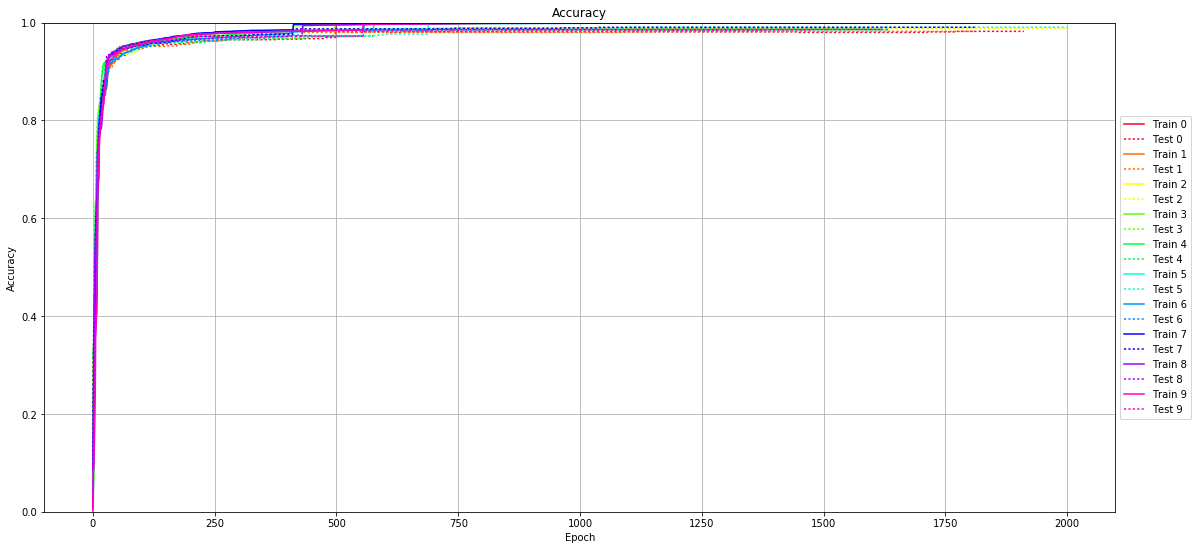

In [14]:
plot_acc(history)

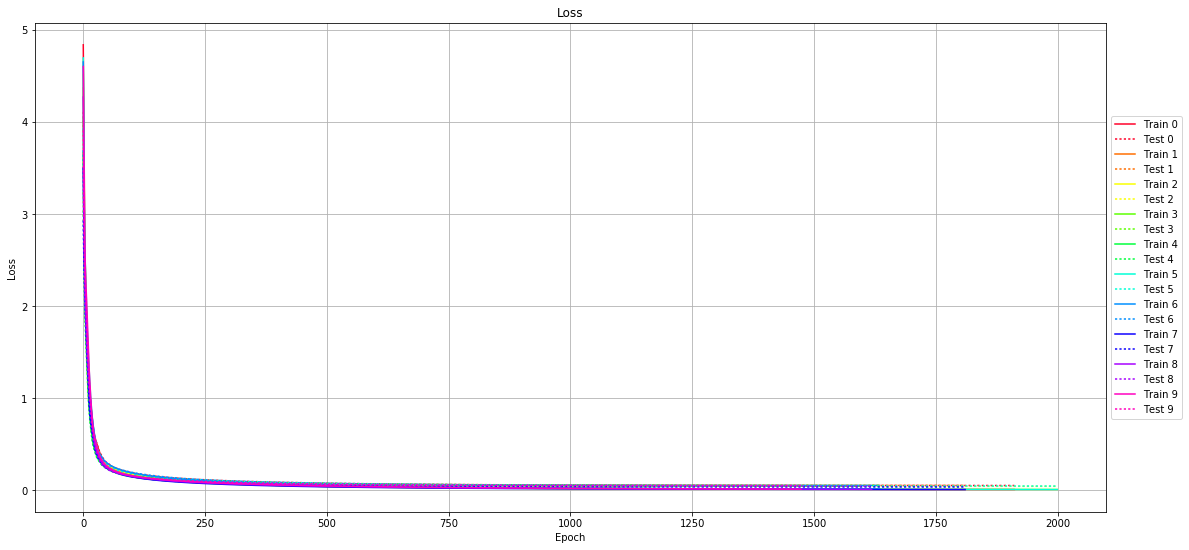

In [15]:
plot_loss(history)

In [16]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


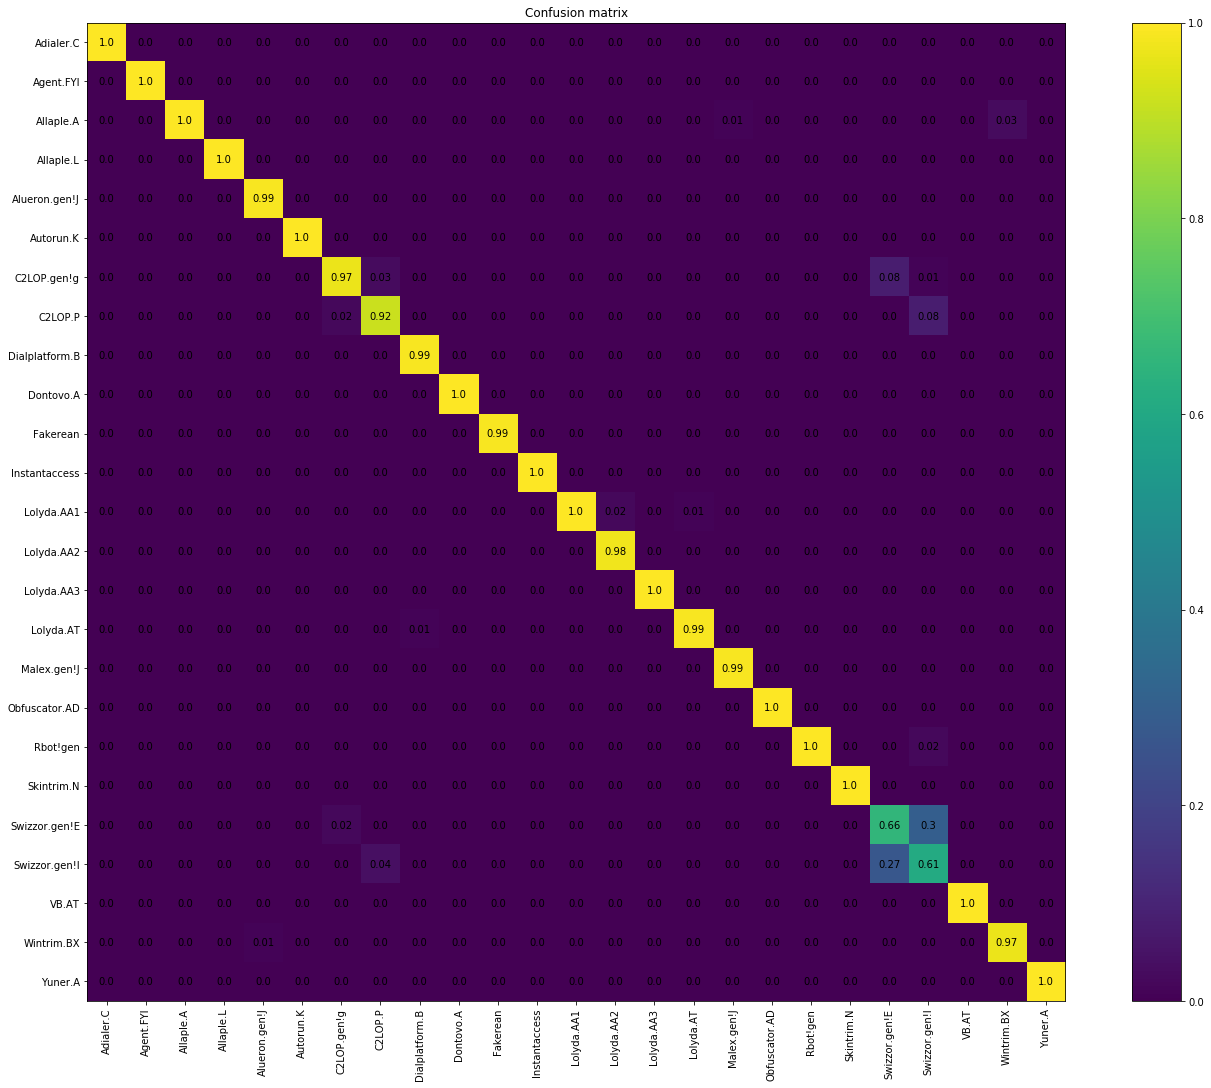

In [17]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()